In [1]:
import pandas as pd
import os
import numpy as np
import ast
from IPython.core.debugger import set_trace


import nltk, re, pickle
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

ps = PorterStemmer()




def Remove_URLs(x):
    x = word_tokenize(x)
    x = [i for i in x if not len(re.findall(r'[\w\.-]+@[\w\.-]+',i))]
    x = ' '.join(x)
    return x


def PreprocessSplitMails(mail):
    mails = re.split('Subject:|Envoyé :',mail)
    for i, info in enumerate(mails[1:]):
        if 'Cc:' in info:
            mails[i+1] = info.splitlines()[0] + '   Subject \n ' + info[re.search(r"Cc:([^\n]*)", info).end():]
    return mails


def ContentExtraction(mail, ContentSplitters):
    lmtr = [lmtr for lmtr in ContentSplitters if lmtr in mail.lower()]
    if len(lmtr)>0:
        limiter = re.search(lmtr[0], mail.lower()).start()
        return mail[:limiter]
    return mail

def PreprocessMails(mails, content=False):
    ProcessedMails = []
    for mail in mails:
        import re
        text = re.sub(r'^https?:\/\/.*[\r\n]*', '', mail, flags=re.MULTILINE)
        text = ContentExtraction(text, ContentSplitters)
        text = Remove_URLs(text)
        if content:
            ProcessedMails.append(text)
            continue
        text = tokenize(text)
        text = Lemmatization(text)
        ProcessedMails.append(' '.join(text))
    return ProcessedMails

def FilterWords(text, tokens=None, Nouns=False):
    Verbs = ['VB','VBP','RB','VBN']
    text_tokens = nltk.pos_tag(nltk.tokenize.word_tokenize(text))
    if isinstance(tokens,str) and tokens=='nouns':
        verbs = [i[0] for i in text_tokens if i[1].startswith('NN') or i[1]=='CD']
    elif isinstance(tokens,str) and tokens=='verbs':
        verbs = [i[0] for i in text_tokens if i[1] in Verbs]
    else:
        verbs = [i[0] for i in text_tokens if i[1] in tokens]
    return ' '.join(verbs)

def POS_Extract(mails, parts='verbs', content=False):    
    ProcessedMails = PreprocessMails(mails, content=content)
    text = ' '.join(ProcessedMails)
    if content:
        return text
    text = FilterWords(text, tokens=parts)
    return text


# Prioritize the Delimiter with Thanks and Regards like
MailSplitters = 'Subject:|Envoyé :'
ContentSplitters  = ['best regards', 'rgds ','b rgds', '\ngreetings', '\nthanks.', '\nthanks,', '\nthank you','\nthank you,', '\nthank you\n', 'sincerely', 'regard ',
                      'regards', 'kind regards', 'forwarded', '\ntel:', '\nMobile:', '\nall the best,','\ncordially',
                      '[image: image.png]','thx','Tel:','Fax:','greeting', '\nproject manager ', 'from:', 'envoyé :', 
                      'the information contained in this email are confid', '------- forwarded message -----', 
                      'proprietary and confidential.','\nthanks a lot', 'tel. ','Please consider your environmental responsibility',
                      'The administrator of your personal data', 'Deze email en de bijgevoegde']

Delimiters = '|'.join(['Lastone','regards','Sincerely', 'Thank','Forwarded', 'The Information', 
                       'tel-mob-email-mobile', 'greeting', 'please note', 'thx', 'Tel:','Fax:'])
# # df = pd.read_excel(r'D:\Notsaved\viswanadhapa\Downloads\Ticket data.xlsx')
# df2 = df1.loc[df1['T_Description'].ne('None')]
# df2['DescriptionMails'] = df2['T_Description'].fillna('').apply(PreprocessSplitMails)  #.str.split('Subject:|Envoyé :')#.apply(lambda text: [re.split(Delimiters, te)[0] for te in text])

JsonData= '{"RIndex":{"0":0,"1":1,"2":2,"3":3,"4":4,"5":5,"6":6,"7":7,"8":8,"9":9,"10":10,"11":11,"12":12,"13":13,"14":14,"15":15,"16":16,"17":17,"18":18,"19":19,"20":20,"21":21,"22":22,"23":23,"24":24,"25":25,"26":26,"27":27,"28":28,"29":29,"30":30,"31":31,"32":32,"33":33,"34":34,"35":35,"36":36,"37":37,"38":38,"39":39,"40":40,"41":41,"42":42,"43":43,"44":44,"45":45,"46":46,"47":47,"48":48,"49":49,"50":50,"51":51,"52":52,"53":53,"54":54,"55":55,"56":56,"57":57,"58":58,"59":59,"60":60,"61":61,"62":62,"63":63,"64":64,"65":65,"66":66,"67":67,"68":68,"69":69,"70":70,"71":71,"72":72,"73":73,"74":74,"75":75,"76":76,"77":77,"78":78,"79":79,"80":80,"81":81,"82":82,"83":83,"84":84,"85":85,"86":86,"87":87,"88":88,"89":89,"90":90,"91":91,"92":92,"93":93,"94":94,"95":95,"96":96,"97":97,"98":98,"99":99},"Ticket Number":{"0":1163982,"1":1182411,"2":1163985,"3":1182418,"4":1163999,"5":1164007,"6":1182426,"7":1201004,"8":1164009,"9":1182433,"10":1164015,"11":1201011,"12":1164030,"13":1182436,"14":1201023,"15":1164031,"16":1182439,"17":1201026,"18":1145237,"19":1164039,"20":1182440,"21":1201027,"22":1145259,"23":1164059,"24":1182449,"25":1201028,"26":1182450,"27":1201029,"28":1145269,"29":1182456,"30":1201030,"31":1145273,"32":1201032,"33":1145276,"34":1164075,"35":1182475,"36":1201040,"37":1145289,"38":1164076,"39":1182477,"40":1201041,"41":1145292,"42":1164080,"43":1182480,"44":1201047,"45":1145297,"46":1164087,"47":1182482,"48":1201053,"49":1164094,"50":1182484,"51":1145300,"52":1164106,"53":1182488,"54":1201064,"55":1145305,"56":1164108,"57":1182491,"58":1201074,"59":1182495,"60":1145311,"61":1182499,"62":1145316,"63":1164115,"64":1182513,"65":1164121,"66":1182522,"67":1201104,"68":1164145,"69":1182523,"70":1201175,"71":1182526,"72":1201178,"73":1164156,"74":1182527,"75":1164166,"76":1201201,"77":1164168,"78":1182537,"79":1201206,"80":1164175,"81":1201227,"82":1145331,"83":1164179,"84":1182545,"85":1201236,"86":1164185,"87":1182550,"88":1201240,"89":1164189,"90":1182553,"91":1201241,"92":1164194,"93":1182565,"94":1201242,"95":1164195,"96":1182567,"97":1145348,"98":1164198,"99":1182574},"Customer Name":{"0":"Schmid Transport und Spedition GmbH","1":"ISOTOPES SERVICES INTERN. NV","2":"TRAVADRI NV","3":"Kuznia Trans","4":"Favaro Servizi srl","5":"WABCO Internal","6":"STRUMIA SAS","7":"Asko Norge","8":"Rosenlunds \\u00c5keri Ab","9":"Post-Kogeko Services B.V.","10":"WABCO Internal","11":"H. ESSERS TRANSPORT COMPANY N.V.","12":"VAN DER WERFF LOGISTICS HEERENVEEN BV","13":"SONCOTRA TRANSPORT NV","14":"DLG Equipment B.V.","15":"Schmid Transport und Spedition GmbH","16":"Van Rooi Meat B.V.","17":"Routier European Transport Srl","18":"UAB GIRTEKA LOGISTICS","19":null,"20":"T.E.E.","21":"GCATRANS","22":"BLC","23":"T.E.E.","24":"TRANSPORT STOELEN BVBA","25":"TRANSPORTS BATIMENTS TRAVAUX PUBLICS (TBTP)","26":"STARK Deutschland GmbH","27":"Trans Sarria","28":"HST BV","29":"SOCIETE LA ROUTE","30":"BLONDEL TRANSPORTS","31":"TSL Sp.z.o.o.","32":"VOS TRANSPORT BV","33":"Wed. J. de Bruyn en Zonen BV","34":"HST BV","35":null,"36":"Renova AB","37":"Transegre, S.L.","38":"STEF TRANSPORTS SENS (GREGOIRE GALLIARD)","39":"RIOS SANGIAO, S.L.","40":"WABCO Internal","41":"Fernlast Transport GmbH & Co. KG","42":"T.E.E.","43":"Kaan Transport B.V.","44":"Almajdouie Logistics","45":"Baynak Uluslararas? Nak. Tur. D?? Tic. Ltd. ?ti.","46":"Professional Thermo Logistics (PTL)","47":"ALEGRE Logistic Sp. z o.o. Sp. k.","48":"INPE TRANSPORT LTD","49":"SAMSE","50":"Vepco Transport BV","51":"MB TRANSPORTS sa","52":"SAMSE","53":"ROSNER LOGISTIK GMBH","54":"ARINTEC SIGLO XXI, S.L.","55":"MB TRANSPORTS sa","56":"WABCO Internal","57":"NV Vervoer TRANSMET","58":"VISBEEN A. & ZN B.V.","59":"VAN DER WERFF LOGISTICS HEERENVEEN BV","60":"MB TRANSPORTS sa","61":"TRANSPORTS DORCHIES SAS","62":"MB TRANSPORTS sa","63":"WABCO Internal","64":"Terrena","65":"MARPOL Sp. z o.o. Sp. k.","66":"Intertransavto LLC","67":"Jim Pearson Transport","68":"SAMSE","69":"UAB GIRTEKA LOGISTICS","70":"G\\u00f3lcz & Synowie Sp. z o.o. Sp. k.","71":"POINT P SONEN","72":"WABCO Internal","73":"WABCO Internal","74":"Heisterkamp Transport B.V.","75":"TINE AS","76":"CORSE TRANSPORT SARL","77":"GILLIERS","78":"Transports FOLIE Olivier","79":"WABCO Internal","80":"Mantova Diesel srl","81":"GABTRANS","82":"MB TRANSPORTS sa","83":"Favaro Servizi srl","84":"Istrate Com srl","85":"MAUFFREY EQUIPEMENT SAS (Si\\u00e8ge)","86":"ECEIZA TRANSPORTES","87":"TAILORMADE LOGISTICS BVBA","88":"UAB GIRTEKA LOGISTICS","89":"TRADISA","90":"GT LOCATION","91":"VAN BOGAERT TRANSPORT BVBA","92":"Cerbaratrans sro","93":"KO-TRANS D.O.O","94":"UAB GIRTEKA LOGISTICS","95":"Van den Broek Sneltransport B.V. ( RUTOM )","96":"D\'EER BVBA","97":"MB TRANSPORTS sa","98":"WABCO Internal","99":"SAS ZAMENHOF EXPLOITATION - JACKY PERRENOT"},"Subject":{"0":"R HS 872 update and RDD","1":"VEHICLE 1-WRK-981only one measurement from temperatures sensors S2 an S1 at 14:07","2":"TMS tanksysteem * C01000674","3":"FW: Pardot Form: Transics - Contact Us (ENG) - piotr.hojka@kuznia-trans.pl","4":"mezzo 192: Ceban Sergiu","5":"Mixed Fleet Setup for D\'eer on Fieldtest","6":"[TX SKY] - le client a perdu un camion  EA 943 ZR","7":"Please change  minimum version of TX-SMART","8":"Fwd: Daglig t\\u00f6mning f\\u00e4rdskrivare","9":"Update Appversie  (S2002 053)","10":"Re: Lieu du pointage des missions","11":"Essers unit problems","12":"(nieuwe) SKY mist externe GPS antenne","13":"QAJT269 geen doorlock","14":"Device identified as Crazy sender IMEI: 354725066132386","15":"Fernupdate starten","16":"Probleem met rapportage","17":"Device identified as Crazy sender IMEI: 351729073787219","18":"Girteka Fleet Update Week 01_02.01.2020(Thursday)","19":"Commentaire segment - Commentaire journ\\u00e9e","20":"lecteur de carte 8124","21":"Device identified as Crazy sender IMEI: 359394055054831","22":"dysfonctionnement de certains vehicules sur les conso D\\u00e9cembre","23":"probleme 8175","24":"1-hgl-855","25":"Device identified as Crazy sender IMEI: 352432062332597","26":"FW: LKW-Nachverfolgung","27":"Device identified as Crazy sender IMEI: 358014090800607","28":"FW: HST BV heeft informatie gezonden","29":"RDD HS: ES-773-GG","30":"Device identified as Crazy sender IMEI: 358014091547918","31":"PO5HS30 - skok poziomu paliwa","32":"Device identified as Crazy sender IMEI: 352432066270454","33":"Br.007 BZ-DT-46","34":"Probleem inds nieuwe vragenbad V17+flex","35":"New authorization form - FREE GO OUEST","36":"Renova PTV","37":"TX-ECO Performance","38":"STOPPED CUSTOMER STEF TRANSPORT SENS\\/ C02001046 ( ex- GREGOIRE GALLIARD) as from 1\\/01\\/2020","39":"EQUIPO SIN SE\\u00d1AL DESDE EL DIA 09\\/02","40":"JAVAGO - password RDD must be the same on fleet and sky environment","41":"St\\u00f6rung","42":"probleme 8176","43":"Problemen week 6","44":"FW: Re- VTS updates","45":"Trailerguard Status Baynak Logistics","46":"cities outside poland are displayed in English","47":"TX-Connect","48":"Navi update Sky","49":"Acc\\u00e8s \\u00e0 MYUSERS","50":"Overtredingenoverzicht TX-Social","51":"G8 probl\\u00e8me transics demande d\'intervention","52":"Re: Demande info lecteur de carte Samse","53":"[#89232] Timout of Service DriverLogins - Customer \\"Rosner\\"","54":"Re: Control de estado TRAXEE para dispositivo 359315078096137","55":"probl\\u00e8me transics demande d\'intervention G5","56":"HEXATRANS (CONHEXA) - Fleet servor activation","57":"Problemen dienstijden voertuig 746","58":"Vehicle from InterIsle environment -> DLG environment","59":"BC koppeling Centric P&G --> Transics","60":"probl\\u00e8me transics demande d\'intervention G2","61":"Service: Activation - Hosting |New Setup ( SKY ) | TRANSPORTS DORCHIES SAS (productionB) | SQ02044929","62":"probl\\u00e8me transics demande d\'intervention G6","63":"Re: Ecoservice","64":"Activation option \\"Cartographie\\" sur tablette","65":"TCI code (BWEDNKTE)","66":"Fwd: ???????? ??????? Transics","67":"NEW Customer - Jim Pearson","68":"Probl\\u00e8me de GPS camion SAMSE","69":"LES_503 (TRMTR) - RDD download needed","70":"PP3246G","71":"URGENT Probl\\u00e8me d\\u00e9tails de marchandises dans boitier TX-Max","72":"Integration with E-100","73":"Fwd: TX Service- Generic settings","74":"FW: rapport van Mourmans wk5 leeg","75":"Re: Transics","76":"Manque d\'activit\\u00e9s Tx-social","77":"Temps de service GILLIERS","78":"[TX SKY] pas de son et luminosit\\u00e9 faible FT 9664","79":"Fwd: Opstart vergadering 18\\/02\\/2020","80":"Mantova Diesel","81":"Brak przesy?u danych z tacho","82":"probl\\u00e8me transics demande d\'intervention G9","83":"Satellitare mezzo 201 bloccato","84":"ISTRATE close hosting today at 11am","85":"[GLPI #0047409] FN-590-DT  - Erreur conducteur : Nouveau suivi | Mauffrey","86":"La tractora MH-02-TSM est\\u00e1 parada desde el 14\\/12, pero desde ayer aparece que est\\u00e1 circulando","87":"4 x TX-GEO offline","88":"Girteka Fleet Update Week 10_02.03.2020(Monday)","89":"C-4503 3248KTN no posiciona correctamente.","90":"TX-MAX : V\\u00e9hicules RDD HS.","91":"1WXX455","92":"t\\u00e9l\\u00e9chargement de donn\\u00e9es","93":"Service times","94":"GPS positioning problems (URGENT)","95":"Berichten niet uit inbox","96":"Fwd: al regelmatig gehad, systeem blokkeert hierop en moet via task manager afgesloten worden om terug op te starten","97":"probl\\u00e8me transics demande d\'intervention C8","98":"Mantova Diesel: TX_GO app","99":"PERRENOT - d\\u00e9croche AGENCE ?"},"Description":{"0":"R HS 872 update and RDD","1":"ELIEN ROUSSEL\\nAdministration Marketing\\/HR\\n\\n\\nFrom: Pardot <info@pardot.com>\\nSent: Friday, 7 February 2020 17:26\\nTo: Info <Info@transics.com>\\nSubject: Pardot Form: Transics - Contact Us (ENG) - AM.VANDEVORDT@ISOTOPES.COM\\n\\n\\n\\n[Pardot]<http:\\/\\/www.pardot.com\\/>\\n\\nPardot Form Notification\\nView Prospect<https:\\/\\/pi.pardot.com\\/prospect\\/read\\/id\\/112010501> | View Prospect in CRM<https:\\/\\/wabco.my.salesforce.com\\/00Q0X00000hDujAUAS>\\n\\nForm Submission: Transics - Contact Us (ENG)\\nField\\n\\nValue\\n\\nEmail\\n\\nAM.VANDEVORDT@ISOTOPES.COM<mailto:AM.VANDEVORDT@ISOTOPES.COM>\\n\\n\\n\\nFull Prospect Details\\n\\n\\nField\\n\\nValue\\n\\nEmail\\n\\nAM.VANDEVORDT@ISOTOPES.COM<mailto:AM.VANDEVORDT@ISOTOPES.COM>\\n\\nFirst name\\n\\nAnne Marie\\n\\nLast name\\n\\nVANDEVORDT\\n\\nCompany\\n\\nISI\\n\\nCampaign\\n\\nTransics Lead Generation\\n\\nScore\\n\\n72\\n\\nAssigned user\\n\\nNot assigned\\n\\nPhone\\n\\n+32475347070\\n\\nCountry\\n\\nBelgium\\n\\nSource\\n\\nGoogle Ad\\n\\nOriginal Referring URL\\n\\nhttps:\\/\\/www.google.com\\/\\n\\nDo Not Email\\n\\nTrue\\n\\nContact Form Question\\n\\nTODAY 15-11-2019 WITH OUR VEHICLE 1-WRK-981only one measurement from temperatures sensors S2 an S1 at 14:07. Please deliver us complete temperatures for the trip from 5:30 till 11:50\\n\\nLanguage\\n\\nDutch\\n\\nLead Source (Salesforce Sync)\\n\\nWebsite Tracking - Transics\\n\\nNeverbounce Status\\n\\nunknown\\n\\nOpted In\\n\\nfalse\\n\\nSubscription 1 Original\\n\\nfalse\\n\\nSubscription 2 REMAN\\n\\nfalse\\n\\nSubscription 3 ProVIa\\n\\nfalse\\n\\nSubscription 4 Retrofit\\n\\nfalse\\n\\nSubscription 5 Transics\\n\\nfalse\\n\\nSubscription 6 TRAXEE\\n\\nfalse\\n\\nSubscription 7 Workshop Solutions\\n\\nfalse\\n\\nSubscription 8 Academy\\n\\nfalse\\n\\nSubscription Market Info\\n\\nfalse\\n\\nSubscription Survey\\n\\nfalse\\n\\nSubscription Webshop\\n\\nfalse\\n\\nTransics Lead\\n\\nTrue\\n\\n\\nRecent Activity\\nActivity\\n\\nType\\n\\nDate \\/ Time\\n\\nForm: Transics - Contact Us (ENG)\\n\\nSuccess\\n\\nFeb 7, 2020 5:24 PM\\n\\nVisitor\\n\\nVisitor\\n\\nFeb 7, 2020 5:24 PM\\n\\nForm: Transics - Contact Us (ENG)\\n\\nView\\n\\nFeb 7, 2020 5:24 PM\\n\\nForm: Transics - Contact Us (ENG)\\n\\nSuccess\\n\\nNov 15, 2019 2:31 PM\\n\\nForm: Transics - Contact Us (ENG)\\n\\nView\\n\\nNov 15, 2019 2:28 PM\\n\\n\\n\\n\\n\\n\\n\\n\\n\\nSalesforce<http:\\/\\/www.salesforce.com\\/>\\n415 Mission St.\\nSan Francisco, CA 94105","2":"Beste,\\n\\nIk probeer in TMS voor 2019 een chronologisch rapport van alle tankbeurten \'diesel\' af te printen.\\n\\nIk doe dit via Rapporten - Tankbeurten - Overzicht\\nDaar vul ik alle parameters in maar krijg steeds de melding : Geen gegevens gevonden voor huidige selectie.\\n\\nHoe kan ik dit oplossen?\\n\\nAlvast hartelijk dank bij voorbaat!\\n\\nMet vriendelijke groet,\\n\\nRosine Van Driessche\\n\\nVoor Travadri nv\\n           Zwijnaardsesteenweg 93\\n           9820 Merelbeke\\n           Tel 09\\/230 68 74","3":"Mvg\\n\\nELIEN ROUSSEL\\nAdministration Marketing\\/HR\\n\\n\\nFrom: Pardot <info@pardot.com>\\nSent: Monday, 10 February 2020 08:00\\nTo: Info <Info@transics.com>\\nSubject: Pardot Form: Transics - Contact Us (ENG) - piotr.hojka@kuznia-trans.pl\\n\\n\\n\\n[Pardot]<http:\\/\\/www.pardot.com\\/>\\n\\nPardot Form Notification\\nView Prospect<https:\\/\\/pi.pardot.com\\/prospect\\/read\\/id\\/105673437> | View Prospect in CRM<https:\\/\\/wabco.my.salesforce.com\\/0030X00002JTLUhQAP>\\n\\nForm Submission: Transics - Contact Us (ENG)\\nField\\n\\nValue\\n\\nFirst Name\\n\\nPiotr\\n\\nLast Name\\n\\nHojka\\n\\nEmail\\n\\npiotr.hojka@kuznia-trans.pl<mailto:piotr.hojka@kuznia-trans.pl>\\n\\nPhone\\n\\n+48506013924\\n\\nCompany\\n\\nCountry\\n\\nPoland\\n\\nLanguage\\n\\nPolish\\n\\nContact Form Question\\n\\nI cannot login to my transics account, \'\'LOGIN FAILED\\", same problem I had a friday for half of the day, same problem i have now\\n\\nOpted In\\n\\n\\n\\nFull Prospect Details\\n\\n\\nField\\n\\nValue\\n\\nEmail\\n\\npiotr.hojka@kuznia-trans.pl<mailto:piotr.hojka@kuznia-trans.pl>\\n\\nFirst name\\n\\nPiotr\\n\\nLast name\\n\\nHojka\\n\\nCampaign\\n\\nSalesforce.com\\/Pardot\\n\\nScore\\n\\n35\\n\\nAssigned user\\n\\nStefanie Lagast\\n\\nPhone\\n\\n+48506013924\\n\\nJob title\\n\\nDyspozytor\\n\\nCountry\\n\\nPoland\\n\\nFax\\n\\n+48323260636\\n\\nOriginal Referring URL\\n\\nhttps:\\/\\/www.transics.com\\/get-in-touch\\/contact-f...\\n\\nBusiness Type (from SF)\\n\\nFleet\\n\\nCommunity_Username__c\\n\\npiotr.hojka@kuznia-trans.pl<mailto:piotr.hojka@kuznia-trans.pl>\\n\\nContact Form Question\\n\\nI cannot login to my transics account, \'\'LOGIN FAILED\\", same problem I had a friday for half of the day, same problem i have now\\n\\nLanguage\\n\\nPolish\\n\\nNeverbounce Status\\n\\nvalid\\n\\nPrimary Contact\\n\\nfalse\\n\\nReady for Real time offer sent\\n\\nfalse\\n\\nReady for Real-time Offer\\n\\nfalse\\n\\nSubscription 1 Original\\n\\ntrue\\n\\nSubscription 2 REMAN\\n\\nfalse\\n\\nSubscription 3 ProVIa\\n\\nfalse\\n\\nSubscription 4 Retrofit\\n\\nfalse\\n\\nSubscription 5 Transics\\n\\nfalse\\n\\nSubscription 6 TRAXEE\\n\\nfalse\\n\\nSubscription 7 Workshop Solutions\\n\\nfalse\\n\\nSubscription 8 Academy\\n\\nfalse\\n\\nSubscription Market Info\\n\\nfalse\\n\\nSubscription Survey\\n\\nfalse\\n\\nSubscription Webshop\\n\\ntrue\\n\\nTransics Lead\\n\\nTrue\\n\\n\\nRecent Activity\\nActivity\\n\\nType\\n\\nDate \\/ Time\\n\\nForm: Transics - Contact Us (ENG)\\n\\nSuccess\\n\\nFeb 10, 2020 7:58 AM\\n\\nVisitor\\n\\nVisitor\\n\\nFeb 10, 2020 7:57 AM\\n\\nForm: Transics - Contact Us (ENG)\\n\\nView\\n\\nFeb 10, 2020 7:57 AM\\n\\nEmail: ...azdy flotowe bezpieczniejszymi\\n\\nSent\\n\\nJan 15, 2020 2:08 PM\\n\\nEmail: ...yczymy wszystkiego najlepszego\\n\\nSent\\n\\nDec 18, 2019 2:06 PM\\n\\n\\n\\n\\n\\n\\n\\n\\n\\nSalesforce<http:\\/\\/www.salesforce.com\\/>\\n415 Mission St.\\nSan Francisco, CA 94105","4":"Buongiorno,  ha chiamato l?autista del mezzo 192 CEBAN SERGIU il quale dice di non riuscire pi\\u00f9 a visualizzare le attivit\\u00e0 di CARICO - SCARICO - AGGANGIO - SGANCIO e RIFORNIMENTO nel satellitare. (vedi fotografie)\\n\\nPotete verificare?\\nRiuscite eventualmente a fargli un aggiornamento?\\n\\nGrazie\\n\\nOmar Schiavon","5":"My planned date for mixed conversion for D?eer is Tuesday, 28\\/02\\/2020.\\nIf you prefer it on a different date, please let me know.\\n\\nNote this is a setup on Field-Test.\\n\\nThis is a phase 1 setup, with Tx-Social ( cat. 1.1 )\\nThere is no Social now on Fleet or Sky. I assume Tx-Social Expert BE will need to be setup\\n\\n\\nThere are no issues anymore on Fleet DB.\\nFleet is Sybase, but we keep it like that.\\nSky is setup already on Field-Test.\\nCybage upfront test is already done successfully.\\n\\n\\nTo do:\\n\\n1.\\tCustomizing has to map the Standard Activities. To be done ASAP\\n2.\\tProject Engineer has to check with Customizing if new Sky IS needs to be created and mapped ASAP\\n3.\\tCybage upfront CT check to be completed before 28\\/02\\/2020\\n4.\\tHosting has to check if conversion is possible on 28\\/02\\/2020","6":"le client a perdu un v\\u00e9hicule il s\'agit du EA 943 ZR\\n$le chauffeur ne r\\u00e9pond pas et le camion n est plus visible sur les solutions TRANSICS\\nAlain demande un reset de l\'ODB","7":"Hi Team.\\nWe are updating all our TX-SMART according to the attached list tonight, at 18:00, to v 11.0.0.13, can you please change so that minimum version is allowed and set it to v11.0.0.13?\\nPlease do this before midnight as some users start tomorrow morning and will then have the new 11.0.0.13 version to log on to.\\n\\n\\nVennlig Hilsen \\/ Kind Regards\\nMarius Malum-Sol\\u00f8st\\n________________________________\\nNorgesGruppen Data AS\\nTlf. + 47 24 17 60 00 \\/ Mobil + 47 975 09 984\\nmarius.malum@norgesgruppen.no<mailto:marius.malum@norgesgruppen.no>\\n\\nThis e-mail message may contain confidential or privileged information. If you are not the intended recipient, please delete the message and any attachments and notify the sender by return e-mail. You should not retain, distribute, disclose, or use any of the information in this message.","8":"Hej Bj\\u00f6rn,\\n\\nKan du kolla dessa bilar?\\nVi s\\u00e4tter ju inte individuella parametrar per bil utan bara per f\\u00f6retag, s\\u00e5\\nantar att det \\u00e4r n\\u00e5got annat som stoppat dessa nedladdningar\\n\\nKind regards \\/ Med v\\u00e4nlig h\\u00e4lsning\\n\\n*Martin Selfors*\\nOperations Leader DCS Scandinavia\\n\\n*WABCO* Automotive AB\\nBox 188 (Drakegatan)\\nSE- 401 23 G\\u00f6teborg, Sweden\\n\\nMob: +46 735 35 36 02\\n\\nmartin.selfors@wabco-auto.com\\n\\nwww.wabco-auto.com \\/ www.transics.com\\n\\nVideo: WABCO - Advanced Fleet Management Solutions\\n<https:\\/\\/www.youtube.com\\/watch?v=7olUqS5Wqpc&t=3s>\\n\\n\\n---------- Forwarded message ---------\\nFrom: Ubbe Johansson <ubbe@rosenlundsakeri.se>\\nDate: Thu, Jan 23, 2020 at 9:26 AM\\nSubject: Sv: Daglig t\\u00f6mning f\\u00e4rdskrivare\\nTo: Selfors , Martin <martin.selfors@wabco-auto.com>\\n\\n\\nHej Martin!\\n\\nNedladdningen fungerar som det var t\\u00e4nkt, men det \\u00e4r tre bilar som har fel\\nnedladdnings  intervall. Det \\u00e4r AEB 320, EGG 816 och SAR 26P\\n\\n\\n\\nMed v\\u00e4nlig h\\u00e4lsning\\n\\nUrban Johansson\\n\\n\\n\\n[image: ROSENLUNDS \\u00c5KERI AB (3)]\\n\\n\\n\\nMob: 076-1280139\\n\\nFax: 036-316670\\n\\nubbe@rosenlundsakeri.se\\n\\nwww.rosenlundsakeri.se\\n\\nAlla uppdrag utf\\u00f6res i enlighet med Alltrans 2007.\\n\\n\\n\\n\\n\\n*Fr\\u00e5n:* Selfors , Martin <martin.selfors@wabco-auto.com>\\n*Skickat:* den 13 januari 2020 08:24\\n*Till:* Ubbe Johansson <ubbe@rosenlundsakeri.se>; Jan Andersson (external) <\\njan.andersson@wabco-auto.com>\\n*\\u00c4mne:* Re: Daglig t\\u00f6mning f\\u00e4rdskrivare\\n\\n\\n\\nHej Ubbe,   och god forts\\u00e4ttning!\\n\\n\\n\\nT\\u00e4nkte bara h\\u00f6ra om det fungerat bra med nedladdning nu?\\n\\n\\n\\nF\\u00f6r info s\\u00e5 ser vi en del problem ifr\\u00e5n stoneridge och vdo med de nya\\nkorten transportstyrelsen utf\\u00e4rdat, s\\u00e5 h\\u00f6r av er innan ni b\\u00f6rjar skifta\\n\\n\\n\\n\\n\\nBest regards,\\n\\nMartin Selfors,\\n\\nOperations Leader, Scandinavia\\n+46 735 35 36 02\\n\\n\\n\\nDen tors 19 dec. 2019 21:52Selfors , Martin <martin.selfors@wabco-auto.com>\\nskrev:\\n\\nHej Ubbe!\\n\\n\\n\\nOk vi k\\u00f6r p\\u00e5 det, ber dem aktivera det och s\\u00e4tter dig i kopia s\\u00e5 vet du n\\u00e4r\\ndet \\u00e4r ig\\u00e5ng.\\n\\nDet kan som sagt beh\\u00f6vas fler f\\u00f6retagskort, eftersom det oftast brukar vara\\nflaskhalsen n\\u00e4r man har s\\u00e5 m\\u00e5nga bilar som ni har, men det l\\u00e4r vi se.\\n\\n\\n\\nH\\u00f6rs vi inte innan s\\u00e5 \\u00f6nskar jag en riktigt God jul och Gott nytt!\\n\\nKind regards \\/ Med v\\u00e4nlig h\\u00e4lsning\\n\\n*Martin Selfors*\\nOperations Leader DCS Scandinavia\\n\\n*WABCO* Automotive AB\\nBox 188 (Drakegatan)\\nSE- 401 23 G\\u00f6teborg, Sweden\\n\\nMob: +46 735 35 36 02\\n\\nmartin.selfors@wabco-auto.com\\n\\nwww.wabco-auto.com \\/ www.transics.com\\n\\nVideo: WABCO - Advanced Fleet Management Solutions\\n<https:\\/\\/www.youtube.com\\/watch?v=7olUqS5Wqpc&t=3s>\\n\\n\\n\\n\\n\\nOn Thu, Dec 19, 2019 at 11:59 AM Ubbe Johansson <ubbe@rosenlundsakeri.se>\\nwrote:\\n\\nHejsan!\\n\\nAnledningen till att vi vill ha kopiering varje dag \\u00e4r f\\u00f6r att\\nTransportstyrelsen kr\\u00e4ver att vi f\\u00f6rhindrar att fel beg\\u00e5s,\\n\\nvilket \\u00e4r om\\u00f6jligt. Men kan vi jaga f\\u00f6rare och hitta fel s\\u00e5 snart som\\nm\\u00f6jligt s\\u00e5 kanske vi kan komma att\\n\\nf\\u00f6rhindra att saker sker f\\u00f6r att man kommer undan med det. Vi beh\\u00f6ver ju\\ns\\u00e5ledes bilens data lika v\\u00e4l som chauff\\u00f6rens.\\n\\n\\n\\nMed v\\u00e4nlig h\\u00e4lsning\\n\\nUrban Johansson\\n\\n\\n\\n[image: ROSENLUNDS \\u00c5KERI AB (3)]\\n\\n\\n\\nMob: 076-1280139\\n\\nFax: 036-316670\\n\\nubbe@rosenlundsakeri.se\\n\\nwww.rosenlundsakeri.se\\n\\nAlla uppdrag utf\\u00f6res i enlighet med Alltrans 2007.\\n\\n\\n\\n\\n\\n*Fr\\u00e5n:* Selfors , Martin <martin.selfors@wabco-auto.com>\\n*Skickat:* den 18 december 2019 15:08\\n*Till:* Ubbe Johansson <ubbe@rosenlundsakeri.se>\\n*Kopia:* Jan Andersson (external) <jan.andersson@wabco-auto.com>\\n*\\u00c4mne:* Re: Daglig t\\u00f6mning f\\u00e4rdskrivare\\n\\n\\n\\nHej Ubbe!\\n\\n\\n\\nF\\u00f6rare \\u00e4r nu inst\\u00e4llda p\\u00e5 varje dag, fordonen ligger p\\u00e5 7 dagar.\\n\\n\\u00c4r det f\\u00f6r att ni skall byta till nya f\\u00f6retagskorten som ni vill ha varje\\ndag?\\n\\nIs\\u00e5fall kommer det inte vara till hj\\u00e4lp, utan vi rekommenderar alltid att\\nman g\\u00f6r en manuell utl\\u00e4sning n\\u00e4r man g\\u00f6r skiftet, just f\\u00f6r att man inte ska\\ntappa n\\u00e5gon information mellan v\\u00e5r nedladdning och den manuella.\\n\\nKind regards \\/ Med v\\u00e4nlig h\\u00e4lsning\\n\\n*Martin Selfors*\\nOperations Leader DCS Scandinavia\\n\\n*WABCO* Automotive AB\\nBox 188 (Drakegatan)\\nSE- 401 23 G\\u00f6teborg, Sweden\\n\\nMob: +46 735 35 36 02\\n\\nmartin.selfors@wabco-auto.com\\n\\nwww.wabco-auto.com \\/ www.transics.com\\n\\nVideo: WABCO - Advanced Fleet Management Solutions\\n<https:\\/\\/www.youtube.com\\/watch?v=7olUqS5Wqpc&t=3s>\\n\\n\\n\\n\\n\\nOn Wed, Dec 18, 2019 at 11:51 AM Ubbe Johansson <ubbe@rosenlundsakeri.se>\\nwrote:\\n\\nHej Martin!\\n\\nT\\u00e4nkte kolla hur det g\\u00e5r med att f\\u00e5 ig\\u00e5ng daglig f\\u00e4rdskrivarkopiering p\\u00e5\\nbilarna.\\n\\n\\n\\nMed v\\u00e4nlig h\\u00e4lsning\\n\\nUrban Johansson\\n\\n\\n\\n[image: ROSENLUNDS \\u00c5KERI AB (3)]\\n\\n\\n\\nMob: 076-1280139\\n\\nFax: 036-316670\\n\\nubbe@rosenlundsakeri.se\\n\\nwww.rosenlundsakeri.se\\n\\nAlla uppdrag utf\\u00f6res i enlighet med Alltrans 2007.\\n\\n\\n\\n\\n\\n\\n------------------------------\\n\\nProprietary and confidential. It is for use by the addressee only. If you\\nare not the addressee or If you received this email in error, please notify\\nthe sender and delete it and any attachments. All communications are\\nsubject to our Data Protection Policy that can be found at\\n*https:\\/\\/www.wabco-auto.com\\/footer\\/legal\\/legal\\/privacy-statement\\/\\n<https:\\/\\/www.wabco-auto.com\\/footer\\/legal\\/legal\\/privacy-statement\\/>* . By\\ncommunicating with us via e-mail, you agree to the policy. WABCO does not\\nguarantee that this email has not been intercepted, amended, or is\\nvirus-free. No liability is accepted for viruses and it is your\\nresponsibility to scan any attachments. Technical data and\\/or information\\nprovided in this email or any attachment may be subject to U.S. export\\ncontrol laws. Export, re-export, diversion or disclosure contrary to U.S.\\nlaw is prohibited\\n\\n\\n------------------------------\\n\\nProprietary and confidential. It is for use by the addressee only. If you\\nare not the addressee or If you received this email in error, please notify\\nthe sender and delete it and any attachments. All communications are\\nsubject to our Data Protection Policy that can be found at\\n*https:\\/\\/www.wabco-auto.com\\/footer\\/legal\\/legal\\/privacy-statement\\/\\n<https:\\/\\/www.wabco-auto.com\\/footer\\/legal\\/legal\\/privacy-statement\\/>* . By\\ncommunicating with us via e-mail, you agree to the policy. WABCO does not\\nguarantee that this email has not been intercepted, amended, or is\\nvirus-free. No liability is accepted for viruses and it is your\\nresponsibility to scan any attachments. Technical data and\\/or information\\nprovided in this email or any attachment may be subject to U.S. export\\ncontrol laws. Export, re-export, diversion or disclosure contrary to U.S.\\nlaw is prohibited","9":"Goedemorgen,\\n\\nKunnen jullie een update starten van de Appversie van IMEI nummer 351729073915117.\\nHierop draait nog versie 2.26 en ik zou graag versie 3.4.19425.15061 zien.\\n\\nAlvast bedankt,\\nGr Fred\\n\\nMet vriendelijke groet, Kind regards,\\n\\nFred van Rijn | Post-Kogeko Groep\\n[cid:Post_Kogeko_image_46698495-acbe-4d33-b01f-9cdb1c981a53.png]\\n\\n\\nPost-Kogeko\\nT  +31 174 531795\\nM +31 6 21215134\\n\\nwww.post-kogeko.nl<http:\\/\\/www.post-kogeko.nl\\/>\\n\\n\\n\\n\\n[cid:Twitter_b55bb2d6-d19c-4ef4-b52a-eea6bb5d7132.png]<https:\\/\\/twitter.com\\/postkogekolog>\\n[cid:Linkedin_2_ecb37f56-e362-4030-a00c-da6441f9fdd4.png]<https:\\/\\/www.linkedin.com\\/company\\/post-kogeko-logistics\\/>\\n[cid:Facebook_d46f1f49-d7c1-4485-bd23-f61b62c9118d.png]<https:\\/\\/nl-nl.facebook.com\\/PostKogekoLogistics>\\n\\n\\nPost-Kogeko is registered at the chamber of commerce with number 27169292. Legal disclaimer http:\\/\\/www.post-kogeko.nl\\/NL\\/voorwaarden\\/disclaimer\\n\\nP Please consider the environment before printing this e-mail.","10":"Hi Integration Team,\\n\\nCan you answer the question below please.\\n\\nThanks.\\n\\nKind regards,\\n\\n*JONATHAN BAYART*\\nProject Manager\\n06.79.82.59.74\\n\\n\\nLe mer. 22 janv. 2020 \\u00e0 16:22, Nathalie MARTIN <\\nn.martin@prevost-transports.com> a \\u00e9crit :\\n\\n> Jonathan, bonjour\\n>\\n>\\n>\\n> Peut tu me dire ou je peux trouver dans le web service, le lieu o\\u00f9 la\\n> mission a \\u00e9t\\u00e9 point\\u00e9 (celui qui correspond aux kilom\\u00e9trages).\\n>\\n> Nous avons besoin de le remonter dans le TMS.\\n>\\n>\\n>\\n> Urgent.\\n>\\n> Merci\\n>\\n>\\n>\\n> Merci Nathalie\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n> *Nathalie MARTIN*\\n>\\n> *n.martin@prevost-transports.com <n.martin@prevost-transports.com>*\\n>\\n>\\n>\\n> *TRANSPORTS PREVOST*\\n>\\n>\\n>\\n> [image:\\n> cid:1A30B8BC-3AB3-4028-B0C0-64BA10A1B416@no-dns-available.example.com]\\n>\\n>\\n>\\n> *Mobile :  06 71 74 73 08*\\n>\\n> [image: TSP]\\n> <https:\\/\\/www.retromobile.fr\\/visiteurs\\/Le-salon\\/Actualites-du-salon-Retromobile\\/Actualites-2019\\/Transports-Prevost-transporteur-officiel-de-Retromobile>\\n>\\n>\\n> *[image:\\n> cid:E4516873-3992-402C-87DF-55D8807438BE@no-dns-available.example.com]*\\n> <https:\\/\\/fr-fr.facebook.com\\/prevost.transports\\/> *[image:\\n> cid:6EF37D7A-E445-4A7B-9ABA-964B0428D104@no-dns-available.example.com]*\\n> <https:\\/\\/www.linkedin.com\\/company\\/3999814\\/> *[image:\\n> cid:C9548E75-4C0D-425B-8B6F-1CD2BABF5F7F@no-dns-available.example.com]*\\n> <https:\\/\\/twitter.com\\/groupe_prevost?lang=fr> *[image:\\n> cid:2188FC4B-17E3-418C-9737-723EF2AE5267@no-dns-available.example.com]*\\n> <https:\\/\\/www.instagram.com\\/groupe_prevost\\/>\\n> <https:\\/\\/www.instagram.com\\/groupe_prevost\\/>[image:\\n> cid:F16C0E4E-BFF6-42E1-A4EF-1B3EF680748C@no-dns-available.example.com]\\n> <http:\\/\\/www.prevost-transports.com\\/>\\n>\\n>\\n>","11":"Hello,\\nWe lost communication with one of our transics containers.\\nWe sent 2 times reset to the unit but is not recovering.\\nContainer number : CTRU1001184\\nPlease check and let us know if the problem can be solved.\\n\\n\\n[cid:image001.png@01D5EF4D.D2279F70]\\n\\nKind regards,\\n\\nHALMAGEAN MIRCEA\\nEscalation Operator TMC\\n\\nA  Sos Borsului 40, 410605 Oradea | Romania\\nT 00 32 893 69819 |M |\\nE  Halmagean.Mircea@essers.com<mailto:Halmagean.Mircea@essers.com> | W www.essers.com<http:\\/\\/www.essers.com>\\n[cid:image002.jpg@01D5EF4D.D2279F70]<http:\\/\\/www.facebook.com\\/pages\\/HEssers\\/254296084616760>[cid:image003.jpg@01D5EF4D.D2279F70]<http:\\/\\/twitter.com\\/H_Essers>[cid:image004.jpg@01D5EF4D.D2279F70]<http:\\/\\/www.youtube.com\\/user\\/GroepEssers>[cid:image005.jpg@01D5EF4D.D2279F70]<http:\\/\\/www.linkedin.com\\/company\\/90700?trk=cws-btn-overview-0-0>      Disclaimer<http:\\/\\/www.essers.com\\/disclaimer>\\n[H.Essers]<http:\\/\\/www.essers.com\\/>","12":"Goedemorgen,\\n\\nHet is ons opgevallen dat het bij de nieuwste TX-SKY de externe GPS antenne poort mist.\\nNu wordt deze vrijwel niet gebruikt, alleen zelden wanneer het GPS signaal te zwak bevonden wordt. Vaak ervaren we dit zodra de BC in het dashboard ingebouwd wordt.\\n\\nOm eventuele problemen in de toekomst te voorkomen willen we zeker zijn dat het GPS signaal sterk genoeg is.\\nIs wellicht de poort voor de GPS antenne achterwege gelaten omdat de interne antenne nu sterker\\/voldoende is om goed te functioneren?\\nO.a. deze SKY heeft geen GPS poort meer.\\n[cid:image001.png@01D5D1D8.1E0DF530]\\n\\n\\nIn de bijlage heb ik de laatste specs die gedeeld wordt via MyDocs & Tools, op 06-12-19. Hierop staat nog wel de externe antenne poort vermeld, dit geeft een verwarrend beeld.\\n\\n\\nMet vriendelijke groet,\\nRuben Lei\\n[Van der Werff Logistics]\\n\\n[Sinds 1916]<https:\\/\\/vdwerff.nl\\/historie\\/>\\n\\n\\n\\n[Twitter]<https:\\/\\/twitter.com\\/WerffLogistics\\/>\\n\\n\\n\\n[LinkedIn]<https:\\/\\/www.linkedin.com\\/company\\/van-der-werff-logistics\\/>\\n\\n\\n\\n[Facebook]<https:\\/\\/www.facebook.com\\/WerffLogistics\\/>\\n\\n\\n\\n[YouTube]<https:\\/\\/www.youtube.com\\/user\\/vdWerffLogistics>\\n\\n\\n\\n\\n\\nit Dok 8 | 8447 GL Heerenveen\\nPostbus 216 | 8440 AE Heerenveen\\n\\n\\nT +31 (0)513 657 878<tel:+31%20(0)513%20657%20878>\\n\\n\\nwww.vdwerff.nl<https:\\/\\/www.vdwerff.nl\\/> www.kooiaaptransport.nl<http:\\/\\/kooiaaptransport.nl\\/>\\n\\n\\n\\n[Keurmerk Transport en Logistiek, Lean and Green Star]\\n\\n\\n\\n\\n\\nTerms and conditions <https:\\/\\/vdwerff.nl\\/algemene-voorwaarden\\/>","13":"QAJT269 geen doorlock","14":"Device identified as Crazy sender IMEI: 354725066132386","15":"R HS 565\\nR HS 591\\nR HS 590","16":"Goedemorgen\\n\\nIk log in op my reports (reefer summary) namens het bedrijf van mijn vader.\\nLinders Vee- en varkenshandel , te Weert.\\nIk probeer een rapportage te maken over datum 4-2 en 5-2 sinds 2 dagen maar ik krijg steeds een foutmelding\\nKunt u aub nakijken wat er mis is?\\nKenteken ON-91-RN\\n\\n\\n\\nMarlieke Linders\\nAdministratief medewerkster | Veehandel M.A. van Rooi\\nAanwezig op maandag, dinsdag, donderdag en vrijdag\\n\\n[cid:image001.gif@01D5AB6F.B1444AA0]\\n\\n\\nVisiting address: Herendijk 6 | 5737 RA Lieshout | Netherlands\\nT: +31 (0) 499 42 13 10 | F: +31 (0) 499 42 26 89 | E: marlieke@vanrooi.nl | W: www.vanrooi.nl<http:\\/\\/www.vanrooi.nl\\/>\\n[e943ecc8-5be2-4768-a17e-1b829b908afe]<https:\\/\\/www.facebook.com\\/VeehandelVanRooi\\/>\\n\\nOn all sales of Van Rooi Group apply our General Sales Terms and Conditions. Click here<http:\\/\\/vanrooigroup.com\\/?page=104> to view Van Rooi Group Terms & Conditions or visit our website.\\n\\nDisclaimer\\nThe Van Rooi Group internal network for electronic mail is linked to the internet via an access gateway. The e-mail messages you send and\\/or receive are therefore also transmitted via the internet. Van Rooi Group cannot guarantee (complete) confidentiality and completeness of data and\\/or documents sent by e-mail, and Van Rooi Group accepts no liability for any damage whatsoever related to data and\\/or documents which are communicated by e-mail. The information contained in and transmitted with this e-mail message is intended for the named recipients only. This message may contain information that may be privileged, confidential, and exempt from disclosure under applicable law. If you are not the intended recipient, you may not copy, distribute or take any action in reliance on it whatsoever. If you received this e-mail in error, please contact us and promptly delete the e-mail.","17":"Device identified as Crazy sender IMEI: 351729073787219","18":"The report on vehicles list to EcoFleet for updating the fleet list for Hungarian road toll","19":"Bonjour\\nQuelle est la diff\\u00e9rence entre le commentaire segment et le\\ncommentaire journ\\u00e9e.\\n Ou retrouve t\' on les rapports (\\u00e0 \\u00e9diter) pr\\u00e9cisant les commentaires que\\nl\'on a mis lors de la validations de leurs heures ou de leurs infractions\\nsi besoin.\\nMerci de bien vouloir revenir vers moi\\nCordialement\\nAgnes","20":"Bonjour\\n\\nLe lecteur de carte chauffeur n?ai pas d\\u00e9tecter dans le 8124 .\\n\\nMerci de me dire ce qu?il se passe .\\n\\n[cid:image001.jpg@01D267FC.B4712860]\\n       Cedric DELAITRE\\n     TEL: 03.80.79.29.60\\n     FAX: 03.80.79.29.69","21":"Device identified as Crazy sender IMEI: 359394055054831","22":"Bonjour,\\n\\nVoici le message re\\u00e7u lors de l\' Edition des consommation sur le mois de D\\u00e9cembre 2019\\n\\nPourriez-vous voir d\' o\\u00f9 vient le probl\\u00e8me\\n\\nMerci d\' avance\\n\\n[BLCH 2019]\\n\\nMr WALLET Bruno\\nResponsable Parc\\n0625397728\\nEmail : wallet.bruno@blch.fr","23":"Bonjour .\\n\\nMerci de mettre la mise a jour 3.4xxx pour les nouveaux tacky sur le 8175.\\n\\n\\nEt de me dire si vous avez trouver un solution pour la mise a jour .\\n\\nMerci .\\n\\n[cid:image001.jpg@01D267FC.B4712860]\\n       Cedric DELAITRE\\n     TEL: 03.80.79.29.60\\n     FAX: 03.80.79.29.69","24":"Beste,\\n\\nGisteren probleem gemeld  , deze  valt uit en  blijft op restart staan !\\n\\nKunnen jullie dit oplossen\\n\\nMet vriendelijke groet,\\nStoelen Dirk\\n[cid:image001.png@01D5E0BF.649B91B0]\\nTransport Stoelen bvba\\na member of the Vollers Group\\nWilmarsdonksteenweg 33\\n2030 Antwerpen\\nTelefoon : 03-546 40 67\\nGsm.: 0475-70 04 51\\nFax : 03-541 23 61\\nEmail : dirk.stoelen@vollers.com\\nWebsite : www.transportstoelen.be<http:\\/\\/www.transportstoelen.be\\/>\\nHR Mechelen : 74 108\\nBTW BE 450 470 473\\n\\n\\n\\nFor good orders sake, we remind you that all handling- and storage operations, as well as all related services, as mentioned in our tenders and \\/ or offers, are subject to our General Conditions of Trade, being  :  \\"Algemene Voorwaarden voor de Goederenbehandeling en de eraan verwante activiteiten aan de Haven van Antwerpen dd. 01.04.2009\\" van A.B.A.S.-K.V.B.G. (General Conditions for the Handling of Goods and related activities in the Port of Antwerp of A.B.A.S.-K.V.B.G.).   All forwarding operations and arrangements of transports are subject to the Belgian Freight Forwarding Standard Trading Conditions 2005.  The text of those Conditions has been published under number 0090237 in the Annexe au Moniteur Belge dated June 24th, 2005, and is available free of charge upon request.  We do not take any responsibility as a transporter, but act as freight-forwarders only.  Copies of all these conditions are available upon simple demand.\\n\\nVoor de goede orde herinneren wij U eraan dat alle in onze offerte vermelde werkzaamheden en \\/ of handelingen, die wij in uw opdracht uitvoeren en \\/ of laten uitvoeren, vallen onder de toepassing van onze algemene voorwaarden, te weten : \\"Algemene Voorwaarden voor de Goederenbehandeling en de eraan verwante activiteiten aan de Haven van Antwerpen dd. 01.04.2009\\" van A.B.A.S.-K.V.G.B. Betreffende alle ons toevertrouwde opdrachten tot expeditie en verzorging van transporten, delen wij U mede dat deze geschieden op basis van de Algemene Belgische Expeditie Voorwaarden 2005, gepubliceerd in de bijlage tot het Belgisch Staatsblad dd. 24 juni 2005 onder nr. 0090237.  De tekst van deze voorwaarden wordt u gratis toegezonden op eerste verzoek.  Wij nemen geen verantwoordelijkheid van vervoerder op ons en treden enkel op als commissionair-expediteur.  Kopijen van al deze voorwaarden zijn ter beschikking op eenvoudige aanvraag.","25":"Device identified as Crazy sender IMEI: 352432062332597","26":"ELIEN ROUSSEL\\nAdministration Marketing\\/HR\\n\\n\\nFrom: Heinl, Rainer <Rainer.Heinl@raabkarcher.de>\\nSent: Wednesday, 5 February 2020 09:03\\nTo: Emily Willems <Emily.Willems@transics.com>\\nSubject: LKW-Nachverfolgung\\n\\nGuten Tag Frau Willems,\\n\\nbitte um Pr\\u00fcfung,\\nwir k\\u00f6nnen im TX-Connect keine Fahrzeuge mehr erkennen und nachverfolgen.\\n\\nBesten Dank und Gru\\u00df\\n\\ni.A. Rainer Heinl\\nLtg. Logistik\\n\\nRaab Karcher, eine Marke der:\\nSTARK Deutschland GmbH\\nNiederlassung Raab Karcher Abensberg\\nRegensburger Str. 29\\n93326 Abensberg\\nTel.: +49 9443 930-114, Fax: +49 9443 930-194\\nRainer.heinl@raabkarcher.de<mailto:Rainer.heinl@raabkarcher.de>\\nwww.raabkarcher.de<http:\\/\\/www.raabkarcher.de\\/>\\n\\n\\nRaab Karcher, eine Marke der STARK Deutschland GmbH\\nSitz der Gesellschaft und Amtsgericht: Offenbach\\/Main (HRB 48189)\\nGesch\\u00e4ftsf\\u00fchrer: Thomas E\\u00dfer - Timo Kirstein - K\\u00e2re O. Malo (Vorsitzender) - Knut S\\u00f6ller - Katja Steinweg\\nAufsichtsratsvorsitzender: Soren P. Olesen\\nP Bitte pr\\u00fcfen Sie der Umwelt zuliebe, ob der Ausdruck dieser Mail erforderlich ist.","27":"Device identified as Crazy sender IMEI: 358014090800607","28":"Goedemorgen,\\n\\n\\n\\nWe gaan in het nieuwe jaar op dezelfde voet verder als 2019............:(:(:(\\n\\n\\n\\n\\n\\nWanneer komt hier een oplossing voor ???\\n\\n\\n\\nMet vriendelijke groet | Best regards | Mit freundlichen gr\\u00fc\\u00dfen,\\n[cid:image001.png@01D4F46B.7DBB9370]<https:\\/\\/www.hst.nl\\/>\\n\\nJURGEN DERKSEN\\nFinance & Controlling\\n\\n+31 (0)53 480 00 42\\nj.derksen@hst.nl<mailto:j.derksen@hst.nl>\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n[cid:image002.png@01D5C144.19E347C0]\\n\\n\\n\\n-----Oorspronkelijk bericht-----\\nVan: noreply@transics.com [mailto:noreply@transics.com]\\nVerzonden: donderdag 2 januari 2020 1:03\\nAan: Jurgen Derksen <j.derksen@hst.nl>\\nOnderwerp: HST BV heeft informatie gezonden\\n\\n\\n\\nGeachte heer, mevrouw,\\n\\n\\n\\nHST BV heeft u de volgende informatie gezonden:\\n\\nAlarm vertrek uit veilige zone - Vertrek uit Transportcentrum tx - Transportcentrum tx.\\n\\n\\n\\nDETAILS\\n\\n                Oplegger: OR14ZX\\n\\n                Datum: 01\\/02\\/2020 01:03:04\\n\\n                Positie: 1.9 km Z van Driene\\n\\n                Breedtegraad, lengtegraad: 52.24617, 6.84523\\n\\n\\n\\nMet vriendelijke groeten,\\n\\nTransics\\n\\n\\n\\nDisclaimer: Transics heeft deze e-mail gezonden uit naam van HST BV. Deze e-mail werd automatisch aangemaakt in de Transics-software die door HST BV gebruikt wordt.\\n\\nDe inhoud van deze e-mail is vertrouwelijk en is uitsluitend voor de ontvanger bestemd. Indien u niet de bedoelde ontvanger bent, gelieve HST BV hiervan op de hoogte te stellen. Gezien de elektronische aard van deze communicatie staat Transics niet in voor de juiste en volledige overbrenging van de informatie erin vervat, noch voor de tijdige ontvangst daarvan.","29":"RDD HS: ES-773-GG","30":"Device identified as Crazy sender IMEI: 358014091547918","31":"Dzie? dobry,\\n\\n \\n\\nNa poje?dzie PO5HS30 wyst?pi? skok poziomu paliwa - screen w za??czniku. Z\\nczego mog?o to wynikn??, czy mo?na zapobiec takim sytuacjom?\\n\\nPojazd w czasie wyst?pienia usterki sta?.\\n\\n \\n\\nPozdrawiam\\n\\n \\n\\nRafa? Skiba\\n\\nKom\\u00f3rka IT\\n\\ntel: +48 883 363 641\\n\\ne-mail:  <mailto:rafalskiba@tsl.info.pl> rafalskiba@tsl.info.pl \\n\\nTSL Sp. z o. o., ul. In?ynierska 2a, 20-484 Lublin\\n\\ntel\\/fax: +48 (81) 744 26 20\\n\\n <http:\\/\\/www.tsl.info.pl\\/> www.tsl.info.pl\\n\\nS?d Rejonowy Lublin - Wsch\\u00f3d w Lublinie z siedzib? w ?widniku, VI Wydzia?\\nGospodarczy KRS Nr 0000266428\\nKapita? zak?adowy: 2.494.000,00 z?\\nNIP: 563-23-01-974, REGON:060194859 \\n\\n \\n\\n\\n\\n\\ndo korespondencji:\\nul. Stephensona 5a\\n22-100 Che?m","32":"Device identified as Crazy sender IMEI: 352432066270454","33":"Goedemorgen,\\n\\n\\n31-12 om 10.04 heeft de BC een storing gehad en daarna was de planning weg. Kunt u advies geven of er iets moet gebeuren?\\n\\nAlvast vriendelijk bedankt!\\n\\nMet vriendelijke groeten \\/ Mit freundlichem Gruss \\/ Yours sincerely\\n\\nWeddebruyn\\nMEETING CUSTOMER REQUIREMENTS\\nIS A DAILY JOB EXCEEDING THEM IS\\nWHAT MAKES US DIFFERENT\\nRONALD PAAPE\\nMANAGER ICT & FACTURATIE\\nNieuwveenseweg 30\\n2421 LD Nieuwkoop\\nThe Netherlands\\nT+31(0)172820919\\nF+31(0)172575424\\nwww.weddebruyn.nl\\nConsider the environment. Do you really need to print this email?","34":"Goedemorgen,\\n\\nIk hoorde vanochtend van een chauffeur van ons iets waar volgens hem meerdere chauffeurs problemen mee hebben.\\n\\nWanneer er een nieuw bericht binnen komt en hij drukt op de pop up om deze te openen, word er eerst een oud bericht geopend.\\nIk heb dit eerst getest met bericht \\"test\\". Ik kreeg inderdaad een oud bericht als eerste te zien. Voor de zekerheid heb ik toen dat bericht en het nieuwe bericht geopend en vervolgens gesloten zodat ik zeker wist dat er geen enkel bericht meer geopend stond.\\nVervolgens heb ik \\"test 2\\" gezonden. Ook nu werd er een ouder bericht geopend na op de pop up te klikken.\\n\\nHet probleem lijkt dus te zitten tussen het openen via de pop-up en het te openen bericht.\\n\\n\\n\\nMet vriendelijke groet | Best regards | Mit freundlichen Gr\\u00fc\\u00dfen,\\n[cid:image004.png@01D4F686.BD3673E0]<https:\\/\\/www.hst.nl\\/>\\n\\nTom Strengers\\nVeiligheidsadviseur\\n\\n+31 (0)53 480 00 48  | +31 (0)6 48 26 88 25\\nt.strengers@hst.nl<mailto:t.strengers@hst.nl>","35":"Good afternoon,\\n \\nPlease find attached an authorization form for FREE GO OUEST.\\nCan you please provide me with the relevant credentials and make sure rights\\nare given on positions V5 ?\\n \\nThank you\\n \\n \\n\\nBest regards,\\n\\n\\t\\n\\t\\n\\t\\n\\n\\n\\n\\t\\n\\t\\n\\nMarie-Jos\\u00e9 ROCHAS\\nCustomer Success Manager\\n\\n \\n\\n <mailto:marie-jose.rochas@ophone.eu> marie-jose.rochas@ophone.eu \\n+33 (0)6 50 35 00 88\\n\\n\\n\\t\\t\\n <https:\\/\\/www.ophone.eu\\/> \\n\\t\\n\\n\\noPhone S.A.\\n\\n\\n66 boulevard Niels Bohr\\n\\n\\n69100 Villeurbanne \\n \\n\\n\\n <http:\\/\\/www.ophone.eu> www.ophone.eu\\n\\t\\n\\t\\n\\n\\t\\n\\t\\n \\n\\n\\nRejoignez la communaut\\u00e9 oPhone sur\\n <https:\\/\\/www.linkedin.com\\/company\\/ophone-s-a\\/?viewAsMember=true>","36":"Aktivera kartor f\\u00f6r Renova :)\\n\\nMvh\\nMateusz\\n-- \\n\\n*Mateusz Domagalski*\\nProject Manager Scandinavia\\n\\n*WABCO* Automotive AB\\nBox 188 (Drakegatan)\\nSE- 401 23 G\\u00f6teborg, Sweden\\n\\nMob: +46 701 65 07 49\\n\\nmateusz.domagalski@wabco-auto.com","37":"Buenos dias,\\n\\nEsta ma\\u00f1ana, al intentar sacar el informe TX-ECO Performance, veo que no saca ningun resultado, solo muestra la pesta\\u00f1a de los parametros, no muestra la pesta\\u00f1a de los datos, lo podeis revisar?\\n\\nAdjunto captura de pantalla:\\n\\n[cid:image001.png@01D5C148.52483E50]\\n\\nSaludos.\\n\\n\\nJordi Sope\\u00f1a Jofre\\nTransegre - Grupo Vall Companys\\nPol. Ind. \\"El Segre\\" - P.410 - 25191 Lleida | Tel. +34 973 706 195 ext 3110","38":"Hello,\\n\\nI think a problem has occurred while sending the mail below. This customer\\nhas stopped completely since 01\\/01\\/2020\\nCan you check please if everything has been deactivated ?\\n\\nGreetings,\\nPatricia.\\n\\n--------------- Forwarded Message ---------------\\n*From:* Dalila Benarbia [dalila.benarbia@transics.com]\\n*Sent:* 18\\/09\\/2019 13:53\\n*To:* suzanna.perrier@wabco-auto.com; dimitri.vanderhaeghe@wabco-auto.com;\\ntinne.baele@wabco-auto.com; dieter.suffis@wabco-auto.com;\\nmichael.serise@wabco-auto.com; brecht.verstraete@wabco-auto.com;\\naxel.vanacker@wabco-auto.com; servicedesk.transics@wabco-auto.com;\\nstefanie.lagast@wabco-auto.com; jonathan.bayart@wabco-auto.com;\\nadmin.france@transics.com; kristien.spenninck@wabco-auto.com;\\ndcs-sox@wabco-auto.com; repair@transics.com;\\nvalentine.vanheste@wabco-auto.com; guillaume.pecout@wabco-auto.com;\\npierre.garcia@wabco-auto.com; catherine.fredrick@transics.com;\\ndelivery@transics.com; credit.fleet@wabco-auto.com;\\nelien.roussel@wabco-auto.com; credit@transics.com;\\ninvoicing.fleet@wabco-auto.com; accounting@transics.com;\\nsystemoperations.transics@wabco-auto.com\\n*Cc:* sales.fleet@wabco-auto.com\\n*Subject:* FW: STOPPED CUSTOMER STEF TRANSPORT SENS\\/ C02001046 ( ex-\\nGREGOIRE GALLIARD) as from 1\\/01\\/2020\\n\\nHi,\\nPlease be informed that customer *STEF TRANSPORT SENS\\/ C02001046* has\\nstopped its activities with Transics\\n\\nDevice Type\\n\\n#\\n\\n?\\/month\\/device recurring\\n\\n\\n\\n\\nTx-MAX\\n                               49\\nunits\\n? 1 208,00.-\\n\\nMark the reason with X\\n\\nBankruptcy\\n\\n\\n-\\n\\n-\\n\\nStop transport activities\\n\\n\\n-\\n\\n-\\n\\nMove to competitor X\\n\\nx\\n\\nReason:\\n\\n\\n\\n               Customer has bene taken over by STEF and they work with a\\ncompetitor\\n\\n\\n\\n\\n\\n\\n\\nPossible actions to be taken:\\n\\nCredit control:\\n\\n   - Request payment for open invoices\\n\\n\\nAdministration:\\n\\n   - Stop recurring as from *31\\/12\\/2019*\\n   - Change financial status to stopped\\/bankrupt in Axapta\\n   - Remove the systemnumber in Axapta in case of fleet customer\\n   - Make creditnote for x (in case of bankrupt customer)\\n   - Deactivate all 4 simcards as from *31\\/12\\/2019* ? see e-mail in case\\n\\n\\n\\nOPS (in case of CW customer):\\n\\n   - Remove all EAI accounts\\n   - Check on possible chartered vehicles at other CW customers and remove\\n   EAI accounts\\n\\n\\nHosting (in case of CW customer --) inform\\ncaroline.vandersarren@wabco-auto.com instead!):\\n\\n   - *Shut down HOSTING as from 1\\/01\\/2020*\\n\\n\\nRepair:\\n\\n   - Cancel open repair quotations\\n\\n\\nMarketing:\\n\\n   - Remove customer logo from website\\n\\n\\nBest regards,\\n\\n\\n\\nDALILA BENARBIA\\nCommercial backoffice","39":"Buenos d\\u00edas, \\n\\n \\n\\nTenemos un equipo que no nos da la posici\\u00f3n desde el d\\u00eda 09\\/02. \\n\\n \\n\\n\\n\\n \\n\\n\\u00bfPod\\u00e9is ver por favor?\\n\\n \\n\\nMuchas gracias. \\n\\n \\n\\n\\n\\nRoc\\u00edo Rego Gesto\\nPlanning department\\nMobile : +34 616 440 682 \\n\\nOffice:   +34 881 864 196\\n <mailto:trafico@riossangiao.com> trafico@riossangiao.com\\nlogorios\\n\\nCurros Enr\\u00edquez, 4 15888 Pol.Industrial de Sig\\u00fceiro- A Coru\\u00f1a\\n981 691 699 |  <http:\\/\\/www.riossangiao.com\\/> www.riossangiao.com\\n\\n \\n\\nNo imprimir si no es necesario.Protejamos el Medio Ambiente.\\n\\n \\n\\nLa informaci\\u00f3n contenida en este mensaje y\\/o archivo(s) adjunto(s), enviada\\ndesde RIOS SANGIAO SL , es confidencial\\/privilegiada y est\\u00e1 destinada a ser\\nle\\u00edda s\\u00f3lo por la(s) persona(s) a la(s) que va dirigida. Le recordamos que\\nsus datos han sido incorporados en el sistema de tratamiento de RIOS SANGIAO\\nSL y que siempre y cuando se cumplan los requisitos exigidos por la\\nnormativa, usted podr\\u00e1 ejercer sus derechos de acceso, rectificaci\\u00f3n,\\nlimitaci\\u00f3n de tratamiento, supresi\\u00f3n (\\u201cderecho al olvido\\u201d), portabilidad,\\noposici\\u00f3n y revocaci\\u00f3n, en los t\\u00e9rminos que establece la normativa vigente y\\naplicable en materia de protecci\\u00f3n de datos, dirigiendo su petici\\u00f3n a la\\ndirecci\\u00f3n postal CURROS ENRIQUEZ 15888, SIGUEIRO (OROSO) (A CORU\\u00d1A) o bien a\\ntrav\\u00e9s de correo electr\\u00f3nico <mailto:BEATRIZRIOS@RIOSSANGIAO.COM>\\nINFO@RIOSSANGIAO.COM\\n\\nSi usted lee este mensaje y no es el destinatario se\\u00f1alado, el empleado o el\\nagente responsable de entregar el mensaje al destinatario, o ha recibido\\nesta comunicaci\\u00f3n por error, le informamos que est\\u00e1 totalmente prohibida, y\\npuede ser ilegal, cualquier divulgaci\\u00f3n, distribuci\\u00f3n o reproducci\\u00f3n de esta\\ncomunicaci\\u00f3n, y le rogamos que nos lo notifique inmediatamente y nos\\ndevuelva el mensaje original a la direcci\\u00f3n arriba mencionada. Gracias.","40":"Hi,\\n\\n\\nPlease can you adapt password of RDD for the customer Javago, so it is the\\nsame on fleet and sky environment. So on fleet it must be too JAVAGO_01182.\\n\\n\\nMet vriendelijke groeten \\/ Kind regards\\n\\n*IRIS NEELS*\\nProject Manager\\n\\n+32 497 97 46 32","41":"Sehr geehrte Damen und Herren,\\n\\nich kann mich nicht anmelden und brauche dringend Zugang.\\nBekomme folgende Meldung:\\n\\n[cid:image001.jpg@01D5C148.B69A9DD0]\\n\\nBitte um Hilfe!\\n\\nMit freundlichen Gr\\u00fc\\u00dfen\\n\\nMAIK LAUE\\nFuhrparkmanagement und Schulung\\n\\n[fernlast-logo_quer_rgb (004) beschnitten]            [cid:image002.jpg@01D54E96.CF26DFF0]\\n\\nFernlast Logistik GmbH\\nWaller See 104, 38110 Braunschweig, Deutschland\\nTelefon +49 - 531 - 30001 - 8261\\nFax +49 - 531 - 30001 - 8222\\nMobil +49 - 173-93 63 60 3\\nE-Mail maik.laue@fernlast.de<mailto:maik.laue@fernlast.de>\\nweb-site www.fernlast.de<http:\\/\\/www.fernlast.de>\\n\\n\\nHandelsregister Amtsgericht Braunschweig HRB 206937, USt-Id-Nr. DE314235837 (Fernlast Logistik GmbH)\\nSitz der Gesellschaft: Braunschweig\\nGesch\\u00e4ftsf\\u00fchrer: Thomas Mollin\\nZertifiziert nach[Bildergebnis f\\u00fcr Bild IFS logistics logo]      [Bildergebnis f\\u00fcr Bild GMP+]\\n\\nBereitschaftshandy Dispo   17\\u00b0\\u00b0 - 7\\u00b0\\u00b0 h   +49 172 - 96 76 00 5\\n\\nWir arbeiten ausschlie\\u00dflich auf Grundlage der Allgemeinen Deutschen Spediteurbedingungen 2017 (ADSp 2017) \\/ We operate exclusively in accordance with the Allgemeine Deutsche Spediteurbedingungen 2017 (ADSp 2017) - (German Freight Forwarders\' General Terms and Conditions 2017)\\n\\nThis message and any attachment are confidential and may be privileged or otherwise protected from disclosure. If you are not the intended recipient, you must not copy this message or attachment or disclose the contents to any other person. If you have received this transmission in error, please notify the sender immediately and delete the message and any attachment from your system. Fernlast does not accept liability for any omissions or errors in this message which may arise as a result of E-Mail-transmission or for damages resulting from any unauthorized changes of the content of this message and any attachment thereto. Fernlast does not guarantee that this message is free of viruses and does not accept liability for any damages caused by any virus transmitted therewith.\\n\\n\\n-- \\nTo unsubscribe from this group and stop receiving emails from it, send an email to sales.fleet+unsubscribe@wabco-auto.com.","42":"Bonjour .\\n\\nMerci de mettre la version 3.4xxx sur le 8176.\\n\\nMerci .\\n\\n[cid:image001.jpg@01D267FC.B4712860]\\n       Cedric DELAITRE\\n     TEL: 03.80.79.29.60\\n     FAX: 03.80.79.29.69","43":"Goedemorgen,\\n\\nVorige week weer wat meer problemen.\\nGraag weer onderzoeken wat de oorzaak kan zijn.\\n\\nMet vriendelijke groet,\\nAnna-Lotte\\n[20191125 Kaan Onderschrift sinds 1928 logo.png]","44":"Dears\\n\\nReminder\\nThanks\\n\\n[cid:image001.png@01D5EFBE.A6360340]\\n\\nMohmmed Juma\\nMechanical Maintenance Foreman\\nMob.\\n+966 531062658\\nTel.\\n+966 13 8195880\\nFax.\\n5880\\n\\nEmail\\nJumam@almajdouie.com<mailto:Jumam@almajdouie.com>\\n[cid:image009.jpg@01D5EFBE.A6360340]\\nP.O.Box\\n3782,Dammam,31411, Saudi Arabia\\nWebsite\\nwww.mlc.sa<http:\\/\\/www.mlc.sa>\\n\\n[cid:image011.png@01D5EFBE.A6360340]<https:\\/\\/www.facebook.com\\/AlmajdouieLogistics\\/>  [cid:image012.png@01D5EFBE.A6360340] <https:\\/\\/twitter.com\\/AlmajdouieL>   [cid:image013.png@01D5EFBE.A6360340] <https:\\/\\/www.linkedin.com\\/company-beta\\/16164713\\/>   [cid:image014.png@01D5EFBE.A6360340] <https:\\/\\/www.youtube.com\\/channel\\/UCakWlyXQ7IfG4GLdSZRqc6g>\\n[cid:image015.jpg@01D5EFBE.A6360340]\\n\\n\\nFrom: Mohmmed Juma\\nSent: Thursday, February 20, 2020 10:50 AM\\nTo: DCS Service Desk <servicedesk.transics@wabco-auto.com>\\nCc: Haitham Sidqi Al Khateeb (LSC) <alkhateebhs@almajdouie.com>\\nSubject: FW: Re- VTS updates\\n\\nDears\\n\\nPlease find the attached file of VTS for update\\n\\nThanks\\n\\n\\n[cid:image001.png@01D5EFBE.A6360340]\\n\\nMohmmed Juma\\nMechanical Maintenance Foreman\\nMob.\\n+966 531062658\\nTel.\\n+966 13 8195880\\nFax.\\n5880\\n\\nEmail\\nJumam@almajdouie.com<mailto:Jumam@almajdouie.com>\\n[cid:image009.jpg@01D5EFBE.A6360340]\\nP.O.Box\\n3782,Dammam,31411, Saudi Arabia\\nWebsite\\nwww.mlc.sa<http:\\/\\/www.mlc.sa>\\n\\n[cid:image005.png@01D5E575.B3D20EC0]<https:\\/\\/www.facebook.com\\/AlmajdouieLogistics\\/>  [cid:image006.png@01D5E575.B3D20EC0] <https:\\/\\/twitter.com\\/AlmajdouieL>   [cid:image007.png@01D5E575.B3D20EC0] <https:\\/\\/www.linkedin.com\\/company-beta\\/16164713\\/>   [cid:image008.png@01D5E575.B3D20EC0] <https:\\/\\/www.youtube.com\\/channel\\/UCakWlyXQ7IfG4GLdSZRqc6g>\\n[cid:image015.jpg@01D5EFBE.A6360340]\\n\\n\\nFrom: Mohmmed Juma\\nSent: Monday, February 17, 2020 9:36 AM\\nTo: Haitham Sidqi Al Khateeb (LSC) <alkhateebhs@almajdouie.com<mailto:alkhateebhs@almajdouie.com>>\\nSubject: RE: Re- VTS updates\\n\\nDear Engineer Haitham,\\n\\nPlease see the attached file of VTS devices for updating\\n\\nThanks\\n\\n[cid:image001.png@01D5EFBE.A6360340]\\n\\nMohmmed Juma\\nMechanical Maintenance Foreman\\nMob.\\n+966 531062658\\nTel.\\n+966 13 8195880\\nFax.\\n5880\\n\\nEmail\\nJumam@almajdouie.com<mailto:Jumam@almajdouie.com>\\n[cid:image009.jpg@01D5EFBE.A6360340]\\nP.O.Box\\n3782,Dammam,31411, Saudi Arabia\\nWebsite\\nwww.mlc.sa<http:\\/\\/www.mlc.sa>\\n\\n[cid:image005.png@01D5E575.B3D20EC0]<https:\\/\\/www.facebook.com\\/AlmajdouieLogistics\\/>  [cid:image006.png@01D5E575.B3D20EC0] <https:\\/\\/twitter.com\\/Logisticfurther>   [cid:image007.png@01D5E575.B3D20EC0] <https:\\/\\/www.linkedin.com\\/company-beta\\/16164713\\/>   [cid:image008.png@01D5E575.B3D20EC0] <https:\\/\\/www.youtube.com\\/channel\\/UCg6R8YuxQT8xoVNEIhBDZfw>\\n\\n\\n\\n\\nDisclaimer: This email and any files transmitted with it are confidential and intended solely for the use of the addressee(s) named herein. If you are not the intended recipient or addressee, you should not use, disseminate, distribute, copy or alter this email and its contents, partially or entirely, and you are kindly requested to notify the sender. Any views or opinions presented the disclaimer.\\nin this email are solely those of the author and might not represent those of \\"Al Majdouie Group\\"\\nWARNING: Computer viruses can be transmitted via email. The recipient should check this email and any attachments for the presence of viruses. The company accepts no liability for any damage caused by any virus transmitted by this email.\\n\\n????? ??? ?????? ?????????? ????????? ??????? ??? ????? ????? ???? ?????? ??? ?????????? ?? ??? ???????\\/???????? ?????? ?????. ??? ????? ??? ??????? ?????? ?? ?????? ???? ??? ??????? ?? ??? ?? ????? ?? ??? ?? ????? ??? ?????? ??????????? ??????? ?????? ?? ?????? ??????? ?????? ??????? ???? ?????? ????.\\n?? ???? ?? ????? ??? ????? ?? ??? ?????? ?????????? ???? ??? ?? ??? ??????? ??? ???? ???????? ?? ??? \\"?????? ????????\\".\\n?????: ??????? ??????????? ?? ???? ????? ?? ??? ????????? ? ??? ???????? ??????? ??? ??? ?????? ???????? ?????? ?? ?????? ?? ?? ???????. ???? ???????? ?? ????? ?? ??????? ??????? ??? ??? ?? ???? ?? ???? ??????? ?????? ??? ??? ?????? ???? ??? ?????.","45":"Good Morning,\\n\\nTx-Trailerguard which is installed to the vehicle with license plate \\"34 BJP 503\\" seems inactive. I can see that the battery is full and connected to a vehicle but I am unable to track the vehicle. Starting trace for the device from TX-Service is not possible too. I got the \\"The device 358014092592509 537203 null null is not connected to the Bridge. Starting the trace is not possible for the moment. \\" error message. Could you please check if something is wrong with the device?\\n\\nThanks in advance.\\n\\nSayg?lar?mla \\/ With best regards \\/ Mit freundlichen Gr\\u00fc\\u00dfen\\n\\nU?urcan \\u00d6z\\u00e7elik\\n\\n\\nDiyagnostik Teknik Destek M\\u00fchendisi\\nDiagnostics Technical Support Engineer\\n\\n\\n[http:\\/\\/www.intermobil.com.tr\\/imza\\/intermobil_logo.jpg]\\n\\nT: +90 212 314 2000 - pbx\\nF: +90 212 314 2001\\nwww.intermobil.com.tr<http:\\/\\/www.intermobil.com.tr\\/>\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n________________________________\\nYasal Uyar? \\/ Disclaimer: www.intermobil.com.tr\\/email-disclaimer<https:\\/\\/www.intermobil.com.tr\\/email-disclaimer\\/>","46":"User Marcin has Polish as language in TX-C but all the cities outside Poland are shown in English. (cities in Poland are correct)","47":"Customer asks how to manage screen layouts in TX-Connect","48":"Dear All,\\n\\nWe try to update TX-SKY on truck CT7360PK but we receive some message for\\nerror and Navi buton is missing.\\n\\nCould you please check and advice what to do?","49":"Bonjour,\\nJe n\'arrive plus \\u00e0 ouvrir MYUSERS pour pouvoir cr\\u00e9e des comptes utilisateurs.\\nLa page reste blanche.\\nDans l\'attente de votre retour.\\nCordialement\\n\\nLaurent SERRE\\nM+ MATERIAUX\\nService logistique\\n06 13 59 40 02\\nlserre@mplus-materiaux.com<mailto:lserre@mplus-materiaux.com>\\n\\n[http:\\/\\/www.abci.fr\\/images\\/m-plus-materiaux-logo.png]","50":"Goedemorgen,\\n\\nGraag willen we dat een medewerker van ons, Ricardo Garnier, overtredingsoverzichten zou kunnen draaien vanuit TX-Social.\\nAlleen kan hij geen chauffeurs toevoegen.\\nKunnen jullie dit voor hem aanzetten?\\n\\nBedankt!\\n\\n\\nMet vriendelijke groet, With kind regards,\\n\\nMyrthe van Uijthoven\\nHR & Administratie\\n\\nOp woensdag afwezig\\nTelefoonnummer: 085-4843231\\nE-mailadres: Algemeen@vepco.nl<mailto:Algemeen@vepco.nl>\\n\\nKantoor:\\nFazantweg 2\\n4791 RR Klundert\\n\\nContainertransport - Gasmeten & Ontgassen - Containerhandeling & Opslag\\n\\n[cid:image001.png@01D5E0C1.43375F70]\\nAll our forwarding activities are subject to the latest version of the Dutch Forwarding Conditions (Nederlandse Expeditievoorwaarden van de Fenex) which set of conditions is deposited at the Registry of the Rotterdam Court and can here<http:\\/\\/www.fenex.nl\\/Documents\\/Nederlandse%20Expeditievoorwaarden%20%28Engels%2c%201%20juli%202004%29.pdf> be downloaded. All our activities as Road Carrier are in case of international road carriage subject to the conditions of the CMR Convention<https:\\/\\/www.sva.nl\\/sites\\/vervoeradres\\/files\\/PDF\\/6041-CMR-Verdrag%20Engels-A4web.pdf> and in case of national road carriage to the latest version of the General Carriage Conditions<http:\\/\\/www.sva.nl\\/sites\\/vervoeradres\\/files\\/PDF\\/algemene_vervoerscondities_2002_versie_2015.pdf> (\\"Algemene Vervoerscondities\\"). All our activities as shipbroker and shipagent are subject to the latest version of the General Conditions and Rules for Dutch Shipbrokers and Agents, which are deposited at the Registry of the Court of Rotterdam and can be downloaded here<http:\\/\\/www.shipagents.nl\\/uploadfiles\\/file\\/VRC%20Cargadoorsvoorwaarden%20A5%20Boekje_Eng_01.pdf>. All our storage and distribution activities are subject to the latest version of the Physical Distribution Conditions as deposited at the Registry of the Court of Rotterdam and to be downloaded here<https:\\/\\/www.sva.nl\\/sites\\/vervoeradres\\/files\\/PDF\\/6037%20Physical%20Distribution%20Conditions%20-%20A4%20web.pdf>.","51":"Bonjour,\\n\\nSur ce v\\u00e9hicule immatricul\\u00e9 : 1UKE-817  N\\u00b0 Interne MB transport  G8.\\n\\nLe tableau \\u00ab temps de service reste bloqu\\u00e9\\nDe ce faite les amplitudes ET temps de conduite ne correspondent plus.\\n\\n\\nBien \\u00e0 vous,\\nChristian RADERMACHER   [http:\\/\\/mbgroupe.be\\/mail\\/14-03.png]   +32 (0) 495 79 64 10   [http:\\/\\/mbgroupe.be\\/mail\\/14-01.png]   christian@mbgroupe.be<mailto:christian@mbgroupe.be>\\nResponsable Parc V\\u00e9hicules & Achats\\n[cid:image001.jpg@01D5B70F.B92352B0]","52":"Bonjour Claude,\\n\\nTous mes voeux a vous aussi.\\n\\nConcernant le lecteur de carte, plusieurs \\u00e9l\\u00e9ments peuvent expliquer des\\ndifficult\\u00e9s de lecture, depuis un d\\u00e9faut du lecteur jusqu\'\\u00e0 des param\\u00e8tres\\nWindows (mise en veille auto) en passant par des acc\\u00e8s concurrentiels ou\\ndes services bloquants la lecture.\\nJe transmets votre demande \\u00e0 mes coll\\u00e8gues du servicedesk pour qu\'ils vous\\nrappellent afin d\'analyser cela en d\\u00e9tail.\\n\\nCordialement.\\n\\nLuc SIRVIN\\n\\nProduct Analyst TX-Social\\/TX-Visio\\n\\n\\n------------------------------\\n\\n<https:\\/\\/badge.solutrans.fr\\/accueil.htm>\\n\\nDelta Industrie Service (DIS-Transics)\\n111 route de N\\u00eemes - (F)30560 St-Hilaire de Brethmas  - T\\u00e9l. +33 466 61 00\\n17 - Fax +33 466 61 00 71 - www.dis-transics.com\\n\\n\\n\\n\\nLe jeu. 23 janv. 2020 \\u00e0 10:16, BAJOLET Claude <claude-bajolet@samse.fr> a\\n\\u00e9crit :\\n\\n> Bonjour Luc,\\n>\\n>\\n>\\n>\\n>\\n> Tout d?abord tous mes v?ux pour cette nouvelle ann\\u00e9e en privil\\u00e9giant la\\n> sant\\u00e9.\\n>\\n>\\n>\\n> J?ai des probl\\u00e8mes pour archiver les cartes conducteurs en manuel avec le\\n> lecteur de carte Tak Reader( boitier gris et blancs ou orange et blanc)\\n>\\n> L?archivage des cl\\u00e9 Tak Flash ne pose pas de probl\\u00e8me.\\n>\\n> Alors qu?il ni a pas de soucis avec le lecteur de carte simple (lecteur de\\n> carte blanc et gris externe r\\u00e9cup\\u00e9r\\u00e9 apr\\u00e8s d\\u00e9montage sur les camions non\\n> communiquant).\\n>\\n>\\n>\\n> S?agit ?il d?une mise \\u00e0 jour ?\\n>\\n>\\n>\\n> Merci pour votre retour.\\n>\\n>\\n>\\n> Cordialement\\n>\\n> Claude BAJOLET\\n>\\n> Service des Moyens Mat\\u00e9riels d?Exploitation\\n>\\n> Groupe SAMSE\\n>\\n> 0770285975\\n>","53":"Dear Transics support,\\n\\nwe have a problem with one of the services of our customer \\"Rosner\\".\\nWhen we try to get \\"DriverLogins\\" with the use of \\"ActivityReportSelectionDetail_V3\\" we get a timeout message.\\n\\nDue to the old interface running, this causes the Order-makros not tob e sent (cause the interface never reaches this point).\\n\\nPlease see if you can determine a problem with the Service.\\nI have for now disabled the Service \\"DriverTransfers\\" to get the sending routine back running (the interface now skips the part with the \\"timout service\\").\\n\\nThis shouldn\'t be a permanent state, as rosner will not receive DriverTransfers in this Mode.\\n\\nPlease send a short report even if you think your service is running normally.\\nThanks for the effort!\\n\\n\\n\\nThe Error Message of the Interface:\\n\\n11.02.2020 09:47:45 Typ: WebException Sender: System.Web.Services\\nZeile: 0\\n  Method: System.Web.Services.Protocols.WebClientProtocol.System.Net.WebResponse GetWebResponse(System.Net.WebRequest)\\nMessage: Timeout f\\u00fcr Vorgang \\u00fcberschritten\\nProgrammers Message:\\nStacktrace:    bei System.Web.Services.Protocols.WebClientProtocol.GetWebResponse(WebRequest request)\\n   bei System.Web.Services.Protocols.HttpWebClientProtocol.GetWebResponse(WebRequest request)\\n   bei System.Web.Services.Protocols.SoapHttpClientProtocol.Invoke(String methodName, Object[] parameters)\\n   bei TransicsInterface.TransicsserviceNeu.Service.Get_ActivityReportDetail_V9(Login Login, ActivityReportSelectionDetail_V3 ActivityReportSelection)\\n   bei TransicsInterface.Run.RunTransicsInterface.GetDriverLogins(Login login)\\n   bei TransicsInterface.Run.RunTransicsInterface.DoReceiving(Login login)\\n\\n\\nF\\u00fcr R\\u00fcckfragen stehen wir Ihnen jederzeit gerne zur Verf\\u00fcgung.\\n\\nMit freundlichen Gr\\u00fc\\u00dfen\\n\\nStefan Lebsanft\\n\\nBitte beachten Sie, dass ab 01.01.2020 unsere neuen Kostens\\u00e4tze gelten. Sollten Ihnen diese nicht vorliegen, so kontaktieren Sie uns bitte.\\n\\n\\n[SAUER_Software_Quadrat_65]<https:\\/\\/sauer-os.de\\/>\\nSE4L GmbH\\nTel:\\n+49 8342 96 96 4-13\\nBuchelweg 1\\nFax:\\n+49 8342 96 96 4-777\\n87616 Marktoberdorf\\nMail:\\nstefan.lebsanft@sauer-os.de<mailto:stefan.lebsanft@sauer-os.de>\\nDeutschland\\nWeb:\\nhttps:\\/\\/sauer-os.de\\/\\n\\nSitz der Gesellschaft: Marktoberdorf | Registergericht: Amtsgericht Kempten, HRB 7683 | Gesch\\u00e4ftsf\\u00fchrer: Marc Sauer\\n\\n\\nDiese E-Mail kann vertrauliche Informationen enthalten. Wenn Sie nicht der richtige Adressat sind oder diese E-Mail irrt\\u00fcmlich erhalten haben, informieren Sie bitte sofort den Absender und vernichten Sie diese E-Mail. Das unerlaubte Kopieren sowie die unbefugte Weitergabe dieser Mail oder von Teilen dieser Mail ist nicht gestattet. Alle Angebote sind nicht \\u00fcbertragbar. Ist nichts anderes vereinbart, gelten unsere AGB.\\n\\nThis email may content confidential information. If you are not the intended recipient or got this email by mistake please notify the sender immediately and abolish this email. Unauthorized copy and unwarrented propagation of this email or fragments of it is prohibited. All offers are non-transferable and apply only our customers. Unless otherwise agreed our standard business conditions apply.","54":"Jonas,\\n\\nCould it have to do with the fact that it is a Stoneridge taco ?\\n\\nOn Sat, Feb 29, 2020 at 5:35 PM Jose Luis Soriano <jlsoriano@arintech.es>\\nwrote:\\n\\n> Hi Jonas,\\n>\\n> I hope you as well\\n>\\n>\\n>\\n> I send you in another e-mail more photographs,\\n>\\n>\\n>\\n> Best regards\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n> *Jose Luis Soriano *\\n>\\n> *Gerente*\\n>\\n> *Monasterio de Rueda 1, P4 5\\u00baA*\\n>\\n> *50410 Cuarte de Huerva*\\n>\\n> *jlsoriano@arintech.es <jlsoriano@arintech.es>*\\n>\\n> *619 606 969*\\n>\\n>\\n>\\n> *Este e-mail contiene informaci\\u00f3n confidencial. Si usted no es el\\n> destinatario (o ha recibido este e-mail por error), por favor notif\\u00edquelo\\n> al remitente inmediatamente y destruya este mensaje. Queda estrictamente\\n> prohibida su copia y\\/o difusi\\u00f3n sin autorizaci\\u00f3n previa.*\\n>\\n>\\n>\\n> *This e-mail contains confidential and\\/or privileged information. If you\\n> are not intended recipient (or have received this e-mail in error) please\\n> notify the sender immediately and destroy this e-mail. Any unauthorised\\n> copying, disclosure or distribution of the material in this e-mail is\\n> strictly forbidden.*\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n> *De:* Frans , Jonas <jonas.frans@wabco-auto.com>\\n> *Enviado el:* s\\u00e1bado, 29 de febrero de 2020 17:19\\n> *Para:* Jose Luis Soriano <jlsoriano@arintech.es>; Vincent Winckelmans <\\n> vincent.winckelmans@wabco-auto.com>\\n> *CC:* DCS Service Desk <servicedesk.transics@wabco-auto.com>; Geeraerts ,\\n> Gerrie <gerrie.geeraerts@wabco-auto.com>\\n> *Asunto:* Re: Control de estado TRAXEE para dispositivo 359315078096137\\n>\\n>\\n>\\n>\\n>\\n> Thanks, vincent can you check please?\\n>\\n>\\n>\\n> On Sat, 29 Feb 2020 at 16:58, Jose Luis Soriano <jlsoriano@arintech.es>\\n> wrote:\\n>\\n>\\n>\\n> I have forced a download, but from 10 in the morning that I changed the\\n> device until 13, the device looked on the platform, but I was not sending\\n> data, although I have put ignition on and off several times to force the\\n> sending of positions, for what I have not been able to verify that will\\n> carry out the download.\\n>\\n> I hope you make it successful on Monday\\n>\\n>\\n>\\n>\\n>\\n> *Jose Luis Soriano *\\n>\\n> *Gerente*\\n>\\n> *Monasterio de Rueda 1, P4\\n> <https:\\/\\/www.google.com\\/maps\\/search\\/Monasterio+de+Rueda+1,+P4?entry=gmail&source=g>\\n> 5\\u00baA*\\n>\\n> *50410 Cuarte de Huerva*\\n>\\n> *jlsoriano@arintech.es <jlsoriano@arintech.es>*\\n>\\n> *619 606 969*\\n>\\n>\\n>\\n> *Este e-mail contiene informaci\\u00f3n confidencial. Si usted no es el\\n> destinatario (o ha recibido este e-mail por error), por favor notif\\u00edquelo\\n> al remitente inmediatamente y destruya este mensaje. Queda estrictamente\\n> prohibida su copia y\\/o difusi\\u00f3n sin autorizaci\\u00f3n previa.*\\n>\\n>\\n>\\n> *This e-mail contains confidential and\\/or privileged information. If you\\n> are not intended recipient (or have received this e-mail in error) please\\n> notify the sender immediately and destroy this e-mail. Any unauthorised\\n> copying, disclosure or distribution of the material in this e-mail is\\n> strictly forbidden.*\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n> *De:* noreply@wabco-fleet.com <noreply@wabco-fleet.com>\\n> *Enviado el:* s\\u00e1bado, 29 de febrero de 2020 10:28\\n> *Para:* transbailon@transbailon.es; jlsoriano@arintech.es;\\n> mseijas@arintech.es\\n> *Asunto:* Control de estado TRAXEE para dispositivo 359315078096137\\n>\\n>\\n>\\n> Hola,\\n>\\n>\\n>\\n> Se ha completado el control de estado TRAXEE de dispositivo:*\\n> 359315078096137*\\n>\\n>\\n>\\n> *Veh\\u00edculo*\\n> Matr\\u00edcula: Nuevo 2649kxx\\n> N\\u00famero de identificaci\\u00f3n del veh\\u00edculo (VIN): 2649kxx\\n> Marca: Scania\\n> Modelo: R-Type\\n> A\\u00f1o de fabricaci\\u00f3n: 2019\\n>\\n> Tac\\u00f3grafo:\\n>\\n>\\n>\\n> *Resumen*\\n> GPS: OK 6 Sat\\u00e9lites GPS\\n> Contacto: ENCENDIDO\\n> Tac\\u00f3grafo: OK\\n> RDD: OK\\n> CAN: Incorrecto\\n>\\n>\\n>\\n> *GPS*\\n> Ahora: OK 6 Sat\\u00e9lites GPS\\n> Historial: \\u00daltima v\\u00e1lida 29-02-2020 10:23:00\\n>\\n>\\n>\\n> *Contacto*\\n> Ahora: ENCENDIDO\\n>\\n>\\n>\\n> *Tac\\u00f3grafo*\\n> Ahora: OK\\n> Historial: No disponible\\n>\\n>\\n>\\n> *RDD*\\n> Ahora: OK\\n> Historial: \\u00daltima v\\u00e1lida 31-12-2009 23:00:46\\n>\\n>\\n>\\n> *CAN*\\n> Ahora: Incorrecto\\n> Historial: No disponible\\n>\\n>\\n>\\n> *Extras*\\n> Instalador: Jose luis\\n> Observaci\\u00f3n: No hay comentarios\\n> Im\\u00e1(a)gen(es): 5 Im\\u00e1(a)gen(es), Ver los datos adjuntos\\n>\\n>\\n>\\n> *Franja horaria GMT+1 (Europe\\/Madrid)*\\n>\\n>\\n>\\n> Exclusi\\u00f3n de responsabilidad: El contenido de este mensaje incluyendo\\n> archivos adjuntos son informaci\\u00f3n confidencial y son para uso exclusivo del\\n> individuo al que fue dirigido. Si usted no es el destinatario deseado, o si\\n> ha recibido esta comunicaci\\u00f3n por error, le rogamos nos informe\\n> inmediatamente respondiendo al remitente y eliminando el correo original\\n> incluyendo archivos adjuntos sin mantener copia alguna. Est\\u00e1\\n> terminantemente prohibido diseminar, distribuir o copiar tanto el correo\\n> como los anexos.\\n>\\n>\\n>\\n> Best regards,\\n> TRAXEE\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n> *WABCO TRAXEE*\\n>\\n> *www.wabco-traxee.com*\\n> <https:\\/\\/u1584123.ct.sendgrid.net\\/ls\\/click?upn=lp-2B16D6JivJ4V-2Fw5y02D3PtGlvsljqVaDeVAUv-2F0VXN6sQoqswMyiXdzw8d1uyH-2BHTo-_Ht-2B-2FISTVU9NF7f1h5l4N9c0eEObObp6nsc7y3Pbnb6llf81PW-2By9wW6AI7n8Th8DCxn9h7RGRJo-2FD-2FhWal6824v6zDhTsy6i59ulfySKdXqKi4AcYNcUBBXBnPQmeUjuTT0fldaVvMAN2HtPqhpzDT3N6y1Fyi1R749mXekfKRaAaL0jp4qMbgrhFxGLAtuvFVZErk3qnLNJhgu4vXubXBy4Vg2hs-2B-2FoAQxxMn9-2F3BKt0CeReA2SSWK7gVxHTDac>\\n>\\n> --\\n>\\n> *JONAS FRANS*\\n> Product Manager\\n>\\n>\\n> ------------------------------\\n>\\n> Proprietary and confidential. It is for use by the addressee only. If you\\n> are not the addressee or If you received this email in error, please\\n> notify the sender and delete it and any attachments. All communications are\\n> subject to our Data Protection Policy that can be found at\\n> https:\\/\\/www.wabco-auto.com\\/en\\/footer\\/legal\\/legal\\/privacy-statement\\/ . By\\n> communicating with us via e-mail, you agree to the policy. WABCO does not\\n> guarantee that this email has not been intercepted, amended, or is\\n> virus-free. No liability is accepted for viruses and it is your\\n> responsibility to scan any attachments. Technical data and\\/or information\\n> provided in this email or any attachment may be subject to U.S. export\\n> control laws. Export, re-export, diversion or disclosure contrary to U.S.\\n> law is prohibited\\n>\\n\\n\\n-- \\n\\n*GERRIE GEERAERTS*\\nRegional Sales Leader Belux & Southern Europe","55":"Bonjour,\\n\\nSur ce v\\u00e9hicule immatricul\\u00e9 : 1wdu-799 N\\u00b0 Interne MB transport  G5.\\n\\nL\'\\u00e9cran ce coupe sans arr\\u00eat .\\nNe donne plus d\'info sur les amplitudes ET temps de conduite.\\nMerci.\\nBien \\u00e0 vous,\\nChristian RADERMACHER   [http:\\/\\/mbgroupe.be\\/mail\\/14-03.png]   +32 (0) 495 79 64 10   [http:\\/\\/mbgroupe.be\\/mail\\/14-01.png]   christian@mbgroupe.be<mailto:christian@mbgroupe.be>\\nResponsable Parc V\\u00e9hicules & Achats\\n[cid:image001.jpg@01D5B70F.B92352B0]","56":"Hi,\\n\\nCan you enable the fleet server agent for HEXATRANS(CONHEXA) please?\\n\\nKind regards,\\n\\n*JONATHAN BAYART*\\nProject Manager\\n06.79.82.59.74","57":"Zit een nieuwe tacho in en het loopt niet helemaal zoals ik wil. Gezien de chauffeur herkent wordt ga ik er van uit dat ze de zwarte\\/gele kabel wel degelijk opnieuw ingebracht hebben.\\nIk heb al eens geprobeerd met het inloggen via tacho af en aan te zetten maar zonder resultaat.\\n\\nKan de SKY in zijn geheel eens herstart worden aub.\\n\\nMet vriendelijke groeten,\\nFons Ronsmans\\nICT-Manager\\nNV Vervoer TRANSMET\\nLeuvensesteenweg 212\\nB-3370 Boutersem\\n*   Tel. +32 16 72.11.42 \\/ *  Fax. +32 16 73.53.10\\nGSM +32 478 468.379\\n*  Email:  fons@transmet.eu<mailto:fons@transmet.eu>\\nURL : www.transmet.eu<http:\\/\\/www.transmet.eu\\/>\\nBTW BE0448.357.358\\n[cid:747461410@21022012-21A4]\\nP Before printing this e-mail, please consider the impact on the environment\\nIn het kader van onze dienstverlening\\/activiteiten is het mogelijk dat uw persoonsgegevens verwerkt zullen worden. Indien u verdere vragen heeft omtrent ons privacybeleid, kan u onze privacynotificatie terugvinden op www.transmet.eu of neem contact op via gdpr@transmet.eu<mailto:gdpr@transmet.eu>","58":"Can you please transfer the vehicle mentioned below to the DLG environment as soon as possible.\\n\\n351729078053641\\nFL19PXM (13017)\\n13017\\n\\n\\nI would like to receive your confirmation as soon as this is done.\\n\\n\\nMet vriendelijke groeten \\/ With kind regards,\\nMarco Both\\nSysteembeheerder\\nA. Visbeen & Zonen B.V.\\nLangeweg 20, 3244 BH\\n?P.O. Box 2, 3244 ZG\\n?Nieuwe Tonge, The Netherlands\\n+31 187 607852\\n+31 651 848113\\nFor our terms and conditions, please visit our website: www.visbeen.nl","59":"Goedemorgen,\\n\\nEerder vanochtend reeds contact gehad met jullie integrations afdeling\\nHet is niet mogelijk om vanuit Plan & Go de BC activiteiten binnen te halen vanaf Transics.\\n\\nIntegrations vermoede dat dit kwam door problemen met het herkennen van Externe ID\'s (voertuignummers). Hier hadden we net ook problemen mee, omdat ritten naar de BC ook niet meer aankwamen.\\nDit probleem is echter weer opgelost, maar het ophalen van data blijft fout gaan.\\n\\nIk krijg de volgende meldingen in mijn logging:\\n\\n<?xml version=\\"1.0\\" encoding=\\"utf-8\\"?><Get_ActivityReport_V11Response xmlns=\\"http:\\/\\/transics.org\\" xmlns:soap=\\"http:\\/\\/schemas.xmlsoap.org\\/soap\\/envelope\\/\\" xmlns:xsi=\\"http:\\/\\/www.w3.org\\/2001\\/XMLSchema-instance\\" xmlns:xsd=\\"http:\\/\\/www.w3.org\\/2001\\/XMLSchema\\"><Get_ActivityReport_V11Result Executiontime=\\"119.72\\"><Errors><Error><ErrorCode>ERROR_APPLICATION<\\/ErrorCode><ErrorCodeExplanation>General application error.<\\/ErrorCodeExplanation><Field>System.AggregateException<\\/Field><Value>System.AggregateException: One or more errors occurred. ---&gt; System.ServiceModel.ProtocolException: The content type text\\/html; charset=utf-8 of the response message does not match the content type of the binding (text\\/xml; charset=utf-8). If using a custom encoder, be sure that the IsContentTypeSupported method is implemented properly. The first 1024 bytes of the response were: \'&lt;!DOCTYPE html&gt;\\n&lt;html&gt;\\n    &lt;head&gt;\\n        &lt;title&gt;Runtime Error&lt;\\/title&gt;\\n        &lt;meta name=\\"viewport\\" content=\\"width=device-width\\" \\/&gt;\\n        &lt;style&gt;\\n         body {font-family:\\"Verdana\\";font-weight:normal;font-size: .7em;color:black;}\\n         p {font-family:\\"Verdana\\";font-weight:normal;color:black;margin-top: -5px}\\n         b {font-family:\\"Verdana\\";font-weight:bold;color:black;margin-top: -5px}\\n         H1 { font-family:\\"Verdana\\";font-weight:normal;font-size:18pt;color:red }\\n         H2 { font-family:\\"Verdana\\";font-weight:normal;font-size:14pt;color:maroon }\\n         pre {font-family:\\"Consolas\\",\\"Lucida Console\\",Monospace;font-size:11pt;margin:0;padding:0.5em;line-height:14pt}\\n         .marker {font-weight: bold; color: black;text-decoration: none;}\\n         .version {color: gray;}\\n         .error {margin-bottom: 10px;}\\n         .expandable { text-decoration:underline; font-weight:bold; color:navy; cursor:hand; }\\n         @media screen and (max-width: 639px) {\\n          pre { width: 440px; o\'. ---&gt; System.Net.WebException: The remote server returned an error: (500) Internal Server Error.\\n   at System.Net.HttpWebRequest.EndGetResponse(IAsyncResult asyncResult)\\n   at System.ServiceModel.Channels.HttpChannelFactory`1.HttpRequestChannel.HttpChannelAsyncRequest.CompleteGetResponse(IAsyncResult result)\\n   --- End of inner exception stack trace ---\\n   at System.Runtime.AsyncResult.End[TAsyncResult](IAsyncResult result)\\n   at System.ServiceModel.Channels.ServiceChannel.SendAsyncResult.End(SendAsyncResult result)\\n   at System.ServiceModel.Channels.ServiceChannel.EndCall(String action, Object[] outs, IAsyncResult result)\\n   at System.ServiceModel.Channels.ServiceChannelProxy.TaskCreator.&lt;&gt;c__DisplayClass7_0`1.&lt;CreateGenericTask&gt;b__0(IAsyncResult asyncResult)\\n   at System.Threading.Tasks.TaskFactory`1.FromAsyncCoreLogic(IAsyncResult iar, Func`2 endFunction, Action`1 endAction, Task`1 promise, Boolean requiresSynchronization)\\n   --- End of inner exception stack trace ---\\n   at System.Threading.Tasks.Task.WaitAll(Task[] tasks, Int32 millisecondsTimeout, CancellationToken cancellationToken)\\n   at Transics.Sky.Facade.MixedTxTango.Facade.IwsFacade.GetResultsWithExceptionsAsErrors[TResult,TSelection,TFleetResult,TSkyResult](TSelection selection, Task`1 oldTask, Task`1 skyTask, IDataMerger`4 merger) in D:\\\\BAs\\\\BA03\\\\_work\\\\368\\\\s\\\\Facade\\\\Transics.Sky.Facade.MixedTxTango\\\\Facade\\\\IwsFacade.cs:line 404\\n   at Transics.Sky.Facade.MixedTxTango.Facade.Iws.ActivityReportFacade.&lt;Get_ActivityReport_V11&gt;z__OriginalMethod(Login login, ActivityReportSelection_V5 activityReportSelection) in D:\\\\BAs\\\\BA03\\\\_work\\\\368\\\\s\\\\Facade\\\\Transics.Sky.Facade.MixedTxTango\\\\Facade\\\\Iws\\\\ActivityReportFacade.cs:line 635\\n   at Transics.Sky.Facade.MixedTxTango.Facade.Iws.ActivityReportFacade.&lt;Get_ActivityReport_V11&gt;c__Binding.Invoke(Object&amp; instance, Arguments arguments, Object aspectArgs) in :line 0\\n   at PostSharp.Aspects.Internals.MethodInterceptionArgsImpl`1.Proceed()\\n   at Transics.Sky.Facade.TxTango.Infrastructure.Aspects.LoginValidationAspect.OnInvoke(MethodInterceptionArgs args) in D:\\\\BAs\\\\BA03\\\\_work\\\\368\\\\s\\\\Facade\\\\Transics.Sky.Facade.TxTango.Infrastructure\\\\Aspects\\\\LoginValidationAspect.cs:line 47\\n   at Transics.Sky.Facade.MixedTxTango.Facade.Iws.ActivityReportFacade.Get_ActivityReport_V11(Login login, ActivityReportSelection_V5 activityReportSelection) in :line 0\\n---&gt; (Inner Exception #0) System.ServiceModel.ProtocolException: The content type text\\/html; charset=utf-8 of the response message does not match the content type of the binding (text\\/xml; charset=utf-8). If using a custom encoder, be sure that the IsContentTypeSupported method is implemented properly. The first 1024 bytes of the response were: \'&lt;!DOCTYPE html&gt;\\n&lt;html&gt;\\n    &lt;head&gt;\\n        &lt;title&gt;Runtime Error&lt;\\/title&gt;\\n        &lt;meta name=\\"viewport\\" content=\\"width=device-width\\" \\/&gt;\\n        &lt;style&gt;\\n         body {font-family:\\"Verdana\\";font-weight:normal;font-size: .7em;color:black;}\\n         p {font-family:\\"Verdana\\";font-weight:normal;color:black;margin-top: -5px}\\n         b {font-family:\\"Verdana\\";font-weight:bold;color:black;margin-top: -5px}\\n         H1 { font-family:\\"Verdana\\";font-weight:normal;font-size:18pt;color:red }\\n         H2 { font-family:\\"Verdana\\";font-weight:normal;font-size:14pt;color:maroon }\\n         pre {font-family:\\"Consolas\\",\\"Lucida Console\\",Monospace;font-size:11pt;margin:0;padding:0.5em;line-height:14pt}\\n         .marker {font-weight: bold; color: black;text-decoration: none;}\\n         .version {color: gray;}\\n         .error {margin-bottom: 10px;}\\n         .expandable { text-decoration:underline; font-weight:bold; color:navy; cursor:hand; }\\n         @media screen and (max-width: 639px) {\\n          pre { width: 440px; o\'. ---&gt; System.Net.WebException: The remote server returned an error: (500) Internal Server Error.\\n   at System.Net.HttpWebRequest.EndGetResponse(IAsyncResult asyncResult)\\n   at System.ServiceModel.Channels.HttpChannelFactory`1.HttpRequestChannel.HttpChannelAsyncRequest.CompleteGetResponse(IAsyncResult result)\\n   --- End of inner exception stack trace ---\\n   at System.Runtime.AsyncResult.End[TAsyncResult](IAsyncResult result)\\n   at System.ServiceModel.Channels.ServiceChannel.SendAsyncResult.End(SendAsyncResult result)\\n   at System.ServiceModel.Channels.ServiceChannel.EndCall(String action, Object[] outs, IAsyncResult result)\\n   at System.ServiceModel.Channels.ServiceChannelProxy.TaskCreator.&lt;&gt;c__DisplayClass7_0`1.&lt;CreateGenericTask&gt;b__0(IAsyncResult asyncResult)\\n   at System.Threading.Tasks.TaskFactory`1.FromAsyncCoreLogic(IAsyncResult iar, Func`2 endFunction, Action`1 endAction, Task`1 promise, Boolean requiresSynchronization)&lt;---\\n<\\/Value><\\/Error><\\/Errors><Warnings \\/><MaximumModificationID xsi:nil=\\"true\\" \\/><MaximumModificationDate xsi:nil=\\"true\\" \\/><IsMoreDataPresent xsi:nil=\\"true\\" \\/><\\/Get_ActivityReport_V11Result><\\/Get_ActivityReport_V11Response>\\n\\n\\nGelieve dit spoedig beoordelen. We kunnen op dit moment geen activiteiten ophalen, waardoor onze administratie te maken krijgt met een achterstand in de werkzaamheden.\\nBvd.\\n\\nMet vriendelijke groet,\\nJelle Lei\\n[Van der Werff Logistics]\\n\\n[Sinds 1916]<https:\\/\\/vdwerff.nl\\/historie\\/>\\n\\n\\n\\n[Twitter]<https:\\/\\/twitter.com\\/WerffLogistics\\/>\\n\\n\\n\\n[LinkedIn]<https:\\/\\/www.linkedin.com\\/company\\/van-der-werff-logistics\\/>\\n\\n\\n\\n[Facebook]<https:\\/\\/www.facebook.com\\/WerffLogistics\\/>\\n\\n\\n\\n[YouTube]<https:\\/\\/www.youtube.com\\/user\\/vdWerffLogistics>\\n\\n\\n\\n\\n\\nit Dok 8 | 8447 GL Heerenveen\\nPostbus 216 | 8440 AE Heerenveen\\n\\n\\nT +31 (0)513 724 482<tel:+31%20(0)513%20724%20482>\\n\\n\\nwww.vdwerff.nl<https:\\/\\/www.vdwerff.nl\\/> www.kooiaaptransport.nl<http:\\/\\/kooiaaptransport.nl\\/>\\n\\n\\n\\n[Keurmerk Transport en Logistiek, Lean and Green Star]\\n\\n\\n\\n\\n\\nTerms and conditions <https:\\/\\/vdwerff.nl\\/algemene-voorwaarden\\/>","60":"Bonjour,\\n\\nv\\u00e9hicule immatricul\\u00e9 : 1AYK-879N\\u00b0 Interne MB transport  G2.\\n\\nNous rencontrons des soucis de GPS ; de signal GPS, d\'itin\\u00e9raire non adapt\\u00e9 au camion,\\nde zoom sur la carte et de localisation du v\\u00e9hicule sur l\'\\u00e9cran m\\u00eame.\\n\\nMerci\\n\\nBien \\u00e0 vous,\\nChristian RADERMACHER   [http:\\/\\/mbgroupe.be\\/mail\\/14-03.png]   +32 (0) 495 79 64 10   [http:\\/\\/mbgroupe.be\\/mail\\/14-01.png]   christian@mbgroupe.be<mailto:christian@mbgroupe.be>\\nResponsable Parc V\\u00e9hicules & Achats\\n[cid:image001.jpg@01D5B70F.B92352B0]","61":"Dear hosting,\\n\\nSubscription(s) below have been sold to customer:\\nMyTransics Customer: TRANSPORTS DORCHIES SAS (productionB)\\nAxapta Customer: C02000467 - TFR - TRANSPORTS DORCHIES SAS\\nFleet systemnumber: 2750\\nSKY Production: 1168 - Dorchies\\n\\nProject Manager: Jonathan Bayart\\nCBO contact: Patricia Christiaens\\nAdmin Responsible: Filip Dendoncker\\n\\nQuotationId: SQ02044929\\nQuotationType: Extra Tracer\\n\\nProjCategoryDescriptionQuantity\\nSW-CP-EBS-BAS Basic EBS information, alerts and reports 1.00\\nSW-CP-STR-TRA Server Trailer Recognition - Trailer Side 1.00\\nSW-CP-STR-TRA Server Trailer Recognition - Trailer Side 2.00\\nSW-CP-STR-TRU Server Trailer Recognition - Truck Side 3.00\\nSW-CP-TX-TP Comfort Pack for Tx-Trailerpulse 2.00\\nSW-CP-TX-TP-EBS EBS 2.00","62":"Bonjour,\\n\\nSur ce v\\u00e9hicule immatricul\\u00e9 : 1wdu-799 N\\u00b0 Interne MB transport  G6.\\n\\nSoucis d\'itin\\u00e9raire route non adapt\\u00e9e,\\nBloque et doit \\u00eatre reset\\u00e9.\\nLes Amplitude ne correspondent pas avec le Tachy.\\nPerte du signal GPS.\\n\\nMerci de me tenir informer par retour de mail.\\n\\nBien \\u00e0 vous,\\nChristian RADERMACHER   [http:\\/\\/mbgroupe.be\\/mail\\/14-03.png]   +32 (0) 495 79 64 10   [http:\\/\\/mbgroupe.be\\/mail\\/14-01.png]   christian@mbgroupe.be<mailto:christian@mbgroupe.be>\\nResponsable Parc V\\u00e9hicules & Achats\\n[cid:image001.jpg@01D5B70F.B92352B0]","63":"Hoi Frans,\\n\\nHierbij een link waarbij alle velden en dergelijke in zitten:\\nhttps:\\/\\/tx-tango.tx-connect.com\\/iws_asmx\\/service.asmx?wsdl\\n\\nWe zullen ook een account voor jullie aanmaken op onze documentatie website.\\nDeze zal worden doorgestuurd aan jullie door onze integration afdeling.\\nMochten er meerdere vragen zijn mbt de integratie kunnen jullie die\\nrechtstreeks aan hen vragen.\\n\\n@@ Integration: graag een account aanmaken op de documentatie website voor\\nRovecom.\\n\\n\\n\\n*JEFFREY BALJET*\\nOperations Leader Nederland\\nWabco Digital Customer Services\\n\\n\\n\\nOn Thu, Jan 23, 2020 at 10:40 AM Mimis Support | Rovecom <mimis@rovecom.nl>\\nwrote:\\n\\n> Hallo Jeffrey,\\n>\\n>\\n>\\n> Ik krijg de vraag of er een berichtenboek (WSDL) beschikbaar is) kun jij\\n> dat leveren?\\n>\\n>\\n>\\n> Groeten Frans\\n>\\n>\\n>\\n> *Van:* Baljet , Jeffrey [mailto:jeffrey.baljet@wabco-auto.com]\\n> *Verzonden:* woensdag 22 januari 2020 15:18\\n> *Aan:* Mimis Support | Rovecom <mimis@rovecom.nl>\\n> *CC:* Beyaert , Xavier <xavier.beyaert@wabco-auto.com>\\n> *Onderwerp:* Re: Ecoservice\\n>\\n>\\n>\\n> Dag Frans,\\n>\\n>\\n>\\n> Zoals inderdaad besproken zijn we met EcoService aan het kijken om over te\\n> schakelen naar onze nieuwe boordcomputer de TXSKY.\\n>\\n> In de eerste fase zullen we blijven werken met het huidige vragenpad zoals\\n> ze nu ook gebruiken.\\n>\\n>\\n>\\n> Voor jullie zullen er dan in grote lijnen een paar wijzigingen gedaan\\n> moeten worden:\\n>\\n>    - Connecteren naar een andere URL (endpoint) -->\\n>    https:\\/\\/tx-tango.tx-connect.com\\/iws_asmx\\/service.asmx\\n>    - Login block zal aangepast moeten worden\\n>    - De activiteitscodes zullen gaan veranderen van de activiteiten die\\n>    jullie aansturen\\n>    - Systeemnummer van de klant veranderd\\n>    - Technische nummers van de voertuigen zullen wijzigen.\\n>\\n> We zijn nog in een ori\\u00ebnterende fase, dus we weten nog niet alles. Het kan\\n> zijn dat we alles in \\u00e9\\u00e9n keer overbouwen, maar het kan ook zijn dat de\\n> klant gefaseerd overbouwd.\\n>\\n> Uiteraard starten we met een demo unit, zodat eerst de koppeling in orde\\n> gemaakt kan worden alvorens we de voertuigen gaan overbouwen.\\n>\\n>\\n> Als het allemaal doorgaat, en we alles concreet weten, dan kunnen we een\\n> stappenplan maken hoe we dit gaan doen.\\n>\\n>\\n>\\n> Mochten er nog vragen zijn, dan hoor ik die natuurlijk graag.\\n>\\n>\\n>\\n> Met vriendelijke groet,\\n>\\n>\\n>\\n>\\n>\\n> *JEFFREY BALJET*\\n>\\n> Operations Leader Nederland\\n>\\n> Wabco Digital Customer Services\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n> On Wed, Jan 22, 2020 at 2:34 PM Mimis Support | Rovecom <mimis@rovecom.nl>\\n> wrote:\\n>\\n> Beste Jeffrey,\\n>\\n>\\n>\\n> Zoals net besproken zou ik graag willen weten wat de veranderingen zijn\\n> tussen de communicatie met de huidige boordcomputers, en die van de nieuwe\\n> boordcomputers.\\n>\\n>\\n>\\n> Groeten Frans\\n>\\n> [image: Rovecom]\\n>\\n> Mimis Support\\n>\\n> mimis@rovecom.nl\\n>\\n>\\n>\\n> [image: Rovecom] elbe 2, 7908 hb hoogeveen\\n>\\n> [image: Rovecom] 0528 22 35 35 \\/\\n>\\n> [image: Rovecom] postbus 2126, 7900 bc hoogeveen\\n>\\n> [image: Rovecom] rovecom.nl <https:\\/\\/www.rovecom.nl\\/>\\n>\\n> *Voortdurend bezig met innoveren om beweging te stimuleren en groei te\\n> realiseren. Wij zijn Rovecom.*\\n> Disclaimer: https:\\/\\/www.rovecom.nl\\/maildisclaimer. Wanneer de link niet\\n> werkt, plak de link dan in uw internet browser.\\n>\\n>\\n>\\n>\\n> ------------------------------\\n>\\n> Proprietary and confidential. It is for use by the addressee only. If you\\n> are not the addressee or If you received this email in error, please\\n> notify the sender and delete it and any attachments. All communications are\\n> subject to our Data Protection Policy that can be found at *https:\\/\\/www.wabco-auto.com\\/footer\\/legal\\/legal\\/privacy-statement\\/\\n> <https:\\/\\/www.wabco-auto.com\\/footer\\/legal\\/legal\\/privacy-statement\\/>* . By\\n> communicating with us via e-mail, you agree to the policy. WABCO does not\\n> guarantee that this email has not been intercepted, amended, or is\\n> virus-free. No liability is accepted for viruses and it is your\\n> responsibility to scan any attachments. Technical data and\\/or information\\n> provided in this email or any attachment may be subject to U.S. export\\n> control laws. Export, re-export, diversion or disclosure contrary to U.S.\\n> law is prohibited\\n> [image: Rovecom]\\n> Mimis Support\\n> mimis@rovecom.nl\\n>\\n> [image: Rovecom] elbe 2, 7908 hb hoogeveen [image: Rovecom] 0528 22 35 35\\n> \\/\\n> [image: Rovecom] postbus 2126, 7900 bc hoogeveen [image: Rovecom]\\n> rovecom.nl <https:\\/\\/www.rovecom.nl\\/>\\n> Voortdurend bezig met innoveren om beweging te stimuleren en groei te\\n> realiseren. Wij zijn Rovecom.\\n> Disclaimer: https:\\/\\/www.rovecom.nl\\/maildisclaimer. Wanneer de link niet\\n> werkt, plak de link dan in uw internet browser.\\n>","64":"Bonjour,\\n\\nJe me permets de vous contacter car nous rencontrons un probl\\u00e8me avec la tablette SKY install\\u00e9e sur le v\\u00e9hicule CR-441-QX (20964). En effet, le conducteur n\'a pas acc\\u00e8s au module \\u00ab Cartographie \\u00bb sur son OdB.\\n\\nPourriez-vous corriger ce point au plus vite SVP.\\n\\nCdlt\\nOscar Blandin\\nCharg\\u00e9 de Projet - TERRENA","65":"Dear Sirs\\n\\nDoes the TCI code (BWEDNKTE) has been changed recently ?  we can not login\\nto set up the box\\n\\n-- \\n\\n\\n\\n\\n_____________________________________________________________\\n\\n\\n*Rados?aw Wittbrodt*\\nkierownik transportu\\n\\nkom\\u00f3rkowy 0048 507 193 124 stacjonarny 58 6712524\\nwww.marpol-trans.com\\n\\n*Mar-Pol Marcin Janusz*\\n84-120 W?adys?awowo ul. Nawigacyjna 31\\nNIP: 587-129-86-89\\n\\n*MARPOL SP\\u00d3?KA Z OGRANICZONA ODPOWIEDZIALNO?CI? SP\\u00d3?KA KOMANDYTOWA*\\nul. Skandynawska 7\\n84-120 W?adys?awowo\\nNIP: PL5871708414\\nREGON: 365371274\\nKRS: 0000636258","66":"Parmentier Nico\\nHosting Administrator\\n\\n\\n---------- Forwarded message ---------\\nVan: Pecnikova , Jana <jana.pecnikova@wabco-auto.com>\\nDate: di 11 feb. 2020 om 09:46\\nSubject: Re: ???????? ??????? Transics\\nTo: DCS-hosting <dcs-hosting@wabco-auto.com>\\nCc: Krakowiak , Wladyslaw <wladyslaw.krakowiak@wabco-auto.com>, Deboutte ,\\nMarianne <marianne.deboutte@wabco-auto.com>, Colman (external), Gabriela <\\ngabriela.colman@wabco-auto.com>\\n\\n\\nHello\\ncan you please reactivate the account of the customer Intertransavto LLC.\\nPilot is extended by 3 months.\\n\\n\\n\\nthank you.\\n\\nOn Mon, Feb 10, 2020 at 7:12 PM Krakowiak , Wladyslaw <\\nwladyslaw.krakowiak@wabco-auto.com> wrote:\\n\\n> Hello Sophie,\\n>\\n> Attached is pilot agreement for second stage of the pilot. Contract\\n> approved by Dave.\\n> Could you have it signed by Peter?\\n>\\n> @Jana - please reactivate the pilot.\\n>\\n> Thanks\\n>\\n> Wladek Krakowiak\\n> Transics\\n> +48 609 940 930\\n>\\n> ---------- Forwarded message ---------\\n> Od: ?????? ??????? ????????? <vasilij.smoliar@intertransavto.eu>\\n> Date: pon., 10 lut 2020, 15:56\\n> Subject: Fwd: ???????? ??????? Transics\\n> To: <wladyslaw.krakowiak@wabco-auto.com>\\n>\\n>\\n> ?????? ????!\\n>\\n> ??????????? ???????, ???? ? ? ????????? :)\\n>\\n> *Kind regards*\\n> Mit freundlichen Gruessen\\n> ??????? ?????? \\/ Vasilij Smoliar\\n> ???????????? ????????\\/Commercial Director\\n>\\n>\\n>\\n> *Contacts:*\\n> Tel.: +371 661 54 661\\n> Fax: +375 (1716) 9 66 77\\n> Mobile: +371 22 0 22 642\\n>\\n> skype: vasilij.smoliar@intertransavto.eu\\n> E-mail: vasilij.smoliar@intertransavto.eu\\n> <https:\\/\\/ru-ru.facebook.com\\/intertransavto\\/>\\n> <https:\\/\\/www.instagram.com\\/intertransavto\\/>\\n> <https:\\/\\/www.youtube.com\\/channel\\/UCdI1_hFyniwNJcu1PUM87sQ>\\n> *Address:*\\n> INTERTRANSAVTO LLC\\n> 5-1 Fominyh st.\\n> Dzerzhinsk, Minsk region\\n> 222720, Belarus\\n> <http:\\/\\/ita-logistic.ru\\/>\\n>\\n> ISO   9001-2015\\n> ISO 14001-2017\\n> ISO 18001-2009\\n>\\n>\\n\\n-- \\nJana Pecnikova\\nCommercial Backoffice\\n\\n-- \\nYou received this message because you are subscribed to the Google Groups\\n\\"DCS-hosting\\" group.\\nTo unsubscribe from this group and stop receiving emails from it, send an\\nemail to dcs-hosting+unsubscribe@wabco-auto.com.\\nTo view this discussion on the web visit\\nhttps:\\/\\/groups.google.com\\/a\\/wabco-auto.com\\/d\\/msgid\\/dcs-hosting\\/CAKjFEp%3Dj9BUjJK8QVe%2BPTwN6G87kvP-TvAUHSA5wWiCsFS6ADg%40mail.gmail.com\\n<https:\\/\\/groups.google.com\\/a\\/wabco-auto.com\\/d\\/msgid\\/dcs-hosting\\/CAKjFEp%3Dj9BUjJK8QVe%2BPTwN6G87kvP-TvAUHSA5wWiCsFS6ADg%40mail.gmail.com?utm_medium=email&utm_source=footer>\\n.","67":"Hello Team,\\n\\nI require the following Trailerpulse account set-up.  And TPU\'s allocated\\nto the account. The customer has purchased 9 new trailers with systems\\nsupplied by our distributor Air Brake Systems.\\n\\n*Company:*\\nJim Pearson Transport\\n42 Jindalee Road,\\nPort Macquarie, NSW 2444\\nAustralia\\n\\nPh: 02 6581 0666\\nEmail: jim@jimpearson.com.au\\n\\n*TPU\'s fitted:*\\nJob No VIN Registration TrailerPulse ECU IMEI\\n37094 6HJVAWAUS0SE37094 YN 10HH TrailerPulse ECU is TPU1- 868446032948503\\n37095 6HJVAWAUS0SE37095 YN 11HH TrailerPulse ECU is TPU1- 868446032948701\\n37096 6HJVAWAUS0SE37096 YN 12HH TrailerPulse ECU is TPU1- 866425037053602\\n37097 6HJVAWAUS0SE37097 YN 13HH TrailerPulse ECU is TPU1- 868446032957116\\n37098 6HJVAWAUS0SE37098 YN 14HH TrailerPulse ECU is TPU1- 866425037054121\\n37099 6HJVAWAUS0SE37099 YN 15HH TrailerPulse ECU is TPU1- 868446032948453\\n37100 6HJVAWAUS0SE37100 YN 16HH TrailerPulse ECU is TPU1- 868446032948032\\n37225 6HJVAWAUS0SE37225 YN 31HH TrailerPulse ECU is TPU1- 866425037083674\\n37226 6HJVAWAUS0SE37226 YN 32HH TrailerPulse ECU is TPU1- 868446032948479\\nEach Trailer is the same and has the following spec\'s:\\nTrailer Manufacture: Vawdrey\\nSuspension Type: Vawdrey 9t ultralite\\nAxle Type: Vawdrey 420x180 Drum\\n GTM: 22,500KG\\n100 Tooth pole wheel\\nTailGUARD Fitted\\nTyres: 05\\/70R22.5\\n\\n\\nI\'m hoping this can be set-up before Wednesday as our distributor will be\\nonsite to introduce the system and walk through how it works etc...\\n\\nPlease let me know once account and details are set-up.\\n\\nThanks\\n\\nBlair Rundle\\nTR-AM Product Support Manager\\n\\nWABCO Australia Pty Ltd\\nUnit 3, 8 Anzed Court,\\nMulgrave, VIC 3170, Australia\\nTel: + 61 3 8541 7000\\nMob: + 61 434 604 204\\nFax: + 61 3 8541 7001\\n\\nblair.rundle@wabco-auto.com","68":"Bonjour,\\nLa fonction  GPS n\'apparait plus sur le TX SKY  du camion K522 \\/ EB-147-CD, m\\u00eame apr\\u00e8s avoir d\\u00e9branch\\u00e9 le pole n\\u00e9gatif des batteries pendant plus de 10 minutes.\\nDans l\'attente de votre intervention.\\n\\nCordialement\\n\\nLaurent SERRE\\nM+ MATERIAUX\\nService logistique\\n06 13 59 40 02\\nlserre@mplus-materiaux.com<mailto:lserre@mplus-materiaux.com>\\n\\n[http:\\/\\/www.abci.fr\\/images\\/m-plus-materiaux-logo.png]","69":"LES_503 (TRMTR) - RDD download needed","70":"Dzien dobry\\n\\nchcia?bym zg?osi? problem z autem PP3246G, brak poprawnej lokalizacji, \\nbrak informacji nt statusu, brak widomosci\\n\\nPozdr\\n\\n-- \\nPozdrawiam \\/ Best Regards\\nMariusz Micha?owski\\n\\n\\nG\\u00f3lcz&Synowie sp\\u00f3?ka z ograniczon? odpowiedzialno?ci? sp.k.\\nGrab\\u00f3wno 55\\n89-350 Miasteczko Kraje?skie\\nMobile: +48 693 233 107\\nTel.: +48 67 287 42 09 - 22. Fax.: +48 67 287 52 12\\n\\nwww.golczisynowie.pl","71":"Bonjour,\\n\\nDepuis hier les chauffeurs ne re\\u00e7oivent plus de nouveau les d\\u00e9tails des marchandises dans les boitiers et ceci sur l\'ensemble de la Normandie.\\n\\nExemples camions :\\n\\n\\n  *   CX-728-HP\\n  *   EC-262-DC\\n  *   ED-731-QF\\n  *   DR-547-FN\\n\\nPouvez-vous r\\u00e9gler cette probl\\u00e9matique urgemment svp.\\n\\n\\nCordialement.\\n\\nCyril Nilsson\\nExploitant Transport\\n\\n[Point_P_fr_Orange]<http:\\/\\/www.pointp.fr\\/>   [LOGO_GA-RVB] <http:\\/\\/generation-artisans-pointp.fr\\/login.fr.html>\\n\\nPoint P Caen\\n110 Cours Montalivet 14000 Caen\\nT\\u00e9l : +33 (0)2 31 35 49 36\\nFax : +33(0)2 31 35 49 32\\nSONEN SA\\nCapital 7 634 700 Euros - 310 818 000 RCS LE HAVRE - SIRET 31 081800000021\\n______________________________________\\n\\n[Description\\u00a0: Description\\u00a0: Description\\u00a0: Description\\u00a0: cid:image002.png@01CF4A75.F6D66AF0]<http:\\/\\/www.facebook.com\\/pointp> [cid:image018.jpg@01D336DB.C8359990] <https:\\/\\/twitter.com\\/PointP_fr>   [cid:image019.jpg@01D336DB.C8359990] <https:\\/\\/www.linkedin.com\\/company-beta\\/10880966\\/admin\\/updates\\/>   [cid:image020.jpg@01D336DB.C8359990] <http:\\/\\/www.viadeo.com\\/fr\\/company\\/point-p-materiaux-de-construction-sgdb-france> [Description\\u00a0: Description\\u00a0: Description\\u00a0: Description\\u00a0: cid:image003.jpg@01CF4A75.F6D66AF0] <http:\\/\\/www.youtube.com\\/user\\/pointpmateriaux>","72":"Hello,\\n\\nDo we have working integration with E-100 fuel stations? Or maybe we have\\nsomething with fuel cards that can be used instead?\\n\\n\\nBest regards \\/ Pagarbiai \\/ ? ?????????,\\nPaulius Ribakovas\\n\\nProject Manager\\n+370 687 959 62","73":"---------- Forwarded message ---------\\nFrom: Castelein , Eveline <eveline.castelein@wabco-auto.com>\\nDate: Thu, Jan 23, 2020 at 10:12 AM\\nSubject: Re: TX Service- Generic settings\\nTo: Konowol , Pawel <pawel.konowol@wabco-auto.com>\\nCc: Tom Deconinck <tom.dec","74":"Goedemorgen,\\n\\nHet report van chauffeur Mourmans van week 5 is leeg in Myreports ? ECO score.\\nHet opgeleverde report op de FTP server toont wel een ECO score trend.\\nVraag is waarom in Mytransics ? ECO Score de velden Total score en ECO scores bij Mourmans leeg zijn?\\n\\nIn de Excel bijlage zijn alle openstaande punten m.b.t. het ECO Score report opgenomen.\\n\\nKind regards,\\nStefan Thegelkamp\\nHeisterkamp Transport B.V.\\n\\nFrom: Bart Weierink <b.weierink@heisterkamp.eu>\\nSent: Tuesday, 11 February 2020 09:47\\nTo: Stefan Thegelkamp <s.thegelkamp@heisterkamp.eu>\\nSubject: rapport van Mourmans wk5 leeg\\n\\nHoi Stefan,\\n\\nKreeg een melding van Ben dat het rapport van Mourmans wk5 leeg is. Kun jij dit melden bij TX. De snelheid van het programma is nog steeds traag. Misschien dat je dat ook nog mee kunt nemen in je verhaal.\\n\\nBedankt alvast,\\n\\n\\n\\n\\n[cid:image002.png@01D5E0C3.6E6EB010]","75":"Tack Frode,\\n\\n@Bj\\u00f6rn Thelin <bjoern.thelin@wabco-auto.com>  - kan du ta en f\\u00f6rsta koll\\noch sammanst\\u00e4lla vad problemet kan vara?\\nTack!\\n\\nKind regards \\/ Med v\\u00e4nlig h\\u00e4lsning\\n\\n*Martin Selfors*\\nOperations Leader DCS Scandinavia\\n\\n*WABCO* Automotive AB\\nBox 188 (Drakegatan)\\nSE- 401 23 G\\u00f6teborg, Sweden\\n\\nMob: +46 735 35 36 02\\n\\nmartin.selfors@wabco-auto.com\\n\\nwww.wabco-auto.com \\/ www.transics.com\\n\\nVideo: WABCO - Advanced Fleet Management Solutions\\n<https:\\/\\/www.youtube.com\\/watch?v=7olUqS5Wqpc&t=3s>\\n\\n\\nOn Thu, Jan 23, 2020 at 6:45 AM Frode Nilssen <frode.nilssen@tine.no> wrote:\\n\\n>\\n>\\n>\\n> Hei.\\n>\\n>\\n>\\n> Kan du sjekke hvorfor de bilene og sj\\u00e5f\\u00f8rene som er merket bl\\u00e5tt ikke vil\\n> laste ned, og kan du ta en sjekk p\\u00e5 381720, den snakker ikke med\\n> ferdsskriver.\\n>\\n> Gi meg gjerne en lud, s\\u00e5 kan Tom Lein og jeg ta et m\\u00f8te p\\u00e5 TLF mens vi\\n> sitter med pc og kan g\\u00e5 gjennom bilene \\u00e5 se p\\u00e5 feilene.\\n>\\n>\\n>\\n> Vennlig hilsen\\n>\\n>\\n>\\n> *Frode Nilssen*\\n>\\n> Distribusjonsleder| TINE Distribusjon Bergen\\n>\\n> Tel:92639006 | Skype:frode.nilssen@tine.no | http:\\/\\/tine.no\\/\\n> <http:\\/\\/www.tine.no\\/>\\n>\\n>\\n>\\n> [image: TINE_logo liten]\\n>\\n>\\n>\\n>\\n>\\n>\\n> **** Bemerk: Denne e-post kan inneholde fortrolig informasjon. Hvis du har\\n> mottatt forsendelsen feilaktig, vennligst gi avsender beskjed og\\n> tilintetgj\\u00f8r forsendelsen inkl. alle evt. vedlegg uten \\u00e5 lese, kopiere,\\n> lagre eller offentliggj\\u00f8re innholdet. Vennligst merk at TINE SA og avsender\\n> fraskriver seg ethvert ansvar for virus, og andre evt. feil ved e-posten,\\n> samt for skade eller tap som meldingen m\\u00e5tte medf\\u00f8re.\\n>\\n> *** NOTICE: This e-mail may contain privileged or other confidential\\n> information. If you have received it by an error, please notify the sender\\n> and immediately delete the message and any attachments without reading,\\n> copying, saving or disclosing the contents. Please note that neither TINE\\n> SA nor the sender accepts any responsibility for any viruses, errors and\\n> losses incurred by this e-mail.\\n>","76":"chauffeur Lopez Armand, il a roul\\u00e9 tous les jours du mois de fevrier (  jusqu\'au 28 fevrier) \\n\\nDans TX-social rapport d\'activit\\u00e9 il manque des jours, pourquoi?\\n\\nDans Tx-connect tous est ok. \\n\\nLe client a le m\\u00eame probl\\u00e8me pour plusieurs chauffeurs.","77":"Bonjour,\\n\\nLorsqu\'un chauffeur d\\u00e9marre avant 5h du matin, les temps de service et\\namplitude sont diff\\u00e9rentes.\\n\\nEst-ce que dans les temps restants sur Tx-Connect, les valeurs max se\\nmodifient automatiquement d\\u00e8s qu\'un chauffeur d\\u00e9marre avant 5h ?\\n\\nBonne journ\\u00e9e.\\n\\nCordialement,\\n\\n*JONATHAN BAYART*\\nProject Manager\\n06.79.82.59.74","78":"[TX SKY] pas de son et luminosit\\u00e9 faible FT 9664","79":"Beste integration,\\n\\nZouden jullie deze kunnen aanmaken aub?\\n\\nThx\\n\\nGilles\\n\\n\\n---------- Forwarded message ---------\\nVan: Brent Bosch <brent@wimclaes.be>\\nDate: zo 1 mrt. 2020 om 08:45\\nSubject: RE: Opstart vergadering 18\\/02\\/2020\\nTo: Franckaert , Gilles <gilles.franckaert@wabco-auto.com>, Wim Claes <\\nwim@wimclaes.be>\\nCc: Joey Soulier <joey@wimclaes.be>, Nico Huygen <nico@wimclaes.be>\\n\\n\\n\\n\\n\\n\\n*Met vriendelijke groeten, Kind regards,*\\n\\n\\n\\n*Brent Bosch*\\n\\n*Hoofdplanner **( vanaf nu ook opslagruimte beschikbaar!!! Voor meer info\\nmailen naar* *joey@wimclaes.be <joey@wimclaes.be>** )*\\n\\n*Wim Claes snel-transporten bvba*\\n\\n*Watertorenstraat 1 a*\\n\\n*3590 Diepenbeek*\\n\\n*Tel: +32(0)11351700*\\n\\n*Planning: brent@wimclaes.be <brent@wimclaes.be>*\\n\\n*Admin: nico@wimclaes.be <nico@wimclaes.be> *\\n\\n*Info: info@wimclaes.be <info@wimclaes.be> *\\n\\n*www.wimclaes.be <http:\\/\\/www.wimclaes.be\\/>*\\n\\n\\n\\nP *Please consider the environment before printing this e-mail*\\n\\n\\n\\n[image: facebook-logo-2] <https:\\/\\/www.facebook.com\\/wimclaessneltransporten\\/>\\n\\n\\n\\n\\n\\n*Van:* Franckaert , Gilles <gilles.franckaert@wabco-auto.com>\\n*Verzonden:* woensdag 19 februari 2020 15:41\\n*Aan:* Wim Claes <wim@wimclaes.be>\\n*CC:* Joey Soulier <joey@wimclaes.be>; Nico Huygen <nico@wimclaes.be>;\\nBrent Bosch <brent@wimclaes.be>\\n*Onderwerp:* Re: Opstart vergadering 18\\/02\\/2020\\n\\n\\n\\nGoedemiddag Iedereen,\\n\\n\\n\\nIn bijlage het ingevulde opstart verslag van gisteren aangevuld met de\\neerste versie van vragenpad dat we gaan ontwikkelen voor in de app.\\n\\n\\n\\nAlvast dank voor de aangeleverde lijst van voertuigen met corresponderende\\nserienummer !\\n\\n\\n\\nZou het mogelijk zijn om het bijgevoegde request document me getekend terug\\nte bezorgen zodat we de nodige credentials voor tas reeds kunnen laten\\naanmaken.\\n\\n\\n\\n\\n\\nAlvast dank!\\n\\n\\n\\nGilles\\n\\n\\n\\n\\n\\nOp do 13 feb. 2020 om 09:43 schreef Wim Claes <wim@wimclaes.be>:\\n\\nBeste Gilles\\n\\n\\n\\nWij verwachten u aanstaande dinsdag rond 10.00 u.\\n\\nWe kijken er alvast naar uit om met Transics op te starten!!\\n\\n\\n\\n*Met vriendelijke groeten**, *\\n\\n\\n\\n*Wim Claes*\\n\\n*Zaakvoerder*\\n\\n[image: cid:image001.jpg@01D1255E.4B97FB20]\\n\\n*Wim Claes snel-transporten bvba*\\n\\n*Watertorenstraat 1 a*\\n\\n*3590 Diepenbeek*\\n\\n*Kantoor +32(0)11 35 17 00*\\n\\n*Rechtstreeks +32(0)472 84 45 17*\\n\\n*www.wimclaes.be <http:\\/\\/www.wimclaes.be\\/>*\\n\\n\\n\\n<https:\\/\\/www.facebook.com\\/wimclaessneltransporten\\/>\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n*Van:* Franckaert , Gilles <gilles.franckaert@wabco-auto.com>\\n*Verzonden:* woensdag 12 februari 2020 21:23\\n*Aan:* Wim Claes Snel-transporten <info@wimclaes.be>\\n*Onderwerp:* Opstart vergadering 18\\/02\\/2020\\n\\n\\n\\nBeste Wim,\\n\\n\\n\\nZoals afgelopen week afgesproken zal ik bij jullie langs komen op 18\\/02 +-\\n10h om de opstart van het transics project te bespreken.\\n\\n\\n\\nDe bedoeling van de meeting is de opstart en het verloop van het project te\\nbespreken.\\n\\n\\n\\nAls rode draad zullen we het opstart rapport in bijlage gebruiken.\\n\\n\\n\\nLaat gerust weten mochten er voordien reeds vragen zijn.\\n\\n\\n\\n\\n\\n-- \\n\\n*Met vriendelijke groeten,*\\n\\n\\n\\n*Franckaert Gilles*\\n\\n\\n------------------------------\\n\\nProprietary and confidential. It is for use by the addressee only. If you\\nare not the addressee or If you received this email in error, please notify\\nthe sender and delete it and any attachments. All communications are\\nsubject to our Data Protection Policy that can be found at\\n*https:\\/\\/www.wabco-auto.com\\/footer\\/legal\\/legal\\/privacy-statement\\/\\n<https:\\/\\/www.wabco-auto.com\\/footer\\/legal\\/legal\\/privacy-statement\\/>* . By\\ncommunicating with us via e-mail, you agree to the policy. WABCO does not\\nguarantee that this email has not been intercepted, amended, or is\\nvirus-free. No liability is accepted for viruses and it is your\\nresponsibility to scan any attachments. Technical data and\\/or information\\nprovided in this email or any attachment may be subject to U.S. export\\ncontrol laws. Export, re-export, diversion or disclosure contrary to U.S.\\nlaw is prohibited\\n\\n\\n\\n\\n-- \\n\\n*Met vriendelijke groeten,*\\n\\n\\n\\n*Franckaert Gilles*\\n\\n\\n------------------------------\\n\\nProprietary and confidential. It is for use by the addressee only. If you\\nare not the addressee or If you received this email in error, please notify\\nthe sender and delete it and any attachments. All communications are\\nsubject to our Data Protection Policy that can be found at\\nhttps:\\/\\/www.wabco-auto.com\\/en\\/footer\\/legal\\/legal\\/privacy-statement\\/ . By\\ncommunicating with us via e-mail, you agree to the policy. WABCO does not\\nguarantee that this email has not been intercepted, amended, or is\\nvirus-free. No liability is accepted for viruses and it is your\\nresponsibility to scan any attachments. Technical data and\\/or information\\nprovided in this email or any attachment may be subject to U.S. export\\ncontrol laws. Export, re-export, diversion or disclosure contrary to U.S.\\nlaw is prohibited\\n\\n\\n-- \\n*Met vriendelijke groeten,*\\n\\n*Franckaert Gilles*","80":"Il cliente mi ha chiamato per segnalare un ritardo nelle info\\n\\npotete controllare il seguente veicolo?\\nUltimo GPRS alle 10:02 > giuda\\nmentre ora sono le 11:24\\n\\n\\n[image: image.png]\\n-- \\n\\n*CARLO ROSATI*\\nCountry Sales Leader Italy & Slovenia","81":"Witam,\\n\\nProsz? o sprawdzenie auta WGM04928, nie pokazuje wykresu z tachografu \\n?adnych czynno?ci :\\n\\nJ\\n\\nJak wida? poni?ej auto normalnie si? porusza?o w tym okresie\\n\\n-- \\n\\n*Pozdrawiam \\/ Best Regards*\\n\\n*\\/Wojciech Gaber\\/*\\n\\n*GAB-TRANS J\\u00f3zef Gaber *\\nul. Raczkowska 167\\n16-400 Suwa?ki\\n\\nNIP 844-000-07-06\\n\\ntel. +48 785-503-155\\n\\ne-mail: _wojciech.gaber@gab-trans.pl <mailto:wojciech.gaber@gab-trans.pl> _\\nwww:_gab-trans.pl <http:\\/\\/www.gab-trans.pl> _\\n\\ninstagram: _gabtrans_volvo_renault_trucks \\n<https:\\/\\/www.instagram.com\\/gabtrans_volvo_renault_trucks\\/> _\\n\\n\\n\\n\\n\\n---------------------------------------------------------------------------------\\n\\nPrzetwarzamy Pa?stwa Dane osobowe zgodnie z RODO\\n- informacja dla klienta na stronie www.gab-trans.pl\\/rodo \\n<http:\\/\\/www.gab-trans.pl\\/rodo>","82":"Bonjour,\\n\\nSur ce v\\u00e9hicule immatricul\\u00e9 : 1EVV-474\\nN\\u00b0 Interne MB transport  G9\\nLes amplitudes ne correspondent pas avec le tachygraphe.\\nExemple ; 5h50\'d\'amplitude , 6\' minutes de repos soit 5h44\'de service et le transics affiche 5h31\' !!\\n\\nMerci de me tenir informer par retour de mail.\\n\\n\\nBien \\u00e0 vous,\\nChristian RADERMACHER   [http:\\/\\/mbgroupe.be\\/mail\\/14-03.png]   +32 (0) 495 79 64 10   [http:\\/\\/mbgroupe.be\\/mail\\/14-01.png]   christian@mbgroupe.be<mailto:christian@mbgroupe.be>\\nResponsable Parc V\\u00e9hicules & Achats\\n[cid:image001.jpg@01D5B70F.B92352B0]","83":"Buongiorno,\\n\\nil satellitare del mezzo 201 risulta bloccato alle 05:46 di questa mattina\\nPotete verificare il problema?\\n\\n\\nGrazie\\n\\nMichele Marcon\\nControllo di Gestione\\n[prova]\\nVia Castellana, 54  - 31030 Vall\\u00e0 di Riese Pio X (TV)\\nTel. 0423 453952 - Fax 0423 746990\\nwww.favaroservizi.it<http:\\/\\/www.favaroservizi.it>\\nmmarcon@favaroservizi.it<mailto:mmarcon@favaroservizi.it>\\n\\nRISERVATEZZA\\nIn ottemperanza del D.Lgs. 30 Giugno 2003 n.196  sulla tutela dei dati personali, le informazioni contenute in questo messaggio sono strettamente riservate e sono esclusivamente indirizzate al destinatario indicato (oppure alla persona responsabile di rimetterlo al destinatario), tenendo presente che qualsiasi uso, riproduzione o divulgazione di questo messaggio \\u00e8 vietata.\\nNel caso in cui aveste ricevuto questa mail per errore, vogliate avvertire il mittente al pi\\u00f9 presto a mezzo posta elettronica e distruggere il presente messaggio.\\n\\nCONFIDENTIALITY\\nAccordingly to italian law (D.Lgs. 30\\/06\\/2003 n.196)  concerning privacy, if you are not the adressee (or responsible for delivery of the message to such person) you are hereby notified that any disclosure, reproduction, distribution or other dissemination or use of this communication is strictly prohibited. If you have received this message in error, you should destroy it and please notify us immediatly by email.","84":"Dear,\\n\\n\\nplease close the hosting today for Istrate at 11am due to unpaid invoices.\\n\\n\\n\\nBest Regards,\\n\\n*GABRIELA COLMAN *\\nCredit Controller\\n\\n(tel)       +32 57 40 98 73\\n\\n[image: Transics logo] <http:\\/\\/www.transics.com\\/>\\n\\n\\n---------- Forwarded message ---------\\nFrom: Colman, Gabriela <gabriela.colman@wabco-auto.com>\\nDate: Fri, Jan 31, 2020 at 9:01 AM\\nSubject: Notice of Default Transics services\\nTo: <vasile.istrate@istratecom.ro>\\n\\n\\nDear,\\n\\nplease find attached the notice of default with the latest deadline for\\npayment.\\n\\nThis has been sent also by registered mail.\\n\\nBest Regards,\\n\\n\\n*GABRIELA COLMAN *\\nCredit Controller\\n\\n(tel)       +32 57 40 98 73\\n\\n[image: Transics logo] <http:\\/\\/www.transics.com\\/>","85":"=-=-=-= Pour r\\u00e9pondre par courriel, \\u00e9crivez au dessus de cette ligne =-=-=-=\\n\\n        [http:\\/\\/www.mauffrey.com\\/glpi\\/logo_mauffrey.png]\\n[http:\\/\\/www.mauffrey.com\\/glpi\\/logo_glpi.png] Ticket : FN-590-DT - Erreur conducteur [http:\\/\\/www.mauffrey.com\\/glpi\\/link.p","86":"Buenos d\\u00edas,\\n\\n\\n\\nOs escribo con una consulta:\\n\\nLa tractora MH-02-TSM est\\u00e1 parada desde el 14\\/12, cuando el chofer se\\nmarch\\u00f3 de vacaciones.\\n\\nDesde ayer aparece que est\\u00e1 circulando, pero los kil\\u00f3metros y la posici\\u00f3n\\nno cambian.\\n\\nSe encuentra dentro del parking de un taller, as\\u00ed que puede que el personal\\ndel taller la  arranque y la mueva un poco, pero nos parece raro que lleve\\n24 horas con la Actividad: Circular.\\n\\n\\u00bfPod\\u00e9is echarle un vistazo?\\n\\n\\n\\nMuchas gracias.\\n\\n\\n\\n\\n\\nSaludos \\/\\/ Cordialement  \\/\\/ Regards\\n\\n\\n\\n[image: xavierfirmacorreo]\\n\\nEl contenido de este correo electr\\u00f3nico y sus anexos son estrictamente\\nconfidenciales, secretos y restringidos.\\n\\nLa divulgaci\\u00f3n o el suministro, en todo o en parte, a cualquier tercero, no\\npodr\\u00e1 ser realizada sin el previo, expreso y escrito consentimiento de\\nTRANSPORTES ECEIZA S.L.. En caso que no sea el destinatario y haya recibido\\neste mensaje por error, agradecemos que nos lo comunique inmediatamente al\\nremitente sin difundir, almacenar o copiar su contenido.\\n\\nLe informamos que los datos personales de esta comunicaci\\u00f3n, est\\u00e1n\\nincorporados en un fichero bajo nuestra responsabilidad, para el\\ntratamiento de datos de car\\u00e1cter personal, con la finalidad de informarle\\nde los servicios que ofrece TRANSPORTES ECEIZA S.L.. Vd., como interesado\\ndirecto, tiene derecho de acceso, rectificaci\\u00f3n, cancelaci\\u00f3n y oposici\\u00f3n al\\ntratamiento de la informaci\\u00f3n que le concierne y autoriza a que pase a\\nformar parte del fichero, ante el cual puede ejercer sus derechos, y\\nrecibir informaci\\u00f3n y publicidad de nuestros productos y servicios. Los\\nderechos precitados podr\\u00e1n hacerse efectivos ante TRANSPORTES ECEIZA S.L..\\nen la direcci\\u00f3n de e-mail: eceiza@eceiza.net. o la siguiente direcci\\u00f3n:\\nSaiza II C\\/Comete Sarea n\\u00ba3, 20303 Irun, Gipuzkoa. (Ley org\\u00e1nica 15\\/1999 de\\n13 de diciembre de protecci\\u00f3n de datos de car\\u00e1cter personal).","87":"TMLA 455090 8\\nTMLA 455093 4\\nTMLA 455085 2\\nTMLA 455002 4","88":"Girteka Fleet Update Week 10_02.03.2020(Monday)","89":"Buenos d\\u00edas.\\n\\nEste cami\\u00f3n de Tradisa est\\u00e1 ahora mismo en Francia y me marca que est\\u00e1 en Tradisa Prat.\\nPod\\u00e9is mirar cual puede ser el problema.\\n\\nSaludos.\\n\\n\\nJavier Ruiz Villaescusa\\nProject Manager Transics\\nCalidad Autom\\u00f3viles e Informatizaci\\u00f3n Flota Autos\\nQuality Department\\/Gesti\\u00f3n Flota\\n\\nTradisa Logicauto S.L.\\nDistrito Ribera, 37\\n08820 El Prat de Llobregat (Barcelona)\\nMobile (0034) 664 18 11 88\\ne-mail: jruiz@tradisa.com<mailto:jruiz@tradisa.com>\\n\\n\\nAviso legal <http:\\/\\/www.tradisa.com\\/imagenes\\/LOPD.html>\\n\\nNo gaste papel si no es necesario. Cuidemos el medio ambiente\\nPlease consider the environment before printing this email","90":"ci-dessous d?autres v\\u00e9hicules qui ont le m\\u00eame probl\\u00e8me RDD HS.\\n\\n \\n\\n305102\\n\\n386690\\n\\n306189\\n\\n305060\\n\\n305006\\n\\n \\n\\nMerci de prendre en compte ma demande et dans l?attente de votre retour.\\n\\n \\n\\n \\n\\nCordialement !\\n\\n \\n\\nMohamed LAMAH","91":"Goede morgen,\\n\\nChauffeur met voertuig 1WXX455 kan zijn activiteiten niet gebruiken op zijn TX Sky.\\nZouden jullie vanop afstand eventueel een reset kunnen uitvoeren?\\n\\nAlvast bedankt,\\n\\nMet vriendelijke groeten, Cordialement, Kind Regards,\\n\\nMaarten Verbeeck\\nDispatch\\n\\nZwaarveld 62\\nB-9220 Hamme\\nBE 0413 495 162\\nTel +32 52 49 99 80\\nFax +32 52 49 99 89\\n[LOGO_-Transport-LVB-_-facebook]","92":"Bonjour,\\nJ\'ai un probl\\u00e8me, quand je vais dans param\\u00e8tre, outil, t\\u00e9l\\u00e9chargement de\\ndonn\\u00e9es, je ne vois plus les t\\u00e9l\\u00e9chargements, pouvez vous m\'aider ?\\n\\n-- \\nBest regards\\n\\nElvezio Cerbara\\n\\nManager\\n\\nCERBATRANS sro\\n\\nHranicna, 18\\nSK. 82105 Bratislava\\n\\nTel Office 00421\\/221.028.889\\nMobil French 0032\\/467.126.241","93":"Dear,\\n\\n \\n\\nWe have strange service times for some drivers:\\n\\n \\n\\n\\n\\n \\n\\n\\n\\n \\n\\n\\n\\n \\n\\nCan you please check this?\\n\\n \\n\\nLep pozdrav \\/ Best regards,\\n\\n \\n\\nTon?i Veseli?\\n\\n \\n\\n\\n\\nMuretinci 46\\/b, 2272 Gori?nica\\n\\nT: +386 2 743 00 78                       GSM: +386 51 666 839\\n\\ne-mail:  <mailto:tonci.veselic@ko-trans.si> tonci.veselic@ko-trans.si\\nweb:  <http:\\/\\/www.ko-trans.si\\/> www.ko-trans.si","94":"Hello,\\n\\nToday we see that a lot of vehicles are not sending GPS positions on time, please find attached excel file with more than 1000 vehicles which are to late to transmit data. Please look in to this issue ASAP as our users are experiencing a lot problems.\\n\\nBest regards \\/ Pagarbiai\\n\\nIrmantas Vai?ius\\n\\nProcess division manager \\/ Proces? skyriaus vadybininkas\\nTransport \\/ Transporto veiklos padalinys\\n\\n\\nGirteka Logistics\\n\\nMob.:+370 612 23020\\nFax: +370 5 2394091\\nE-mail: irmantas.vaicius@girteka.eu\\nwww.girteka.eu\\n\\n[cid:image001.png@01D5F078.3C32ED90]\\nAll information in this e-mail is strictly confidential and cannot be transmitted to any unrelated parties. If you have received this message in error, please notify the sender of the error and delete the message.","95":"Hallo,\\n\\n\\nAls sommige mensen een bericht bij hun wegzetten als behandeld blijven ze bij mij sommige erin staan.\\n\\n\\nHoe kan dat?\\n\\nMet vriendelijke groet  \\/ With kind regard \\/ Mit freundlichen grussen \\/ Salutations,\\n\\nJurgen Kerkhof\\nRUTOM Cargo B.V.\\n\\nStipdonk 36\\n5715 PD Lierop\\nTel. +31 (0) 492-368665\\nwww.rutom.eu<http:\\/\\/www.rutom.eu\\/>\\n\\n\\n[rutom logo nl-d]\\n\\n  [Pakketbode]","96":"---------- Forwarded message ---------\\nFrom: Bert Verschatse <bert.verschatse@wabco-auto.com>\\nDate: Tue, 11 Feb 2020 at 10:09\\nSubject: Fwd: al regelmatig gehad, systeem blokkeert hierop en moet via\\ntask manager afgesloten worden om terug op te starten\\nTo:","97":"Bonjour,\\n\\nSur ce v\\u00e9hicule immatricul\\u00e9 : 1NHB-716\\nN\\u00b0 Interne MB transport :  C8\\n\\nItin\\u00e9raire non adapt\\u00e9 et non le plus rapide.\\nN\'est pas r\\u00e9actif pour un nouvel itin\\u00e9raire sur grand route et ville\\n\\n\\nBien \\u00e0 vous,\\nChristian RADERMACHER   [http:\\/\\/mbgroupe.be\\/mail\\/14-03.png]   +32 (0) 495 79 64 10   [http:\\/\\/mbgroupe.be\\/mail\\/14-01.png]   christian@mbgroupe.be<mailto:christian@mbgroupe.be>\\nResponsable Parc V\\u00e9hicules & Achats\\n[cid:image001.jpg@01D5B70F.B92352B0]","98":"potete aggiornare la app su questi dispositivi all\'ultima versione\\ndisponibile?\\n\\n\\n[image: image.png]\\n\\n-- \\n\\n*CARLO ROSATI*\\nCountry Sales Leader Italy & Slovenia","99":"Bonjour,\\n\\nJ\'ai plein de v\\u00e9hicule qui sont d\\u00e9croch\\u00e9s de leurs sous-groupeAGENCE ? est-ce normal ?\\nQue se passe t-il svp.\\n\\n[cid:image001.png@01D5E0C7.3D67E370]\\n\\n\\nCordialement,\\nBertrand LUCAS\\n\\nZAM\'INFORMATIQUE\\nInformatique Embarqu\\u00e9e\\nT\\u00e9l: 07.62.61.87.25\\nBur: 04.81.59.00.64\\n\\n[logo-jp]"},"Top Level":{"0":"OBC - Truck Device","1":"OBC - Truck Device","2":"BackOffice","3":"BackOffice","4":"OBC - Truck Device","5":"BackOffice","6":"OBC - Truck Device","7":"OBC - Truck Device","8":"BackOffice","9":"OBC - Truck Device","10":"Integration","11":"Trailer\\/Asset","12":"OBC - Truck Device","13":"Trailer\\/Asset","14":"OBC - Truck Device","15":"OBC - Truck Device","16":"BackOffice","17":"OBC - Truck Device","18":"BackOffice","19":"BackOffice","20":"OBC - Truck Device","21":"OBC - Truck Device","22":"BackOffice","23":"OBC - Truck Device","24":"OBC - Truck Device","25":"OBC - Truck Device","26":"BackOffice","27":"OBC - Truck Device","28":"BackOffice","29":"OBC - Truck Device","30":"OBC - Truck Device","31":"BackOffice","32":"OBC - Truck Device","33":"OBC - Truck Device","34":"OBC - Truck Device","35":"Integration","36":"BackOffice","37":null,"38":"BackOffice","39":"OBC - Truck Device","40":"BackOffice","41":"BackOffice","42":"OBC - Truck Device","43":"OBC - Truck Device","44":"Trailer\\/Asset","45":"Trailer\\/Asset","46":"BackOffice","47":"BackOffice","48":"OBC - Truck Device","49":"BackOffice","50":"BackOffice","51":"OBC - Truck Device","52":"BackOffice","53":"BackOffice","54":"OBC - Truck Device","55":"OBC - Truck Device","56":"BackOffice","57":"OBC - Truck Device","58":"OBC - Truck Device","59":"BackOffice","60":"OBC - Truck Device","61":"BackOffice","62":"OBC - Truck Device","63":"Integration","64":"OBC - Truck Device","65":"OBC - Truck Device","66":"BackOffice","67":"BackOffice","68":"OBC - Truck Device","69":"OBC - Truck Device","70":"OBC - Truck Device","71":"OBC - Truck Device","72":"Customizing","73":"BackOffice","74":"BackOffice","75":"BackOffice","76":"BackOffice","77":"BackOffice","78":"OBC - Truck Device","79":"Integration","80":"OBC - Truck Device","81":"BackOffice","82":"OBC - Truck Device","83":"OBC - Truck Device","84":"BackOffice","85":"OBC - Truck Device","86":"OBC - Truck Device","87":"Trailer\\/Asset","88":"BackOffice","89":"OBC - Truck Device","90":"OBC - Truck Device","91":"OBC - Truck Device","92":"BackOffice","93":"OBC - Truck Device","94":"OBC - Truck Device","95":"BackOffice","96":"BackOffice","97":"OBC - Truck Device","98":"OBC - Truck Device","99":"BackOffice"},"Service":{"0":"TX-GO","1":"TX-MAX","2":"TX-REPORTS","3":"MYTRANSICS","4":"TX-SKY","5":"TX-CONNECT","6":"TX-SKY","7":"TX-SMART","8":"Digitach Donwload - BO","9":"TX-SKY","10":"Integration \\/ TX-TANGO","11":"TX-TRAILERGUARD","12":"TX-SKY2","13":"TX-TRAILERGUARD","14":"TX-SKY","15":"TX-GO","16":"TX-CONNECT","17":"TX-SKY","18":"TX-REPORTS","19":"TX-SOCIAL","20":"TX-SKY","21":"TX-SKY","22":"TX-REPORTS","23":"TX-SKY","24":"TX-MAX","25":"TX-SKY","26":"TX-CONNECT","27":"TX-SKY","28":"TX-CONNECT","29":"Digitach Download - Vehicle","30":"TX-SKY","31":"TX-CONNECT","32":"TX-SKY","33":"TX-MAX","34":"TX-SKY","35":"Integration \\/ TX-TANGO","36":"TX-CONNECT","37":null,"38":"TX-CONNECT","39":"TX-SKY","40":"Other \\/ General - BO","41":"TX-CONNECT","42":"TX-SKY","43":"TX-FLEX","44":"TX-TRAILERGUARD","45":"TX-TRAILERGUARD","46":"TX-CONNECT","47":"TX-CONNECT","48":"TX-SKY","49":"MYUSERS","50":"TX-SOCIAL","51":"TX-SKY","52":"TX-SOCIAL","53":"TX-CONNECT","54":"Traxee","55":"TX-SKY","56":"Other \\/ General - BO","57":"TX-SKY","58":"TX-SKY","59":"TX-CONNECT","60":"TX-SKY","61":"TX-CONNECT","62":"TX-SKY","63":"Integration \\/ TX-TANGO","64":"TX-SKY","65":"TX-SKY","66":"TX-CONNECT","67":"TX-CONNECT","68":"TX-SKY","69":"Digitach Download - Vehicle","70":"TX-MAX","71":"TX-MAX","72":"Other \\/ General","73":"TX-SERVICE","74":"MYREPORTS","75":"Digitach Donwload - BO","76":"TX-SOCIAL","77":"TX-CONNECT","78":"TX-SKY","79":"Integration \\/ TX-TANGO","80":"TX-GO","81":"TX-CONNECT","82":"TX-SKY","83":"TX-SKY","84":"TX-CONNECT","85":"TX-SKY","86":"TX-SKY","87":"TX-GEO","88":"TX-REPORTS","89":"TX-SKY","90":"Digitach Download - Vehicle","91":"TX-SKY","92":"TX-CONNECT","93":"TX-MAX","94":"TX-SKY","95":"TX-CONNECT","96":"TX-CONNECT","97":"TX-SKY","98":"TX-GO","99":"TX-CONNECT"},"Case Reason":{"0":"Update","1":"Temperatures","2":"Refuelling","3":"Login","4":"Instruction Set","5":"Hosting - Convert Customer Mixed","6":"Communication","7":"Update","8":"RDD","9":"Update","10":"Request for info","11":"Communication","12":"GPS \\/ Position","13":"OptiLock","14":"Stability","15":"Update","16":"Hosting - General Issue - SKY","17":"Stability","18":"Sheduled Report","19":"Other Problem","20":"Other Problem","21":"Stability","22":"Consumption","23":"Update","24":"Stability","25":"Stability","26":"Vehicle Follow-up","27":"Stability","28":"Geo \\/ Corridor Fencing","29":"RDD","30":"Stability","31":"Vehicle Follow-up","32":"Stability","33":"Planning","34":"Stability","35":"Administration","36":"Map","37":null,"38":"Deactivation","39":"Communication","40":"Other Problem","41":"Start-up Problem","42":"Update","43":"Other Problem","44":"Update","45":"Trailerguard","46":"Map","47":"Other Problem","48":"Communication","49":"Other Problem","50":"Other Problem","51":"Service Times","52":"Configuration","53":"Hosting - General Issue - SKY","54":"RDD","55":"Reset","56":"Other Problem","57":"Service Times","58":"Configuration \\/ Activation","59":"Hosting - General Issue - SKY","60":"Navigation \\/ Via points","61":"Hosting - Activation","62":"Stability","63":"Administration","64":"Navigation \\/ Via points","65":"Login","66":"Activation","67":"Activation","68":"Navigation \\/ Via points","69":"RDD","70":"Communication","71":"Planning","72":"Request for information","73":"Other Problem","74":"Other Problem","75":"RDD","76":"Export","77":"Service Times","78":"Configuration \\/ Activation","79":"Administration","80":"Communication","81":"Vehicle Follow-up","82":"Service Times","83":"Stability","84":"Deactivation","85":"Login","86":"Communication","87":"Communication","88":"Vehicle Info","89":"Communication","90":"RDD","91":"Instruction Set","92":"Other Problem","93":"Service Times","94":"GPS \\/ Position","95":"Mailbox","96":"Activity Management","97":"Navigation \\/ Via points","98":"Update","99":"Vehicle Follow-up"},"Contact Reason":{"0":"Software","1":"Software","2":"Software","3":"Software","4":"Software","5":"Activation & Configuration","6":"Software","7":"Software","8":"Performance","9":"Activation & Configuration","10":"How To","11":"Data Quality","12":"How To","13":"Performance","14":"Software","15":"Software","16":"Software","17":"Software","18":"Data Quality","19":"Software","20":"Hardware","21":"Software","22":"Software","23":"Software","24":"Software","25":"Software","26":"Data Quality","27":"Software","28":"Software","29":"Software","30":"Software","31":"Software","32":"Software","33":"Software","34":"Software","35":"Activation & Configuration","36":"Activation & Configuration","37":"Software","38":"Activation & Configuration","39":"Software","40":"Software","41":"Software","42":"Software","43":"Software","44":"Activation & Configuration","45":"Software","46":"Software","47":"Software","48":"Software","49":"Software","50":"Software","51":"Software","52":"Hardware","53":"Software","54":"Software","55":"Software","56":"Software","57":"Data Quality","58":"Software","59":"Software","60":"Data Quality","61":"Activation & Configuration","62":"Software","63":"Activation & Configuration","64":"Software","65":"Software","66":"Activation & Configuration","67":"Activation & Configuration","68":"Software","69":"Software","70":"Software","71":"Data Quality","72":"Software","73":"Activation & Configuration","74":"Data Quality","75":"Performance","76":"Software","77":"Data Quality","78":"Software","79":"Activation & Configuration","80":"Software","81":"Software","82":"Software","83":"Software","84":"Activation & Configuration","85":"Software","86":"Software","87":"Performance","88":"Data Quality","89":"Software","90":"Software","91":"Software","92":"Activation & Configuration","93":"Data Quality","94":"Data Quality","95":"Software","96":"Performance","97":"Software","98":"Software","99":"Software"},"Impact":{"0":"Low-Part of Service","1":"Medium-Support Service","2":"Low-Part of Service","3":"High-Core Service","4":"Low-Part of Service","5":"Medium-User Level","6":"High-Core Service","7":"High-Core Service","8":"Medium-Support Service","9":"Medium-User Level","10":"Low-Integration Service","11":"High-Core Service","12":"High-Core Service","13":"High-Core Service","14":"High-Core Service","15":"Low-Part of Service","16":"Medium-Support Service","17":"High-Core Service","18":"High-Core Service","19":"Medium-Support Service","20":"Medium-Support Service","21":"High-Core Service","22":"Medium-Support Service","23":"Low-Part of Service","24":"High-Core Service","25":"High-Core Service","26":"High-Core Service","27":"High-Core Service","28":"Low-Part of Service","29":"Medium-Support Service","30":"High-Core Service","31":"Low-Part of Service","32":"High-Core Service","33":"High-Core Service","34":"High-Core Service","35":"Medium-User Level","36":"Medium-User Level","37":"High-Core Service","38":"Low-Local Installation","39":"High-Core Service","40":"Medium-Support Service","41":"High-Core Service","42":"Medium-Support Service","43":"High-Core Service","44":"Medium-User Level","45":"High-Core Service","46":"Low-Part of Service","47":"Low-Part of Service","48":"High-Core Service","49":"High-Core Service","50":"High-Core Service","51":"Medium-Support Service","52":"Low-Part of Service","53":"Medium-Support Service","54":"High-Core Service","55":"High-Core Service","56":"Medium-Support Service","57":"High-Core Service","58":"High-Core Service","59":"Medium-Support Service","60":"High-Core Service","61":"High-Company Level","62":"High-Core Service","63":"Medium-User Level","64":"Medium-Support Service","65":"High-Core Service","66":"Low-Local Installation","67":"Medium-User Level","68":"High-Core Service","69":"Low-Part of Service","70":"High-Core Service","71":"High-Core Service","72":"Low-Part of Service","73":"Medium-User Level","74":"Medium-Support Service","75":"Medium-Support Service","76":"Medium-Support Service","77":"High-Core Service","78":"High-Core Service","79":"Medium-User Level","80":"High-Core Service","81":"High-Core Service","82":"Medium-Support Service","83":"High-Core Service","84":"Low-Local Installation","85":"High-Core Service","86":"High-Core Service","87":"High-Core Service","88":"High-Core Service","89":"High-Core Service","90":"Low-Part of Service","91":"High-Core Service","92":"Medium-User Level","93":"Low-Part of Service","94":"High-Core Service","95":"Medium-Support Service","96":"Low-Part of Service","97":"High-Core Service","98":"High-Core Service","99":"Medium-Support Service"},"Urgency":{"0":"Low-User Level","1":"Low-User Level","2":"Low-User Level","3":"Low-User Level","4":"Low-User Level","5":"High-Multiple Customers","6":"Low-User Level","7":"Medium-Full Customer","8":"Low-User Level","9":"High-Multiple Customers","10":"High-Multiple Customers","11":"Low-User Level","12":"High-Multiple Customers","13":"Low-User Level","14":"Low-User Level","15":"Low-User Level","16":"High-Multiple Customers","17":"Low-User Level","18":"Low-User Level","19":"Medium-Full Customer","20":"Low-User Level","21":"Low-User Level","22":"Low-User Level","23":"Medium-Full Customer","24":"Low-User Level","25":"Low-User Level","26":"Low-User Level","27":"Low-User Level","28":"Low-User Level","29":"Low-User Level","30":"Low-User Level","31":"Low-User Level","32":"Low-User Level","33":"Low-User Level","34":"Medium-Full Customer","35":"High-Multiple Customers","36":"High-Multiple Customers","37":"High-Multiple Customers","38":"High-Multiple Customers","39":"Low-User Level","40":"Medium-Full Customer","41":"Low-User Level","42":"Low-User Level","43":"Low-User Level","44":"High-Multiple Customers","45":"Low-User Level","46":"Low-User Level","47":"Low-User Level","48":"Low-User Level","49":"Low-User Level","50":"Low-User Level","51":"Low-User Level","52":"Low-User Level","53":"High-Multiple Customers","54":"Low-User Level","55":"Low-User Level","56":"Medium-Full Customer","57":"Low-User Level","58":"Medium-Full Customer","59":"High-Multiple Customers","60":"Low-User Level","61":"High-Multiple Customers","62":"Low-User Level","63":"High-Multiple Customers","64":"Low-User Level","65":"Medium-Full Customer","66":"High-Multiple Customers","67":"High-Multiple Customers","68":"Low-User Level","69":"Medium-Full Customer","70":"Low-User Level","71":"Medium-Full Customer","72":"Low-User Level","73":"High-Multiple Customers","74":"Low-User Level","75":"Medium-Full Customer","76":"Medium-Full Customer","77":"Low-User Level","78":"Low-User Level","79":"High-Multiple Customers","80":"Low-User Level","81":"Low-User Level","82":"Low-User Level","83":"Low-User Level","84":"High-Multiple Customers","85":"Low-User Level","86":"Low-User Level","87":"Low-User Level","88":"Low-User Level","89":"Low-User Level","90":"Low-User Level","91":"Low-User Level","92":"High-Multiple Customers","93":"Low-User Level","94":"Low-User Level","95":"Low-User Level","96":"Medium-Full Customer","97":"Low-User Level","98":"Low-User Level","99":"Medium-Full Customer"},"Date\\/Time Opened":{"0":"23\\/01\\/2020 10:08","1":"2020-11-02 09:23:00","2":"23\\/01\\/2020 10:10","3":"2020-11-02 09:27:00","4":"23\\/01\\/2020 10:15","5":"23\\/01\\/2020 10:20","6":"2020-11-02 09:29:00","7":"29\\/02\\/2020 17:58","8":"23\\/01\\/2020 10:21","9":"2020-11-02 09:33:00","10":"23\\/01\\/2020 10:25","11":"29\\/02\\/2020 22:16","12":"23\\/01\\/2020 10:30","13":"2020-11-02 09:34:00","14":"2020-01-03 06:00:00","15":"23\\/01\\/2020 10:30","16":"2020-11-02 09:35:00","17":"2020-01-03 06:05:00","18":"2020-02-01 04:49:00","19":"23\\/01\\/2020 10:33","20":"2020-11-02 09:35:00","21":"2020-01-03 06:10:00","22":"2020-02-01 07:52:00","23":"23\\/01\\/2020 10:46","24":"2020-11-02 09:41:00","25":"2020-01-03 06:17:00","26":"2020-11-02 09:41:00","27":"2020-01-03 06:21:00","28":"2020-02-01 08:10:00","29":"2020-11-02 09:43:00","30":"2020-01-03 06:50:00","31":"2020-02-01 08:21:00","32":"2020-01-03 07:11:00","33":"2020-02-01 08:25:00","34":"23\\/01\\/2020 10:53","35":"2020-11-02 09:51:00","36":"2020-01-03 08:02:00","37":"2020-02-01 08:40:00","38":"23\\/01\\/2020 10:53","39":"2020-11-02 09:52:00","40":"2020-01-03 08:05:00","41":"2020-02-01 08:43:00","42":"23\\/01\\/2020 10:53","43":"2020-11-02 09:54:00","44":"2020-01-03 09:43:00","45":"2020-02-01 08:48:00","46":"23\\/01\\/2020 10:55","47":"2020-11-02 09:54:00","48":"2020-01-03 12:06:00","49":"23\\/01\\/2020 10:58","50":"2020-11-02 09:54:00","51":"2020-02-01 08:50:00","52":"23\\/01\\/2020 11:01","53":"2020-11-02 09:56:00","54":"2020-01-03 18:41:00","55":"2020-02-01 08:56:00","56":"23\\/01\\/2020 11:02","57":"2020-11-02 09:59:00","58":"2020-01-03 21:40:00","59":"2020-11-02 10:01:00","60":"2020-02-01 09:04:00","61":"2020-11-02 10:02:00","62":"2020-02-01 09:09:00","63":"23\\/01\\/2020 11:04","64":"2020-11-02 10:08:00","65":"23\\/01\\/2020 11:07","66":"2020-11-02 10:12:00","67":"2020-02-03 04:27:00","68":"23\\/01\\/2020 11:15","69":"2020-11-02 10:12:00","70":"2020-02-03 07:54:00","71":"2020-11-02 10:13:00","72":"2020-02-03 08:01:00","73":"23\\/01\\/2020 11:19","74":"2020-11-02 10:13:00","75":"23\\/01\\/2020 11:23","76":"2020-02-03 08:20:00","77":"23\\/01\\/2020 11:23","78":"2020-11-02 10:18:00","79":"2020-02-03 08:23:00","80":"23\\/01\\/2020 11:26","81":"2020-02-03 08:39:00","82":"2020-02-01 09:17:00","83":"23\\/01\\/2020 11:29","84":"2020-11-02 10:20:00","85":"2020-02-03 08:46:00","86":"23\\/01\\/2020 11:31","87":"2020-11-02 10:22:00","88":"2020-02-03 08:54:00","89":"23\\/01\\/2020 11:32","90":"2020-11-02 10:23:00","91":"2020-02-03 08:54:00","92":"23\\/01\\/2020 11:33","93":"2020-11-02 10:29:00","94":"2020-02-03 08:56:00","95":"23\\/01\\/2020 11:33","96":"2020-11-02 10:33:00","97":"2020-02-01 09:25:00","98":"23\\/01\\/2020 11:34","99":"2020-11-02 10:37:00"},"LanguageFound":{"0":"[\'en\']","1":"[\'en\', \'en\']","2":"[\'nl\']","3":"[\'en\', \'en\']","4":"[\'it\']","5":"[\'en\']","6":"[\'fr\']","7":"[\'en\']","8":"[\'sv\', \'sv\']","9":"[\'af\']","10":"[\'fi\']","11":"[\'en\']","12":"[\'nl\']","13":"[\'nl\']","14":"[\'en\']","15":"[\'en\']","16":"[\'en\']","17":"[\'en\']","18":"[\'en\']","19":"[\'fr\']","20":"[\'fr\']","21":"[\'en\']","22":"[\'fr\']","23":"[\'hr\']","24":"[\'nl\']","25":"[\'en\']","26":"[\'de\', \'de\']","27":"[\'en\']","28":"[\'nl\']","29":"[\'cy\']","30":"[\'en\']","31":"[\'pl\']","32":"[\'en\']","33":"[\'af\']","34":"[\'nl\']","35":"[\'en\']","36":"[\'sv\']","37":"[\'es\']","38":"[\'en\', \'en\']","39":"[\'es\']","40":"[\'en\']","41":"[\'de\']","42":"[\'fr\']","43":"[\'af\']","44":"[\'ca\', \'ca\', \'en\']","45":"[\'en\']","46":"[\'en\']","47":"[\'en\']","48":"[\'en\']","49":"[\'fr\']","50":"[\'nl\']","51":"[\'fr\']","52":"[\'fr\']","53":"[\'de\']","54":"[\'es\']","55":"[\'fr\']","56":"[\'en\']","57":"[\'nl\']","58":"[\'en\']","59":"[\'en\']","60":"[\'fr\']","61":"[\'de\']","62":"[\'fr\']","63":"[\'nl\']","64":"[\'fr\']","65":"[\'pl\']","66":"[\'cy\', \'en\', \'en\']","67":"[\'ro\']","68":"[\'fr\']","69":"[\'cy\']","70":"[\'pl\']","71":"[\'en\']","72":"[\'en\']","73":"[\'en\', \'pl\']","74":"[\'nl\', \'nl\']","75":"[\'no\']","76":"[\'fr\']","77":"[\'fr\']","78":"[\'cy\']","79":"[\'fi\', \'nl\']","80":"[\'it\']","81":"[\'pl\']","82":"[\'fr\']","83":"[\'it\']","84":"[\'en\', \'en\']","85":"[\'fr\']","86":"[\'es\']","87":"[\'tr\']","88":"[\'en\']","89":"[\'es\']","90":"[\'fr\']","91":"[\'nl\']","92":"[\'fr\']","93":"[\'fi\']","94":"[\'en\']","95":"[\'no\']","96":"[\'cy\', \'af\']","97":"[\'fr\']","98":"[\'it\']","99":"[\'fr\']"},"T_Description":{"0":"R HS 872 update and RDD","1":"ELIEN ROUSSEL\\nAdministration Marketing\\/HR\\n\\n\\nFrom: Pardot <info@pardot.com>\\nSent: Friday, 7 February 2020 17:26\\nTo: Info <Info@transics.com>\\nSubject: Pardot Form: Transics - Contact Us (ENG) - AM.VANDEVORDT@ISOTOPES.COM\\n\\n\\n\\n[Pardot]<http:\\/\\/www.pardot.com\\/>\\n\\nPardot Form Notification\\nView Prospect<https:\\/\\/pi.pardot.com\\/prospect\\/read\\/id\\/112010501> | View Prospect in CRM<https:\\/\\/wabco.my.salesforce.com\\/00Q0X00000hDujAUAS>\\n\\nForm Submission: Transics - Contact Us (ENG)\\nField\\n\\nValue\\n\\nEmail\\n\\nAM.VANDEVORDT@ISOTOPES.COM<mailto:AM.VANDEVORDT@ISOTOPES.COM>\\n\\n\\n\\nFull Prospect Details\\n\\n\\nField\\n\\nValue\\n\\nEmail\\n\\nAM.VANDEVORDT@ISOTOPES.COM<mailto:AM.VANDEVORDT@ISOTOPES.COM>\\n\\nFirst name\\n\\nAnne Marie\\n\\nLast name\\n\\nVANDEVORDT\\n\\nCompany\\n\\nISI\\n\\nCampaign\\n\\nTransics Lead Generation\\n\\nScore\\n\\n72\\n\\nAssigned user\\n\\nNot assigned\\n\\nPhone\\n\\n+32475347070\\n\\nCountry\\n\\nBelgium\\n\\nSource\\n\\nGoogle Ad\\n\\nOriginal Referring URL\\n\\nhttps:\\/\\/www.google.com\\/\\n\\nDo Not Email\\n\\nTrue\\n\\nContact Form Question\\n\\nTODAY 15-11-2019 WITH OUR VEHICLE 1-WRK-981only one measurement from temperatures sensors S2 an S1 at 14:07. Please deliver us complete temperatures for the trip from 5:30 till 11:50\\n\\nLanguage\\n\\nDutch\\n\\nLead Source (Salesforce Sync)\\n\\nWebsite Tracking - Transics\\n\\nNeverbounce Status\\n\\nunknown\\n\\nOpted In\\n\\nfalse\\n\\nSubscription 1 Original\\n\\nfalse\\n\\nSubscription 2 REMAN\\n\\nfalse\\n\\nSubscription 3 ProVIa\\n\\nfalse\\n\\nSubscription 4 Retrofit\\n\\nfalse\\n\\nSubscription 5 Transics\\n\\nfalse\\n\\nSubscription 6 TRAXEE\\n\\nfalse\\n\\nSubscription 7 Workshop Solutions\\n\\nfalse\\n\\nSubscription 8 Academy\\n\\nfalse\\n\\nSubscription Market Info\\n\\nfalse\\n\\nSubscription Survey\\n\\nfalse\\n\\nSubscription Webshop\\n\\nfalse\\n\\nTransics Lead\\n\\nTrue\\n\\n\\nRecent Activity\\nActivity\\n\\nType\\n\\nDate \\/ Time\\n\\nForm: Transics - Contact Us (ENG)\\n\\nSuccess\\n\\nFeb 7, 2020 5:24 PM\\n\\nVisitor\\n\\nVisitor\\n\\nFeb 7, 2020 5:24 PM\\n\\nForm: Transics - Contact Us (ENG)\\n\\nView\\n\\nFeb 7, 2020 5:24 PM\\n\\nForm: Transics - Contact Us (ENG)\\n\\nSuccess\\n\\nNov 15, 2019 2:31 PM\\n\\nForm: Transics - Contact Us (ENG)\\n\\nView\\n\\nNov 15, 2019 2:28 PM\\n\\n\\n\\n\\n\\n\\n\\n\\n\\nSalesforce<http:\\/\\/www.salesforce.com\\/>\\n415 Mission St.\\nSan Francisco, CA 94105","2":"TMS tank system * C01000674\\n\\nBest,\\n\\nIn TMS for 2019 I am trying to print a chronological report of all refueling \'diesel\'.\\n\\nI do this via Reports - Refueling - Overview\\nThere I fill in all parameters but keep getting the message: No data found for current selection.\\n\\nHow can I solve this?\\n\\nThank you in advance!\\n\\nSincerely,\\n\\nRosine Van Driessche\\n\\nFor Travadri nv\\n           Zwijnaardsesteenweg 93\\n           9820 Merelbeke\\n           Tel 09\\/230 68 74","3":"Mvg\\n\\nELIEN ROUSSEL\\nAdministration Marketing\\/HR\\n\\n\\nFrom: Pardot <info@pardot.com>\\nSent: Monday, 10 February 2020 08:00\\nTo: Info <Info@transics.com>\\nSubject: Pardot Form: Transics - Contact Us (ENG) - piotr.hojka@kuznia-trans.pl\\n\\n\\n\\n[Pardot]<http:\\/\\/www.pardot.com\\/>\\n\\nPardot Form Notification\\nView Prospect<https:\\/\\/pi.pardot.com\\/prospect\\/read\\/id\\/105673437> | View Prospect in CRM<https:\\/\\/wabco.my.salesforce.com\\/0030X00002JTLUhQAP>\\n\\nForm Submission: Transics - Contact Us (ENG)\\nField\\n\\nValue\\n\\nFirst Name\\n\\nPiotr\\n\\nLast Name\\n\\nHojka\\n\\nEmail\\n\\npiotr.hojka@kuznia-trans.pl<mailto:piotr.hojka@kuznia-trans.pl>\\n\\nPhone\\n\\n+48506013924\\n\\nCompany\\n\\nCountry\\n\\nPoland\\n\\nLanguage\\n\\nPolish\\n\\nContact Form Question\\n\\nI cannot login to my transics account, \'\'LOGIN FAILED\\", same problem I had a friday for half of the day, same problem i have now\\n\\nOpted In\\n\\n\\n\\nFull Prospect Details\\n\\n\\nField\\n\\nValue\\n\\nEmail\\n\\npiotr.hojka@kuznia-trans.pl<mailto:piotr.hojka@kuznia-trans.pl>\\n\\nFirst name\\n\\nPiotr\\n\\nLast name\\n\\nHojka\\n\\nCampaign\\n\\nSalesforce.com\\/Pardot\\n\\nScore\\n\\n35\\n\\nAssigned user\\n\\nStefanie Lagast\\n\\nPhone\\n\\n+48506013924\\n\\nJob title\\n\\nDyspozytor\\n\\nCountry\\n\\nPoland\\n\\nFax\\n\\n+48323260636\\n\\nOriginal Referring URL\\n\\nhttps:\\/\\/www.transics.com\\/get-in-touch\\/contact-f...\\n\\nBusiness Type (from SF)\\n\\nFleet\\n\\nCommunity_Username__c\\n\\npiotr.hojka@kuznia-trans.pl<mailto:piotr.hojka@kuznia-trans.pl>\\n\\nContact Form Question\\n\\nI cannot login to my transics account, \'\'LOGIN FAILED\\", same problem I had a friday for half of the day, same problem i have now\\n\\nLanguage\\n\\nPolish\\n\\nNeverbounce Status\\n\\nvalid\\n\\nPrimary Contact\\n\\nfalse\\n\\nReady for Real time offer sent\\n\\nfalse\\n\\nReady for Real-time Offer\\n\\nfalse\\n\\nSubscription 1 Original\\n\\ntrue\\n\\nSubscription 2 REMAN\\n\\nfalse\\n\\nSubscription 3 ProVIa\\n\\nfalse\\n\\nSubscription 4 Retrofit\\n\\nfalse\\n\\nSubscription 5 Transics\\n\\nfalse\\n\\nSubscription 6 TRAXEE\\n\\nfalse\\n\\nSubscription 7 Workshop Solutions\\n\\nfalse\\n\\nSubscription 8 Academy\\n\\nfalse\\n\\nSubscription Market Info\\n\\nfalse\\n\\nSubscription Survey\\n\\nfalse\\n\\nSubscription Webshop\\n\\ntrue\\n\\nTransics Lead\\n\\nTrue\\n\\n\\nRecent Activity\\nActivity\\n\\nType\\n\\nDate \\/ Time\\n\\nForm: Transics - Contact Us (ENG)\\n\\nSuccess\\n\\nFeb 10, 2020 7:58 AM\\n\\nVisitor\\n\\nVisitor\\n\\nFeb 10, 2020 7:57 AM\\n\\nForm: Transics - Contact Us (ENG)\\n\\nView\\n\\nFeb 10, 2020 7:57 AM\\n\\nEmail: ...azdy flotowe bezpieczniejszymi\\n\\nSent\\n\\nJan 15, 2020 2:08 PM\\n\\nEmail: ...yczymy wszystkiego najlepszego\\n\\nSent\\n\\nDec 18, 2019 2:06 PM\\n\\n\\n\\n\\n\\n\\n\\n\\n\\nSalesforce<http:\\/\\/www.salesforce.com\\/>\\n415 Mission St.\\nSan Francisco, CA 94105","4":"middle 192: Ceban Sergiu\\n\\nGood morning, the driver of the 192 CEBAN SERGIU vehicle called who says he can no longer view the LOADING - UNLOADING - AGING - RELEASING and REFUELING activities on the satellite. (see photos)\\n\\nYou can verify?\\nCan you possibly update him?\\n\\nThank you\\n\\nOmar Schiavon","5":"My planned date for mixed conversion for D?eer is Tuesday, 28\\/02\\/2020.\\nIf you prefer it on a different date, please let me know.\\n\\nNote this is a setup on Field-Test.\\n\\nThis is a phase 1 setup, with Tx-Social ( cat. 1.1 )\\nThere is no Social now on Fleet or Sky. I assume Tx-Social Expert BE will need to be setup\\n\\n\\nThere are no issues anymore on Fleet DB.\\nFleet is Sybase, but we keep it like that.\\nSky is setup already on Field-Test.\\nCybage upfront test is already done successfully.\\n\\n\\nTo do:\\n\\n1.\\tCustomizing has to map the Standard Activities. To be done ASAP\\n2.\\tProject Engineer has to check with Customizing if new Sky IS needs to be created and mapped ASAP\\n3.\\tCybage upfront CT check to be completed before 28\\/02\\/2020\\n4.\\tHosting has to check if conversion is possible on 28\\/02\\/2020","6":"[TX SKY] - customer lost EA 943 ZR truck\\n\\ncustomer lost a vehicle this is the EA 943 ZR\\n$ the driver does not respond and the truck is no longer visible on TRANSICS solutions\\nAlain requests a reset of the ODB","7":"Hi Team.\\nWe are updating all our TX-SMART according to the attached list tonight, at 18:00, to v 11.0.0.13, can you please change so that minimum version is allowed and set it to v11.0.0.13?\\nPlease do this before midnight as some users start tomorrow morning and will then have the new 11.0.0.13 version to log on to.\\n\\n\\nVennlig Hilsen \\/ Kind Regards\\nMarius Malum-Sol\\u00f8st\\n________________________________\\nNorgesGruppen Data AS\\nTlf. + 47 24 17 60 00 \\/ Mobil + 47 975 09 984\\nmarius.malum@norgesgruppen.no<mailto:marius.malum@norgesgruppen.no>\\n\\nThis e-mail message may contain confidential or privileged information. If you are not the intended recipient, please delete the message and any attachments and notify the sender by return e-mail. You should not retain, distribute, disclose, or use any of the information in this message.","8":"Fwd: Daily emptying tachograph\\n\\nHi Bear,\\n\\nCan you check out these cars?\\nWe do not set individual parameters per car but only per company, so\\nsuppose something else has stopped these downloads\\n\\nKind regards\\n\\n* Martin Selfors *\\nOperations Leader DCS Scandinavia\\n\\n* WABCO * Automotive AB\\nBox 188 (Drakegatan)\\nSE- 401 23 Gothenburg, Sweden\\n\\nMob: +46 735 35 36 02\\n\\nmartin.selfors@wabco-auto.com\\n\\nwww.wabco-auto.com \\/ www.transics.com\\n\\nVideo: WABCO - Advanced Fleet Management Solutions\\n<Https:\\/\\/www.youtube.com\\/watch?v=7olUqS5Wqpc&t=3s>\\n\\n\\n---------- Forwarded message ---------\\nFrom: Ubbe Johansson <ubbe@rosenlundsakeri.se>\\nDate: Thu, Jan 23, 2020 at 9:26 AM\\nSubject: A: Daily emptying tachograph\\nTo: Selfors, Martin <martin.selfors@wabco-auto.com>\\n\\n\\nHello Martin!\\n\\nThe download works as intended, but there are three cars that are wrong\\ndownload interval. It\'s AEB 320, EGG 816 and SAR 26P\\n\\n\\n\\nSincerely\\n\\nUrban Johansson\\n\\n\\n\\n[image: ROSENLUNDS \\u00c5KERI AB (3)]\\n\\n\\n\\nMob: 076-1280139\\n\\nFax: 036-316670\\n\\nubbe@rosenlundsakeri.se\\n\\nwww.rosenlundsakeri.se\\n\\nAll assignments are performed in accordance with Alltrans 2007.\\n\\n\\n\\n\\n\\n* From: * Selfors, Martin <martin.selfors@wabco-auto.com>\\n* Posted: * January 13, 2020 8:24 AM\\n* To: * Ubbe Johansson <ubbe@rosenlundsakeri.se>; Jan Andersson (external) <\\njan.andersson@wabco-auto.com>\\n* Subject: * Re: Daily emptying tachograph\\n\\n\\n\\nHi Ubbe, and good luck!\\n\\n\\n\\nJust thought if it worked well with the download now?\\n\\n\\n\\nFor info we see some problems from stoneridge and vdo with the new ones\\nthe cards the transport board issued, so hear from you before you start shifting\\n\\n\\n\\n\\n\\nBest regards,\\n\\nMartin Selfors,\\n\\nOperations Leader, Scandinavia\\n+46 735 35 36 02\\n\\n\\n\\nOn Thurs 19 Dec. 2019 21: 52Selfors, Martin <martin.selfors@wabco-auto.com>\\nwrote:\\n\\nHi Ubbe!\\n\\n\\n\\nOk we drive it, ask them to activate it and put you in copy so you know when\\nit\'s up and running.\\n\\nAs mentioned, more business cards may be needed, as they usually are\\nbottleneck when you have as many cars as you have, but we will see.\\n\\n\\n\\nIf we don\'t hear before, I wish you a Merry Christmas and a Happy New Year!\\n\\nKind regards\\n\\n* Martin Selfors *\\nOperations Leader DCS Scandinavia\\n\\n* WABCO * Automotive AB\\nBox 188 (Drakegatan)\\nSE- 401 23 Gothenburg, Sweden\\n\\nMob: +46 735 35 36 02\\n\\nmartin.selfors@wabco-auto.com\\n\\nwww.wabco-auto.com \\/ www.transics.com\\n\\nVideo: WABCO - Advanced Fleet Management Solutions\\n<Https:\\/\\/www.youtube.com\\/watch?v=7olUqS5Wqpc&t=3s>\\n\\n\\n\\n\\n\\nOn Thu, Dec 19, 2019 at 11:59 AM Ubbe Johansson <ubbe@rosenlundsakeri.se>\\nwrote:\\n\\nHello!\\n\\nThe reason we want copy every day is because\\nThe Swedish Transport Agency requires that we prevent errors from being committed,\\n\\nwhich is impossible. But can we chase drivers and find faults as soon as\\npossible then maybe we can come to that\\n\\nprevent things from happening to get away with it. We need to\\nthus the car\'s data as well as the driver\'s.\\n\\n\\n\\nSincerely\\n\\nUrban Johansson\\n\\n\\n\\n[image: ROSENLUNDS \\u00c5KERI AB (3)]\\n\\n\\n\\nMob: 076-1280139\\n\\nFax: 036-316670\\n\\nubbe@rosenlundsakeri.se\\n\\nwww.rosenlundsakeri.se\\n\\nAll assignments are performed in accordance with Alltrans 2007.\\n\\n\\n\\n\\n\\n* From: * Selfors, Martin <martin.selfors@wabco-auto.com>\\n* Posted: * on December 18, 2019 3:08 pm\\n* To: * Ubbe Johansson <ubbe@rosenlundsakeri.se>\\n* Copy: * Jan Andersson (external) <jan.andersson@wabco-auto.com>\\n* Subject: * Re: Daily emptying tachograph\\n\\n\\n\\nHi Ubbe!\\n\\n\\n\\nDrivers are now canceled every day, the vehicles are at 7 days.\\n\\nIs it for you to switch to new business cards that you want each\\nday?\\n\\nIn that case it will not be helpful, but we always recommend that\\nyou do a manual readout when you make the shift, just because you don\'t\\nlose any information between our download and the manual.\\n\\nKind regards\\n\\n* Martin Selfors *\\nOperations Leader DCS Scandinavia\\n\\n* WABCO * Automotive AB\\nBox 188 (Drakegatan)\\nSE- 401 23 Gothenburg, Sweden\\n\\nMob: +46 735 35 36 02\\n\\nmartin.selfors@wabco-auto.com\\n\\nwww.wabco-auto.com \\/ www.transics.com\\n\\nVideo: WABCO - Advanced Fleet Management Solutions\\n<Https:\\/\\/www.youtube.com\\/watch?v=7olUqS5Wqpc&t=3s>\\n\\n\\n\\n\\n\\nOn Wed, Dec 18, 2019 at 11:51 AM Ubbe Johansson <ubbe@rosenlundsakeri.se>\\nwrote:\\n\\nHello Martin!\\n\\nThought about how to get daily tachograph copy started\\ncars.\\n\\n\\n\\nSincerely\\n\\nUrban Johansson\\n\\n\\n\\n[image: ROSENLUNDS \\u00c5KERI AB (3)]\\n\\n\\n\\nMob: 076-1280139\\n\\nFax: 036-316670\\n\\nubbe@rosenlundsakeri.se\\n\\nwww.rosenlundsakeri.se\\n\\nAll assignments are performed in accordance with Alltrans 2007.\\n\\n\\n\\n\\n\\n\\n------------------------------\\n\\nProprietary and confidential. It is for use by the addressee only. If you\\nare not the addressee or If you received this email in error, please notify\\nthe sender and delete it and any attachments. All communications are\\nsubject to our Data Protection Policy which can be found at\\n* Https: \\/\\/www.wabco-auto.com\\/footer\\/legal\\/legal\\/privacy-statement\\/\\n<https:\\/\\/www.wabco-auto.com\\/footer\\/legal\\/legal\\/privacy-statement\\/> *. Village\\ncommunicating with us via email, you agree to the policy. WABCO does not\\nguarantee that this email has not been intercepted, amended, or is\\nvirus-free. No liability is accepted for viruses and it is yours\\nresponsibility to scan any attachments. Technical data and \\/ or information\\nprovided in this email or any attachment may be subject to U.S. export\\ncontrol laws. Export, re-export, diversion or disclosure contrary to U.S.\\nlaw is prohibited\\n\\n\\n------------------------------\\n\\nProprietary and confidential. It is for use by the addressee only. If you\\nare not the addressee or If you received this email in error, please notify\\nthe sender and delete it and any attachments. All communications are\\nsubject to our Data Protection Policy which can be found at\\n* Https: \\/\\/www.wabco-auto.com\\/footer\\/legal\\/legal\\/privacy-statement\\/\\n<https:\\/\\/www.wabco-auto.com\\/footer\\/legal\\/legal\\/privacy-statement\\/> *. Village\\ncommunicating with us via email, you agree to the policy. WABCO does not\\nguarantee that this email has not been intercepted, amended, or is\\nvirus-free. No liability is accepted for viruses and it is yours\\nresponsibility to scan any attachments. Technical data and \\/ or information\\nprovided in this email or any attachment may be subject to U.S. export\\ncontrol laws. Export, re-export, diversion or disclosure contrary to U.S.\\nlaw is prohibited","9":"Update App version (S2002 053)\\n\\nGood morning,\\n\\nCan you start an update of the App version of IMEI number 351729073915117.\\nThis is still running version 2.26 and I would like to see version 3.4.19425.15061.\\n\\nThanks in advance,\\nGr Fred\\n\\nSincerely \\/ Kind regards,\\n\\nFred van Rijn | Post-Kogeko Group\\n[cid: Post_Kogeko_image_46698495-acbe-4d33-b01f-9cdb1c981a53.png]\\n\\n\\nPost-Kogeko\\nT +31 174 531795\\nM +31 6 21215134\\n\\nwww.post-kogeko.nl <http:\\/\\/www.post-kogeko.nl\\/>\\n\\n\\n\\n\\n[cid: Twitter_b55bb2d6-d19c-4ef4-b52a-eea6bb5d7132.png] <https:\\/\\/twitter.com\\/postkogekolog>\\n[cid: Linkedin_2_ecb37f56-e362-4030-a00c-da6441f9fdd4.png] <https:\\/\\/www.linkedin.com\\/company\\/post-kogeko-logistics\\/>\\n[cid: Facebook_d46f1f49-d7c1-4485-bd23-f61b62c9118d.png] <https:\\/\\/nl-nl.facebook.com\\/PostKogekoLogistics>\\n\\n\\nPost-Kogeko is registered at the chamber of commerce with number 27169292. Legal disclaimer http:\\/\\/www.post-kogeko.nl\\/NL\\/voorwaarden\\/disclaimer\\n\\nP Please consider the environment before printing this e-mail.","10":"Re: Location of mission scoring\\n\\nHi Integration Team,\\n\\nCan you answer the question below please.\\n\\nThanks.\\n\\nKind regards,\\n\\n* JONATHAN BAYART *\\nProject Manager\\n06.79.82.59.74\\n\\n\\nWed, Jan 22, 2020 at 4:22 p.m., Nathalie MARTIN <\\nn.martin@prevost-transports.com> wrote:\\n\\n> Jonathan, hello\\n>\\n>\\n>\\n> Can you tell me where I can find in the web service, the place where the\\n> mission has been marked (the one corresponding to the mileage).\\n>\\n> We need to reassemble it in the TMS.\\n>\\n>\\n>\\n> Urgent.\\n>\\n> Thank you\\n>\\n>\\n>\\n> Thank you Nathalie\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n> * Nathalie MARTIN *\\n>\\n> *n.martin@prevost-transports.com <n.martin@prevost-transports.com> *\\n>\\n>\\n>\\n> * PREVOST TRANSPORT *\\n>\\n>\\n>\\n> [image:\\n> cid: 1A30B8BC-3AB3-4028-B0C0-64BA10A1B416@no-dns-available.example.com]\\n>\\n>\\n>\\n> * Mobile: 06 71 74 73 08 *\\n>\\n> [image: TSP]\\n> <https:\\/\\/www.retromobile.fr\\/visitors\\/Le-salon\\/Actualites-du-salon-Retromobile\\/Actualites-2019\\/Transport-Prevost-transporteur-officiel-de-Retromobile>\\n>\\n>\\n> * [image:\\n> cid: E4516873-3992-402C-87DF-55D8807438BE@no-dns-available.example.com] *\\n> <https:\\/\\/fr-fr.facebook.com\\/prevost.transports\\/> * [image:\\n> cid: 6EF37D7A-E445-4A7B-9ABA-964B0428D104@no-dns-available.example.com] *\\n> <https:\\/\\/www.linkedin.com\\/company\\/3999814\\/> * [image:\\n> cid: C9548E75-4C0D-425B-8B6F-1CD2BABF5F7F@no-dns-available.example.com] *\\n> <https:\\/\\/twitter.com\\/groupe_prevost?lang=en> * [image:\\n> cid: 2188FC4B-17E3-418C-9737-723EF2AE5267@no-dns-available.example.com] *\\n> <https:\\/\\/www.instagram.com\\/groupe_prevost\\/>\\n> <https:\\/\\/www.instagram.com\\/groupe_prevost\\/> [image:\\n> cid: F16C0E4E-BFF6-42E1-A4EF-1B3EF680748C@no-dns-available.example.com]\\n> <http:\\/\\/www.prevost-transports.com\\/>\\n>\\n>\\n>","11":"Hello,\\nWe lost communication with one of our transics containers.\\nWe sent 2 times reset to the unit but is not recovering.\\nContainer number : CTRU1001184\\nPlease check and let us know if the problem can be solved.\\n\\n\\n[cid:image001.png@01D5EF4D.D2279F70]\\n\\nKind regards,\\n\\nHALMAGEAN MIRCEA\\nEscalation Operator TMC\\n\\nA  Sos Borsului 40, 410605 Oradea | Romania\\nT 00 32 893 69819 |M |\\nE  Halmagean.Mircea@essers.com<mailto:Halmagean.Mircea@essers.com> | W www.essers.com<http:\\/\\/www.essers.com>\\n[cid:image002.jpg@01D5EF4D.D2279F70]<http:\\/\\/www.facebook.com\\/pages\\/HEssers\\/254296084616760>[cid:image003.jpg@01D5EF4D.D2279F70]<http:\\/\\/twitter.com\\/H_Essers>[cid:image004.jpg@01D5EF4D.D2279F70]<http:\\/\\/www.youtube.com\\/user\\/GroepEssers>[cid:image005.jpg@01D5EF4D.D2279F70]<http:\\/\\/www.linkedin.com\\/company\\/90700?trk=cws-btn-overview-0-0>      Disclaimer<http:\\/\\/www.essers.com\\/disclaimer>\\n[H.Essers]<http:\\/\\/www.essers.com\\/>","12":"(new) SKY lacks external GPS antenna\\n\\nGood morning,\\n\\nWe have noticed that with the latest TX-SKY the external GPS antenna port is missing.\\nNow it is hardly used, only rarely when the GPS signal is found to be too weak. We often experience this as soon as the BC is built into the dashboard.\\n\\nTo prevent any problems in the future, we want to make sure that the GPS signal is strong enough.\\nPerhaps the port for the GPS antenna has been omitted because the internal antenna is now stronger \\/ sufficient to function properly?\\nA.o. this SKY no longer has a GPS port.\\n[cid: image001.png@01D5D1D8.1E0DF530]\\n\\n\\nIn the attachment I have the latest specs shared via MyDocs & Tools, on 06-12-19. It does mention the external antenna port, this gives a confusing picture.\\n\\n\\nSincerely,\\nRuben Lei\\n[Van der Werff Logistics]\\n\\n[Since 1916] <https:\\/\\/vdwerff.nl\\/historie\\/>\\n\\n\\n\\n[Twitter] <https:\\/\\/twitter.com\\/WerffLogistics\\/>\\n\\n\\n\\n[LinkedIn] <https:\\/\\/www.linkedin.com\\/company\\/van-der-werff-logistics\\/>\\n\\n\\n\\n[Facebook] <https:\\/\\/www.facebook.com\\/WerffLogistics\\/>\\n\\n\\n\\n[YouTube] <https:\\/\\/www.youtube.com\\/user\\/vdWerffLogistics>\\n\\n\\n\\n\\n\\nit Dock 8 | 8447 GL Heerenveen\\nBox 216 | 8440 AE Heerenveen\\n\\n\\nT +31 (0) 513 657 878 \\u200b\\u200b<tel: + 31% 20 (0) 513% 20657% 20878>\\n\\n\\nwww.vdwerff.nl <https:\\/\\/www.vdwerff.nl\\/> www.kooiaaptransport.nl <http:\\/\\/kooiaaptransport.nl\\/>\\n\\n\\n\\n[Transport and Logistics Seal, Lean and Green Star]\\n\\n\\n\\n\\n\\nTerms and conditions <https:\\/\\/vdwerff.nl\\/algemeen-voorwaarden\\/>","13":"QAJT 269 no doorlock\\nQAJT 269 no door lock","14":"Device identified as Crazy sender IMEI: 354725066132386","15":"R HS 565\\nR HS 591\\nR HS 590","16":"Goedemorgen\\n\\nIk log in op my reports (reefer summary) namens het bedrijf van mijn vader.\\nLinders Vee- en varkenshandel , te Weert.\\nIk probeer een rapportage te maken over datum 4-2 en 5-2 sinds 2 dagen maar ik krijg steeds een foutmelding\\nKunt u aub nakijken wat er mis is?\\nKenteken ON-91-RN\\n\\n\\n\\nMarlieke Linders\\nAdministratief medewerkster | Veehandel M.A. van Rooi\\nAanwezig op maandag, dinsdag, donderdag en vrijdag\\n\\n[cid:image001.gif@01D5AB6F.B1444AA0]\\n\\n\\nVisiting address: Herendijk 6 | 5737 RA Lieshout | Netherlands\\nT: +31 (0) 499 42 13 10 | F: +31 (0) 499 42 26 89 | E: marlieke@vanrooi.nl | W: www.vanrooi.nl<http:\\/\\/www.vanrooi.nl\\/>\\n[e943ecc8-5be2-4768-a17e-1b829b908afe]<https:\\/\\/www.facebook.com\\/VeehandelVanRooi\\/>\\n\\nOn all sales of Van Rooi Group apply our General Sales Terms and Conditions. Click here<http:\\/\\/vanrooigroup.com\\/?page=104> to view Van Rooi Group Terms & Conditions or visit our website.\\n\\nDisclaimer\\nThe Van Rooi Group internal network for electronic mail is linked to the internet via an access gateway. The e-mail messages you send and\\/or receive are therefore also transmitted via the internet. Van Rooi Group cannot guarantee (complete) confidentiality and completeness of data and\\/or documents sent by e-mail, and Van Rooi Group accepts no liability for any damage whatsoever related to data and\\/or documents which are communicated by e-mail. The information contained in and transmitted with this e-mail message is intended for the named recipients only. This message may contain information that may be privileged, confidential, and exempt from disclosure under applicable law. If you are not the intended recipient, you may not copy, distribute or take any action in reliance on it whatsoever. If you received this e-mail in error, please contact us and promptly delete the e-mail.","17":"Device identified as Crazy sender IMEI: 351729073787219","18":"The report on vehicles list to EcoFleet for updating the fleet list for Hungarian road toll","19":"Segment comment - Day comment\\n\\nHello\\nWhat is the difference between the segment comment and the\\nday comment.\\n Where do you find the reports (to edit) specifying the comments that\\nwe put during the validation of their hours or their offenses\\nif necessary.\\nPlease come back to me\\ncordially\\nAgnes","20":"card reader 8124\\n\\nHello\\n\\nThe driver card reader did not detect in the 8124.\\n\\nPlease tell me what\'s going on.\\n\\n[cid: image001.jpg@01D267FC.B4712860]\\n       Cedric DELAITRE\\n     TEL: 03.80.79.29.60\\n     FAX: 03.80.79.29.69","21":"Device identified as Crazy sender IMEI: 359394055054831","22":"malfunction of certain vehicles on December cons\\n\\nHello,\\n\\nHere is the message received during the Consumption Edition for the month of December 2019\\n\\nCould you see where the problem comes from\\n\\nThank you in advance\\n\\n[BLCH 2019]\\n\\nMr WALLET Bruno\\nPark Manager\\n0625397728\\nEmail: wallet.bruno@blch.fr","23":"problem 8175\\n\\nHello .\\n\\nPlease update 3.4xxx for new tacky on 8175.\\n\\n\\nAnd tell me if you have found a solution for the update.\\n\\nThank you .\\n\\n[cid: image001.jpg@01D267FC.B4712860]\\n       Cedric DELAITRE\\n     TEL: 03.80.79.29.60\\n     FAX: 03.80.79.29.69","24":"1-hgl-855\\n\\nBest,\\n\\nProblem reported yesterday, it drops out and remains on restart!\\n\\nCan you solve this\\n\\nSincerely,\\nChairs Dirk\\n[cid: image001.png@01D5E0BF.649B91B0]\\nTransport Chairs sprl\\na member of the Vollers Group\\nWilmarsdonksteenweg 33\\n2030 Antwerp\\nPhone: 03-546 40 67\\nMobile: 0475-70 04 51\\nFax: 03-541 23 61\\nEmail: dirk.onderdelen@vollers.com\\nWebsite: www.transportonderdelen.be <http:\\/\\/www.transportonderdelen.be\\/>\\nHR Mechelen: 74 108\\nVAT BE 450 470 473\\n\\n\\n\\nFor good orders sake, we remind you that all handling- and storage operations, as well as all related services, as mentioned in our tenders and \\/ or offers, are subject to our General Conditions of Trade, being: \\"General Terms and Conditions for Goods Handling and the related activities at the Port of Antwerp dated 01.04.2009 \\"of ABAS-KVBG (General Conditions for the Handling of Goods and related activities in the Port of Antwerp of A.B.A.S.-K.V.B.G.). All forwarding operations and arrangements of transports are subject to the Belgian Freight Forwarding Standard Trading Conditions 2005. The text of those Conditions has been published under number 0090237 in the Annexe au Moniteur Belge dated June 24th, 2005, and is available free of charge upon request . We do not take any responsibility as a transporter, but act as freight-forwarders only. Copies of all these conditions are available upon simple demand.\\n\\nFor the sake of good order, we remind you that all activities and \\/ or actions that we carry out and \\/ or have carried out on your behalf in our offer, fall under the application of our general terms and conditions, namely: \\"General Terms and Conditions for the Handling of Goods and the related activities at the Port of Antwerp dated 01.04.2009 \\"of ABAS-KVGB Regarding all assignments entrusted to us for forwarding and transporting transports, we inform you that these are done on the basis of the General Belgian Forwarding Conditions 2005, published in the appendix to the Belgian Official Gazette dated. June 24, 2005 under no. 0090237. The text of these terms and conditions will be sent to you free of charge on first request. We do not assume any responsibility of the carrier and only act as commission agent forwarder. Copies of all these conditions are available on simple request.","25":"Device identified as Crazy sender IMEI: 352432062332597","26":"FW: truck tracking\\n\\nELIEN ROUSSEL\\nAdministration Marketing \\/ HR\\n\\n\\nFrom: Heinl, Rainer <Rainer.Heinl@raabkarcher.de>\\nSent: Wednesday, 5 February 2020 09:03\\nTo: Emily Willems <Emily.Willems@transics.com>\\nSubject: truck tracking\\n\\nHello Mrs. Willems,\\n\\nplease check,\\nwe can no longer recognize and track vehicles in the TX-Connect.\\n\\nMany thanks and greetings\\n\\ni.A. Rainer Heinl\\nLeading logistics\\n\\nRaab Karcher, a brand of:\\nSTARK Germany GmbH\\nRaab Karcher Abensberg branch\\nRegensburger Str. 29\\n93326 Abensberg\\nTel .: +49 9443 930-114, fax: +49 9443 930-194\\nRainer.heinl@raabkarcher.de <mailto: Rainer.heinl@raabkarcher.de>\\nwww.raabkarcher.de <http:\\/\\/www.raabkarcher.de\\/>\\n\\n\\nRaab Karcher, a brand of STARK Deutschland GmbH\\nCompany headquarters and district court: Offenbach \\/ Main (HRB 48189)\\nManaging Directors: Thomas E\\u00dfer - Timo Kirstein - K\\u00e2re O. Malo (Chairman) - Knut S\\u00f6ller - Katja Steinweg\\nChairman of the Supervisory Board: Soren P. Olesen\\nP Please check for the sake of the environment whether it is necessary to print out this email.","27":"Device identified as Crazy sender IMEI: 358014090800607","28":"FW: HST BV sent information\\n\\nGood morning,\\n\\n\\n\\nWe will continue in the same year as 2019 in the new year ............ :( :( :(\\n\\n\\n\\n\\n\\nWhen will there be a solution for this ???\\n\\n\\n\\nWith kind regards Best regards | With freundlichen gr\\u00fc\\u00dfen,\\n[cid: image001.png@01D4F46B.7DBB9370] <https:\\/\\/www.hst.nl\\/>\\n\\nJURGEN DERKSEN\\nFinance & Controlling\\n\\n+31 (0) 53 480 00 42\\nj.derksen@hst.nl <mailto: j.derksen@hst.nl>\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n[cid: image002.png@01D5C144.19E347C0]\\n\\n\\n\\n-----Original message-----\\nFrom: noreply@transics.com [mailto: noreply@transics.com]\\nSent: Thursday, January 2, 2020 1:03 AM\\nTo: Jurgen Derksen <j.derksen@hst.nl>\\nSubject: HST BV has sent information\\n\\n\\n\\nDear Sir \\/ Madam,\\n\\n\\n\\nHST BV has sent you the following information:\\n\\nAlarm departure from safe zone - Departure from Transport center tx - Transport center tx.\\n\\n\\n\\nDETAILS\\n\\n                Semitrailer: OR14ZX\\n\\n                Date: 01\\/02\\/2020 01:03:04\\n\\n                Position: 1.9 km S of Driene\\n\\n                Latitude, Longitude: 52.24617, 6.84523\\n\\n\\n\\nWith best regards,\\n\\nTransics\\n\\n\\n\\nDisclaimer: Transics sent this email on behalf of HST BV. This email was automatically created in the Transics software used by HST BV.\\n\\nThe content of this email is confidential and is intended only for the recipient. If you are not the intended recipient, please inform HST BV of this. Given the electronic nature of this communication, Transics does not guarantee the correct and complete transfer of the information contained therein, nor the timely receipt thereof.","29":"RDD HS: ES-773-GG\\n\\nRDD HS: ES-773-GG","30":"Device identified as Crazy sender IMEI: 358014091547918","31":"PO5HS30 - fuel level jump\\n\\nDay good,\\n\\n \\n\\nPO5HS30 occurred on the vehicle fuel level jump - screen in the attachment. WITH\\nwhat could be the result, can it be prevented?\\n\\nVehicle during fault standing.\\n\\n \\n\\nbest regards\\n\\n \\n\\nReef? Chunk\\n\\nIT cell\\n\\ntel: +48 883 363 641\\n\\ne-mail: <mailto: rafalskiba@tsl.info.pl> rafalskiba@tsl.info.pl\\n\\nTSL Sp. z o. o., ul. In? Ynierska 2a, 20-484 Lublin\\n\\ntel \\/ fax: +48 (81) 744 26 20\\n\\n <http:\\/\\/www.tsl.info.pl\\/> www.tsl.info.pl\\n\\nDistrict Court Lublin - East in Lublin with headquarters in Widnik, VI Department\\nEconomic Register No. 0000266428\\nCapital? plant: PLN 2,494,000.00\\nNIP (tax identification number): 563-23-01-974, REGON (statistical number): 060194859\\n\\n \\n\\n\\n\\n\\nfor correspondence:\\nul. Stephenson 5a\\n22-100 Che? M","32":"Device identified as Crazy sender IMEI: 352432066270454","33":"Br.007 BZ-DT-46\\n\\nGood morning,\\n\\n\\n31-12 at 10.04 the BC had a malfunction and after that the planning was gone. Can you advise whether something should be done?\\n\\nThanks in advance!\\n\\nKind regards \\/ Mit freundlichem Gruss \\/ Yours sincerely\\n\\nWeddebruyn\\nMEETING CUSTOMER REQUIREMENTS\\nIS A DAILY JOB EXCEEDING THEM IS\\nWHAT MAKES US DIFFERENT\\nRONALD PAAPE\\nMANAGER ICT & BILLING\\nNieuwveenseweg 30\\n2421 LD Nieuwkoop\\nthe Netherlands\\nT + 31 (0) 172820919\\nF + 31 (0) 172575424\\nwww.weddebruyn.nl\\nConsider the environment. Do you really need to print this email?","34":"Problem with the new question pool V17 + flex\\n\\nGood morning,\\n\\nThis morning I heard from a driver of ours something that he says several drivers have problems with.\\n\\nWhen a new message arrives and he presses the pop up to open it, an old message is opened first.\\nI first tested this with message \\"test\\". I was indeed the first to see an old message. To be on the safe side, I then opened that message and the new message and then closed it so that I was sure that no message was open anymore.\\nThen I sent \\"test 2\\". Even now an older message was opened after clicking on the pop-up.\\n\\nSo the problem seems to be between opening via the popup and the message to open.\\n\\n\\n\\nWith kind regards Best regards | With freundlichen Gr\\u00fc\\u00dfen,\\n[cid: image004.png@01D4F686.BD3673E0] <https:\\/\\/www.hst.nl\\/>\\n\\nTom Strengers\\nSecurity adviser\\n\\n+31 (0) 53 480 00 48 | +31 (0) 6 48 26 88 25\\nt.strengers@hst.nl <mailto: t.strengers@hst.nl>","35":"Good afternoon,\\n \\nPlease find attached an authorization form for FREE GO OUEST.\\nCan you please provide me with the relevant credentials and make sure rights\\nare given on positions V5 ?\\n \\nThank you\\n \\n \\n\\nBest regards,\\n\\n\\t\\n\\t\\n\\t\\n\\n\\n\\n\\t\\n\\t\\n\\nMarie-Jos\\u00e9 ROCHAS\\nCustomer Success Manager\\n\\n \\n\\n <mailto:marie-jose.rochas@ophone.eu> marie-jose.rochas@ophone.eu \\n+33 (0)6 50 35 00 88\\n\\n\\n\\t\\t\\n <https:\\/\\/www.ophone.eu\\/> \\n\\t\\n\\n\\noPhone S.A.\\n\\n\\n66 boulevard Niels Bohr\\n\\n\\n69100 Villeurbanne \\n \\n\\n\\n <http:\\/\\/www.ophone.eu> www.ophone.eu\\n\\t\\n\\t\\n\\n\\t\\n\\t\\n \\n\\n\\nRejoignez la communaut\\u00e9 oPhone sur\\n <https:\\/\\/www.linkedin.com\\/company\\/ophone-s-a\\/?viewAsMember=true>","36":"Renova PTV\\n\\nEnable Renova Maps :)\\n\\nSincerely\\nMateusz\\n-\\n\\n* Mateusz Domagalski *\\nProject Manager Scandinavia\\n\\n* WABCO * Automotive AB\\nBox 188 (Drakegatan)\\nSE- 401 23 Gothenburg, Sweden\\n\\nMob: +46 701 65 07 49\\n\\nmateusz.domagalski@wabco-auto.com","37":"TX-ECO Performance\\n\\nGood morning,\\n\\nThis morning, when trying to get the TX-ECO Performance report, I see that it does not get any results, it only shows the parameters tab, it does not show the data tab, can you check it?\\n\\nAttachment screenshot:\\n\\n[cid: image001.png@01D5C148.52483E50]\\n\\nRegards.\\n\\n\\nJordi Sope\\u00f1a Jofre\\nTransegre - Grupo Vall Companys\\nPol. Ind. \\"El Segre\\" - P.410 - 25191 Lleida | Tel. +34 973 706 195 ext 3110","38":"Hello,\\n\\nI think a problem has occurred while sending the mail below. This customer\\nhas stopped completely since 01\\/01\\/2020\\nCan you check please if everything has been deactivated ?\\n\\nGreetings,\\nPatricia.\\n\\n--------------- Forwarded Message ---------------\\n*From:* Dalila Benarbia [dalila.benarbia@transics.com]\\n*Sent:* 18\\/09\\/2019 13:53\\n*To:* suzanna.perrier@wabco-auto.com; dimitri.vanderhaeghe@wabco-auto.com;\\ntinne.baele@wabco-auto.com; dieter.suffis@wabco-auto.com;\\nmichael.serise@wabco-auto.com; brecht.verstraete@wabco-auto.com;\\naxel.vanacker@wabco-auto.com; servicedesk.transics@wabco-auto.com;\\nstefanie.lagast@wabco-auto.com; jonathan.bayart@wabco-auto.com;\\nadmin.france@transics.com; kristien.spenninck@wabco-auto.com;\\ndcs-sox@wabco-auto.com; repair@transics.com;\\nvalentine.vanheste@wabco-auto.com; guillaume.pecout@wabco-auto.com;\\npierre.garcia@wabco-auto.com; catherine.fredrick@transics.com;\\ndelivery@transics.com; credit.fleet@wabco-auto.com;\\nelien.roussel@wabco-auto.com; credit@transics.com;\\ninvoicing.fleet@wabco-auto.com; accounting@transics.com;\\nsystemoperations.transics@wabco-auto.com\\n*Cc:* sales.fleet@wabco-auto.com\\n*Subject:* FW: STOPPED CUSTOMER STEF TRANSPORT SENS\\/ C02001046 ( ex-\\nGREGOIRE GALLIARD) as from 1\\/01\\/2020\\n\\nHi,\\nPlease be informed that customer *STEF TRANSPORT SENS\\/ C02001046* has\\nstopped its activities with Transics\\n\\nDevice Type\\n\\n#\\n\\n?\\/month\\/device recurring\\n\\n\\n\\n\\nTx-MAX\\n                               49\\nunits\\n? 1 208,00.-\\n\\nMark the reason with X\\n\\nBankruptcy\\n\\n\\n-\\n\\n-\\n\\nStop transport activities\\n\\n\\n-\\n\\n-\\n\\nMove to competitor X\\n\\nx\\n\\nReason:\\n\\n\\n\\n               Customer has bene taken over by STEF and they work with a\\ncompetitor\\n\\n\\n\\n\\n\\n\\n\\nPossible actions to be taken:\\n\\nCredit control:\\n\\n   - Request payment for open invoices\\n\\n\\nAdministration:\\n\\n   - Stop recurring as from *31\\/12\\/2019*\\n   - Change financial status to stopped\\/bankrupt in Axapta\\n   - Remove the systemnumber in Axapta in case of fleet customer\\n   - Make creditnote for x (in case of bankrupt customer)\\n   - Deactivate all 4 simcards as from *31\\/12\\/2019* ? see e-mail in case\\n\\n\\n\\nOPS (in case of CW customer):\\n\\n   - Remove all EAI accounts\\n   - Check on possible chartered vehicles at other CW customers and remove\\n   EAI accounts\\n\\n\\nHosting (in case of CW customer --) inform\\ncaroline.vandersarren@wabco-auto.com instead!):\\n\\n   - *Shut down HOSTING as from 1\\/01\\/2020*\\n\\n\\nRepair:\\n\\n   - Cancel open repair quotations\\n\\n\\nMarketing:\\n\\n   - Remove customer logo from website\\n\\n\\nBest regards,\\n\\n\\n\\nDALILA BENARBIA\\nCommercial backoffice","39":"EQUIPMENT WITHOUT SIGNAL SINCE 09\\/02\\n\\nGood Morning,\\n\\n \\n\\nWe have a team that has not given us the position since 02\\/09.\\n\\n \\n\\n\\n\\n \\n\\nCan you see please\\n\\n \\n\\nThank you very much.\\n\\n \\n\\n\\n\\nRoc\\u00edo Rego Gesture\\nPlanning department\\nMobile: +34 616 440 682\\n\\nOffice: +34 881 864 196\\n <mailto: trafico@riossangiao.com> trafico@riossangiao.com\\nlogories\\n\\nCurros Enr\\u00edquez, 4 15888 Pol.Industrial de Sig\\u00fceiro- A Coru\\u00f1a\\n981 691 699 | <http:\\/\\/www.riossangiao.com\\/> www.riossangiao.com\\n\\n \\n\\nDo not print if it is not necessary. We protect the environment.\\n\\n \\n\\nThe information contained in this message and \\/ or attached file (s), sent\\nfrom RIOS SANGIAO SL, it is confidential \\/ privileged and is intended to be\\nread only by the person (s) to whom it is addressed. We remind you that\\nyour data has been incorporated into the RIOS SANGIAO treatment system\\nSL and that as long as the requirements demanded by the\\nregulations, you can exercise your rights of access, rectification,\\nlimitation of treatment, deletion (\\u201cright to be forgotten\\u201d), portability,\\nopposition and revocation, in the terms established by current regulations and\\napplicable in terms of data protection, directing your request to the\\npostal address CURROS ENRIQUEZ 15888, SIGUEIRO (OROSO) (A CORU\\u00d1A) or\\nvia email <mailto: BEATRIZRIOS@RIOSSANGIAO.COM>\\nINFO@RIOSSANGIAO.COM\\n\\nIf you read this message and are not the intended recipient, the employee or the\\nagent responsible for delivering the message to the recipient, or has received\\nthis communication by mistake, we inform you that it is totally prohibited, and\\nit may be illegal, any disclosure, distribution or reproduction of this\\ncommunication, and we request that you notify us immediately and\\nreturn the original message to the above address. Thank you.","40":"Hi,\\n\\n\\nPlease can you adapt password of RDD for the customer Javago, so it is the\\nsame on fleet and sky environment. So on fleet it must be too JAVAGO_01182.\\n\\n\\nMet vriendelijke groeten \\/ Kind regards\\n\\n*IRIS NEELS*\\nProject Manager\\n\\n+32 497 97 46 32","41":"Disorder\\n\\nDear Sir or Madam,\\n\\nI cannot register and I urgently need access.\\nGet the following message:\\n\\n[cid: image001.jpg@01D5C148.B69A9DD0]\\n\\nPlease help!\\n\\nBest regards\\n\\nMAIK LAUE\\nFleet management and training\\n\\n[fernlast-logo_quer_rgb (004) cropped] [cid: image002.jpg@01D54E96.CF26DFF0]\\n\\nFernlast Logistik GmbH\\nWaller See 104, 38110 Braunschweig, Germany\\nTelephone +49 - 531 - 30001 - 8261\\nFax +49 - 531 - 30001 - 8222\\nMobile +49 - 173-93 63 60 3\\nEmail maik.laue@fernlast.de <mailto: maik.laue@fernlast.de>\\nweb site www.fernlast.de <http:\\/\\/www.fernlast.de>\\n\\n\\nCommercial register district court Braunschweig HRB 206937, VAT ID no. DE314235837 (Fernlast Logistik GmbH)\\nCompany headquarters: Braunschweig\\nManaging Director: Thomas Mollin\\nCertified according to [Image result for image IFS logistics logo] [Image result for image GMP +]\\n\\nStandby cellphone Dispo 5 p.m. - 7 a.m. +49 172 - 96 76 00 5\\n\\nWe operate exclusively in accordance with the Allgemeine Deutsche Spediteurbedingungen 2017 (ADSp 2017) - (German Freight Forwarders\' General Terms and Conditions 2017)\\n\\nThis message and any attachment are confidential and may be privileged or otherwise protected from disclosure. If you are not the intended recipient, you must not copy this message or attachment or disclose the contents to any other person. If you have received this transmission in error, please notify the sender immediately and delete the message and any attachment from your system. Fernlast does not accept liability for any omissions or errors in this message which may arise as a result of E-Mail-transmission or for damages resulting from any unauthorized changes of the content of this message and any attachment task. Fernlast does not guarantee that this message is free of viruses and does not accept liability for any damages caused by any virus transmitted therewith.\\n\\n\\n-\\nTo unsubscribe from this group and stop receiving emails from it, send an email to sales.fleet+unsubscribe@wabco-auto.com.","42":"problem 8176\\n\\nHello .\\n\\nPlease put version 3.4xxx on 8176.\\n\\nThank you .\\n\\n[cid: image001.jpg@01D267FC.B4712860]\\n       Cedric DELAITRE\\n     TEL: 03.80.79.29.60\\n     FAX: 03.80.79.29.69","43":"Problems week 6\\n\\nGood morning,\\n\\nLast week some more problems.\\nPlease investigate again what may be the cause.\\n\\nSincerely,\\nAnna-Lotte\\n[20191125 Kaan Caption since 1928 logo.png]","44":"FW: Re- VTS updates \\n\\nDears\\n\\nReminder\\nThanks\\n\\n[cid:image001.png@01D5EFBE.A6360340]\\n\\nMohmmed Juma\\nMechanical Maintenance Foreman\\nMob.\\n+966 531062658\\nTel.\\n+966 13 8195880\\nFax.\\n5880\\n\\nEmail\\nJumam@almajdouie.com<mailto:Jumam@almajdouie.com>\\n[cid:image009.jpg@01D5EFBE.A6360340]\\nP.O.Box\\n3782,Dammam,31411, Saudi Arabia\\nWebsite\\nwww.mlc.sa<http:\\/\\/www.mlc.sa>\\n\\n[cid:image011.png@01D5EFBE.A6360340]<https:\\/\\/www.facebook.com\\/AlmajdouieLogistics\\/>  [cid:image012.png@01D5EFBE.A6360340] <https:\\/\\/twitter.com\\/AlmajdouieL>   [cid:image013.png@01D5EFBE.A6360340] <https:\\/\\/www.linkedin.com\\/company-beta\\/16164713\\/>   [cid:image014.png@01D5EFBE.A6360340] <https:\\/\\/www.youtube.com\\/channel\\/UCakWlyXQ7IfG4GLdSZRqc6g>\\n[cid:image015.jpg@01D5EFBE.A6360340]\\n\\n\\nFrom: Mohmmed Juma\\nSent: Thursday, February 20, 2020 10:50 AM\\nTo: DCS Service Desk <servicedesk.transics@wabco-auto.com>\\nCc: Haitham Sidqi Al Khateeb (LSC) <alkhateebhs@almajdouie.com>\\nSubject: FW: Re- VTS updates\\n\\nDears\\n\\nPlease find the attached file of VTS for update\\n\\nThanks\\n\\n\\n[cid:image001.png@01D5EFBE.A6360340]\\n\\nMohmmed Juma\\nMechanical Maintenance Foreman\\nMob.\\n+966 531062658\\nTel.\\n+966 13 8195880\\nFax.\\n5880\\n\\nEmail\\nJumam@almajdouie.com<mailto:Jumam@almajdouie.com>\\n[cid:image009.jpg@01D5EFBE.A6360340]\\nP.O.Box\\n3782,Dammam,31411, Saudi Arabia\\nWebsite\\nwww.mlc.sa<http:\\/\\/www.mlc.sa>\\n\\n[cid:image005.png@01D5E575.B3D20EC0]<https:\\/\\/www.facebook.com\\/AlmajdouieLogistics\\/>  [cid:image006.png@01D5E575.B3D20EC0] <https:\\/\\/twitter.com\\/AlmajdouieL>   [cid:image007.png@01D5E575.B3D20EC0] <https:\\/\\/www.linkedin.com\\/company-beta\\/16164713\\/>   [cid:image008.png@01D5E575.B3D20EC0] <https:\\/\\/www.youtube.com\\/channel\\/UCakWlyXQ7IfG4GLdSZRqc6g>\\n[cid:image015.jpg@01D5EFBE.A6360340]\\n\\n\\nFrom: Mohmmed Juma\\nSent: Monday, February 17, 2020 9:36 AM\\nTo: Haitham Sidqi Al Khateeb (LSC) <alkhateebhs@almajdouie.com<mailto:alkhateebhs@almajdouie.com>>\\nSubject: RE: Re- VTS updates\\n\\nDear Engineer Haitham,\\n\\nPlease see the attached file of VTS devices for updating\\n\\nThanks\\n\\n[cid:image001.png@01D5EFBE.A6360340]\\n\\nMohmmed Juma\\nMechanical Maintenance Foreman\\nMob.\\n+966 531062658\\nTel.\\n+966 13 8195880\\nFax.\\n5880\\n\\nEmail\\nJumam@almajdouie.com<mailto:Jumam@almajdouie.com>\\n[cid:image009.jpg@01D5EFBE.A6360340]\\nP.O.Box\\n3782,Dammam,31411, Saudi Arabia\\nWebsite\\nwww.mlc.sa<http:\\/\\/www.mlc.sa>\\n\\n[cid:image005.png@01D5E575.B3D20EC0]<https:\\/\\/www.facebook.com\\/AlmajdouieLogistics\\/>  [cid:image006.png@01D5E575.B3D20EC0] <https:\\/\\/twitter.com\\/Logisticfurther>   [cid:image007.png@01D5E575.B3D20EC0] <https:\\/\\/www.linkedin.com\\/company-beta\\/16164713\\/>   [cid:image008.png@01D5E575.B3D20EC0] <https:\\/\\/www.youtube.com\\/channel\\/UCg6R8YuxQT8xoVNEIhBDZfw>\\n\\n\\n\\n\\nDisclaimer: This email and any files transmitted with it are confidential and intended solely for the use of the addressee(s) named herein. If you are not the intended recipient or addressee, you should not use, disseminate, distribute, copy or alter this email and its contents, partially or entirely, and you are kindly requested to notify the sender. Any views or opinions presented the disclaimer.\\nin this email are solely those of the author and might not represent those of \\"Al Majdouie Group\\"\\nWARNING: Computer viruses can be transmitted via email. The recipient should check this email and any attachments for the presence of viruses. The company accepts no liability for any damage caused by any virus transmitted by this email.\\n\\n????? ??? ?????? ?????????? ????????? ??????? ??? ????? ????? ???? ?????? ??? ?????????? ?? ??? ???????\\/???????? ?????? ?????. ??? ????? ??? ??????? ?????? ?? ?????? ???? ??? ??????? ?? ??? ?? ????? ?? ??? ?? ????? ??? ?????? ??????????? ??????? ?????? ?? ?????? ??????? ?????? ??????? ???? ?????? ????.\\n?? ???? ?? ????? ??? ????? ?? ??? ?????? ?????????? ???? ??? ?? ??? ??????? ??? ???? ???????? ?? ??? \\"?????? ????????\\".\\n?????: ??????? ??????????? ?? ???? ????? ?? ??? ????????? ? ??? ???????? ??????? ??? ??? ?????? ???????? ?????? ?? ?????? ?? ?? ???????. ???? ???????? ?? ????? ?? ??????? ??????? ??? ??? ?? ???? ?? ???? ??????? ?????? ??? ??? ?????? ???? ??? ?????.","45":"Good Morning,\\n\\nTx-Trailerguard which is installed to the vehicle with license plate \\"34 BJP 503\\" seems inactive. I can see that the battery is full and connected to a vehicle but I am unable to track the vehicle. Starting trace for the device from TX-Service is not possible too. I got the \\"The device 358014092592509 537203 null null is not connected to the Bridge. Starting the trace is not possible for the moment. \\" error message. Could you please check if something is wrong with the device?\\n\\nThanks in advance.\\n\\nSayg?lar?mla \\/ With best regards \\/ Mit freundlichen Gr\\u00fc\\u00dfen\\n\\nU?urcan \\u00d6z\\u00e7elik\\n\\n\\nDiyagnostik Teknik Destek M\\u00fchendisi\\nDiagnostics Technical Support Engineer\\n\\n\\n[http:\\/\\/www.intermobil.com.tr\\/imza\\/intermobil_logo.jpg]\\n\\nT: +90 212 314 2000 - pbx\\nF: +90 212 314 2001\\nwww.intermobil.com.tr<http:\\/\\/www.intermobil.com.tr\\/>\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n________________________________\\nYasal Uyar? \\/ Disclaimer: www.intermobil.com.tr\\/email-disclaimer<https:\\/\\/www.intermobil.com.tr\\/email-disclaimer\\/>","46":"User Marcin has Polish as language in TX-C but all the cities outside Poland are shown in English. (cities in Poland are correct)","47":"Customer asks how to manage screen layouts in TX-Connect","48":"Dear All,\\n\\nWe try to update TX-SKY on truck CT7360PK but we receive some message for\\nerror and Navi buton is missing.\\n\\nCould you please check and advice what to do?","49":"Access to MYUSERS\\n\\nHello,\\nI can no longer open MYUSERS to be able to create user accounts.\\nThe page remains blank.\\nLooking forward to your return.\\ncordially\\n\\nLaurent SERRE\\nM + MATERIALS\\nLogistic service\\n06 13 59 40 02\\nlserre@mplus-materiaux.com <mailto: lserre@mplus-materiaux.com>\\n\\n[http:\\/\\/www.abci.fr\\/images\\/m-plus-materiaux-logo.png]","50":"TX-Social violation overview\\n\\nGood morning,\\n\\nWe would like an employee of ours, Ricardo Garnier, to run violation reports from TX-Social.\\nOnly he cannot add drivers.\\nCan you turn this on for him?\\n\\nThanks!\\n\\n\\nWith kind regards,\\n\\nMyrthe van Uijthoven\\nHR & Administration\\n\\nAbsent on Wednesday\\nTelephone number: 085-4843231\\nE-mail address: Algemeen@vepco.nl <mailto: Algemeen@vepco.nl>\\n\\nOffice:\\nPheasant road 2\\n4791 RR Klundert\\n\\nContainer transport - Gas measurement & Degassing - Container handling & Storage\\n\\n[cid: image001.png@01D5E0C1.43375F70]\\nAll our forwarding activities are subject to the latest version of the Dutch Forwarding Conditions which set of conditions is deposited at the Registry of the Rotterdam Court and can here <http:\\/\\/www.fenex.nl\\/Documents \\/Dutch% 20 Expedition terms% 20% 28 English% 2%% 201% 20 July% 202004% 29.pdf> be downloaded. All our activities as Road Carrier are in case of international road carriage subject to the conditions of the CMR Convention <https:\\/\\/www.sva.nl\\/sites\\/transfer\\/files\\/PDF\\/6041-CMR-Verdrag%20Engels-A4web. pdf> and in case of national road carriage to the latest version of the General Carriage Conditions. All our activities as shipbroker and shipagent are subject to the latest version of the General Conditions and Rules for Dutch Shipbrokers and Agents, which are deposited at the Registry of the Court of Rotterdam and can be downloaded here <http: \\/\\/www.shipagents. nl \\/ uploadfiles \\/ file \\/ VRC% 20Cargadoorsvoorwaarden% 20A5% 20Boekje_Eng_01.pdf>. All our storage and distribution activities are subject to the latest version of the Physical Distribution Conditions as deposited at the Registry of the Court of Rotterdam and to be downloaded here <https:\\/\\/www.sva.nl\\/sites\\/ Vervoeradres\\/files\\/PDF \\/6037%20Physical%20Distribution%20Conditions%20-%20A4%20web.pdf>.","51":"G8 transics problem intervention request\\n\\nHello,\\n\\nOn this registered vehicle: 1UKE-817 Internal N \\u00b0 MB transport G8.\\n\\nThe table \\"service time remains blocked\\nAs a result, the amplitudes AND driving times no longer correspond.\\n\\n\\nYours,\\nChristian RADERMACHER [http:\\/\\/mbgroupe.be\\/mail\\/14-03.png] +32 (0) 495 79 64 10 [http:\\/\\/mbgroupe.be\\/mail\\/14-01.png] christian@mbgroupe.be <mailto: christian@mbgroupe.be>\\nVehicle & Purchasing Manager\\n[cid: image001.jpg@01D5B70F.B92352B0]","52":"Re: Samse card reader info request\\n\\nHello Claude,\\n\\nAll my wishes to you too.\\n\\nRegarding the card reader, several elements can explain\\nreading difficulties, from a defect in the reader to parameters\\nWindows (auto standby) via concurrency or\\nservices blocking reading.\\nI will forward your request to my colleagues at the servicedesk so that they can\\ncall back in order to analyze this in detail.\\n\\nCordially.\\n\\nLuc SIRVIN\\n\\nTX-Social \\/ TX-Visio Product Analyst\\n\\n\\n------------------------------\\n\\n<https:\\/\\/badge.solutrans.fr\\/accueil.htm>\\n\\nDelta Industrie Service (DIS-Transics)\\n111 route de N\\u00eemes - (F) 30560 St-Hilaire de Brethmas - Tel. +33 466 61 00\\n17 - Fax +33 466 61 00 71 - www.dis-transics.com\\n\\n\\n\\n\\nThu 23 Jan 2020 at 10:16 am, BAJOLET Claude <claude-bajolet@samse.fr> a\\nwrites:\\n\\n> Hello Luc,\\n>\\n>\\n>\\n>\\n>\\n> First of all, my wishes for this new year, favoring the\\n> health.\\n>\\n>\\n>\\n> I have problems archiving the driver cards manually with the\\n> Tak Reader card reader (gray and white or orange and white box)\\n>\\n> Archiving Tak Flash keys is no problem.\\n>\\n> While there is no problem with the simple card reader (reader\\n> external white and gray card recovered after disassembly on trucks not\\n> communicating).\\n>\\n>\\n>\\n> Is this an update?\\n>\\n>\\n>\\n> Thank you for your return.\\n>\\n>\\n>\\n> Regards\\n>\\n> Claude BAJOLET\\n>\\n> Service of Material Operating Resources\\n>\\n> SAMSE Group\\n>\\n> 0770285975\\n>","53":"[#89232] Timout of Service DriverLogins - Customer \\"Rosner\\" \\n\\nDear Transics support,\\n\\nwe have a problem with one of the services of our customer \\"Rosner\\".\\nWhen we try to get \\"DriverLogins\\" with the use of \\"ActivityReportSelectionDetail_V3\\" we get a timeout message.\\n\\nDue to the old interface running, this causes the Order-makros not tob e sent (cause the interface never reaches this point).\\n\\nPlease see if you can determine a problem with the Service.\\nI have for now disabled the Service \\"DriverTransfers\\" to get the sending routine back running (the interface now skips the part with the \\"timout service\\").\\n\\nThis shouldn\'t be a permanent state, as rosner will not receive DriverTransfers in this Mode.\\n\\nPlease send a short report even if you think your service is running normally.\\nThanks for the effort!\\n\\n\\n\\nThe Error Message of the Interface:\\n\\n11.02.2020 09:47:45 Typ: WebException Sender: System.Web.Services\\nZeile: 0\\n  Method: System.Web.Services.Protocols.WebClientProtocol.System.Net.WebResponse GetWebResponse(System.Net.WebRequest)\\nMessage: Timeout f\\u00fcr Vorgang \\u00fcberschritten\\nProgrammers Message:\\nStacktrace:    bei System.Web.Services.Protocols.WebClientProtocol.GetWebResponse(WebRequest request)\\n   bei System.Web.Services.Protocols.HttpWebClientProtocol.GetWebResponse(WebRequest request)\\n   bei System.Web.Services.Protocols.SoapHttpClientProtocol.Invoke(String methodName, Object[] parameters)\\n   bei TransicsInterface.TransicsserviceNeu.Service.Get_ActivityReportDetail_V9(Login Login, ActivityReportSelectionDetail_V3 ActivityReportSelection)\\n   bei TransicsInterface.Run.RunTransicsInterface.GetDriverLogins(Login login)\\n   bei TransicsInterface.Run.RunTransicsInterface.DoReceiving(Login login)\\n\\n\\nF\\u00fcr R\\u00fcckfragen stehen wir Ihnen jederzeit gerne zur Verf\\u00fcgung.\\n\\nMit freundlichen Gr\\u00fc\\u00dfen\\n\\nStefan Lebsanft\\n\\nBitte beachten Sie, dass ab 01.01.2020 unsere neuen Kostens\\u00e4tze gelten. Sollten Ihnen diese nicht vorliegen, so kontaktieren Sie uns bitte.\\n\\n\\n[SAUER_Software_Quadrat_65]<https:\\/\\/sauer-os.de\\/>\\nSE4L GmbH\\nTel:\\n+49 8342 96 96 4-13\\nBuchelweg 1\\nFax:\\n+49 8342 96 96 4-777\\n87616 Marktoberdorf\\nMail:\\nstefan.lebsanft@sauer-os.de<mailto:stefan.lebsanft@sauer-os.de>\\nDeutschland\\nWeb:\\nhttps:\\/\\/sauer-os.de\\/\\n\\nSitz der Gesellschaft: Marktoberdorf | Registergericht: Amtsgericht Kempten, HRB 7683 | Gesch\\u00e4ftsf\\u00fchrer: Marc Sauer\\n\\n\\nDiese E-Mail kann vertrauliche Informationen enthalten. Wenn Sie nicht der richtige Adressat sind oder diese E-Mail irrt\\u00fcmlich erhalten haben, informieren Sie bitte sofort den Absender und vernichten Sie diese E-Mail. Das unerlaubte Kopieren sowie die unbefugte Weitergabe dieser Mail oder von Teilen dieser Mail ist nicht gestattet. Alle Angebote sind nicht \\u00fcbertragbar. Ist nichts anderes vereinbart, gelten unsere AGB.\\n\\nThis email may content confidential information. If you are not the intended recipient or got this email by mistake please notify the sender immediately and abolish this email. Unauthorized copy and unwarrented propagation of this email or fragments of it is prohibited. All offers are non-transferable and apply only our customers. Unless otherwise agreed our standard business conditions apply.","54":"Re: TRAXEE status control for device 359315078096137\\n\\nJonas,\\n\\nCould it have to do with the fact that it is a Stoneridge taco?\\n\\nOn Sat, Feb 29, 2020 at 5:35 PM Jose Luis Soriano <jlsoriano@arintech.es>\\nwrote:\\n\\n> Hi Jonas,\\n>\\n> I hope you as well\\n>\\n>\\n>\\n> I send you in another e-mail more photographs,\\n>\\n>\\n>\\n> Best regards\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n> * Jose Luis Soriano *\\n>\\n> * Manager *\\n>\\n> * Monastery of Rueda 1, P4 5\\u00baA *\\n>\\n> * 50410 Cuarte de Huerva *\\n>\\n> *jlsoriano@arintech.es <jlsoriano@arintech.es> *\\n>\\n> * 619 606 969 *\\n>\\n>\\n>\\n> * This e-mail contains confidential information. If you are not the\\n> recipient (or you have received this email in error), please notify us\\n> to the sender immediately and destroy this message. It is strictly\\n> copying and \\/ or dissemination without prior authorization is prohibited. *\\n>\\n>\\n>\\n> * This e-mail contains confidential and \\/ or privileged information. if you\\n> are not intended recipient (or have received this e-mail in error) please\\n> notify the sender immediately and destroy this e-mail. Any unauthorized\\n> copying, disclosure or distribution of the material in this e-mail is\\n> strictly forbidden. *\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n> * From: * Frans, Jonas <jonas.frans@wabco-auto.com>\\n> * Sent on: * Saturday, February 29, 2020 5:19 PM\\n> * To: * Jose Luis Soriano <jlsoriano@arintech.es>; Vincent Winckelmans <\\n> vincent.winckelmans@wabco-auto.com>\\n> * CC: * DCS Service Desk <servicedesk.transics@wabco-auto.com>; Geeraerts,\\n> Gerrie <gerrie.geeraerts@wabco-auto.com>\\n> * Subject: * Re: TRAXEE status control for device 359315078096137\\n>\\n>\\n>\\n>\\n>\\n> Thanks, vincent can you check please?\\n>\\n>\\n>\\n> On Sat, 29 Feb 2020 at 16:58, Jose Luis Soriano <jlsoriano@arintech.es>\\n> wrote:\\n>\\n>\\n>\\n> I have forced a download, but from 10 in the morning that I changed the\\n> device until 13, the device looked on the platform, but I was not sending\\n> data, although I have put ignition on and off several times to force the\\n> sending of positions, for what I have not been able to verify that will\\n> carry out the download.\\n>\\n> I hope you make it successful on Monday\\n>\\n>\\n>\\n>\\n>\\n> * Jose Luis Soriano *\\n>\\n> * Manager *\\n>\\n> * Monastery of Rueda 1, P4\\n> <https:\\/\\/www.google.com\\/maps\\/search\\/Monasterio+de+Rueda+1,+P4?entry=gmail&source=g>\\n> 5\\u00baA *\\n>\\n> * 50410 Cuarte de Huerva *\\n>\\n> *jlsoriano@arintech.es <jlsoriano@arintech.es> *\\n>\\n> * 619 606 969 *\\n>\\n>\\n>\\n> * This e-mail contains confidential information. If you are not the\\n> recipient (or you have received this email in error), please notify us\\n> to the sender immediately and destroy this message. It is strictly\\n> copying and \\/ or dissemination without prior authorization is prohibited. *\\n>\\n>\\n>\\n> * This e-mail contains confidential and \\/ or privileged information. if you\\n> are not intended recipient (or have received this e-mail in error) please\\n> notify the sender immediately and destroy this e-mail. Any unauthorized\\n> copying, disclosure or distribution of the material in this e-mail is\\n> strictly forbidden. *\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n> * From: * noreply@wabco-fleet.com <noreply@wabco-fleet.com>\\n> * Sent on: * Saturday, February 29, 2020 10:28\\n> * To: * transbailon@transbailon.es; jlsoriano@arintech.es;\\n> mseijas@arintech.es\\n> * Subject: * TRAXEE status control for device 359315078096137\\n>\\n>\\n>\\n> Hello,\\n>\\n>\\n>\\n> Device TRAXEE status check has been completed: *\\n> 359315078096137 *\\n>\\n>\\n>\\n> * Vehicle *\\n> Registration: New 2649kxx\\n> Vehicle Identification Number (VIN): 2649kxx\\n> Brand: Scania\\n> Model: R-Type\\n> Year of manufacture: 2019\\n>\\n> Tachograph:\\n>\\n>\\n>\\n> * Summary *\\n> GPS: OK 6 GPS satellites\\n> Contact: ON\\n> Tachograph: OK\\n> RDD: OK\\n> CAN: Incorrect\\n>\\n>\\n>\\n> * GPS *\\n> Now: OK 6 GPS Satellites\\n> History: Last valid 02-29-2020 10:23:00 AM\\n>\\n>\\n>\\n> * Contact *\\n> Now: ON\\n>\\n>\\n>\\n> * Tachograph *\\n> Now: OK\\n> History: Not available\\n>\\n>\\n>\\n> * RDD *\\n> Now: OK\\n> History: Last valid 12-31-2009 23:00:46\\n>\\n>\\n>\\n> * CAN *\\n> Now: Incorrect\\n> History: Not available\\n>\\n>\\n>\\n> * Extras *\\n> Installer: Jose luis\\n> Observation: No Comments\\n> Image (s) gen (s): 5 Image (s) gen (s), See the attached data\\n>\\n>\\n>\\n> * GMT + 1 time slot (Europe \\/ Madrid) *\\n>\\n>\\n>\\n> Disclaimer: The content of this message including\\n> Attachments are confidential information and are for the exclusive use of the\\n> individual to whom it was addressed. If you are not the intended recipient, or if\\n> You have received this communication in error, please inform us\\n> immediately replying to the sender and deleting the original email\\n> including attachments without keeping any copy. This\\n> strictly prohibited to disseminate, distribute or copy both mail\\n> as the annexes.\\n>\\n>\\n>\\n> Best regards,\\n> TRAXEE\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n> * WABCO TRAXEE *\\n>\\n> * www.wabco-traxee.com *\\n> <Https:\\/\\/u1584123.ct.sendgrid.net\\/ls\\/click?upn=lp-2B16D6JivJ4V-2Fw5y02D3PtGlvsljqVaDeVAUv-2F0VXN6sQoqswMyiXdzw8d1uyH-2BHTo-_Ht-2B-2FISTVU9NF7f1h5l4N9c0eEObObp6nsc7y3Pbnb6llf81PW-2By9wW6AI7n8Th8DCxn9h7RGRJo-2FD-2FhWal6824v6zDhTsy6i59ulfySKdXqKi4AcYNcUBBXBnPQmeUjuTT0fldaVvMAN2HtPqhpzDT3N6y1Fyi1R749mXekfKRaAaL0jp4qMbgrhFxGLAtuvFVZErk3qnLNJhgu4vXubXBy4Vg2hs-2B-2FoAQxxMn9-2F3BKt0CeReA2SSWK7gVxHTDac>\\n>\\n> -\\n>\\n> * JONAS FRANS *\\n> Product Manager\\n>\\n>\\n> ------------------------------\\n>\\n> Proprietary and confidential. It is for use by the addressee only. if you\\n> are not the addressee or If you received this email in error, please\\n> notify the sender and delete it and any attachments. All communications are\\n> subject to our Data Protection Policy that can be found at\\n> https:\\/\\/www.wabco-auto.com\\/en\\/footer\\/legal\\/legal\\/privacy-statement\\/. By\\n> communicating with us via e-mail, you agree to the policy. WABCO does not\\n> guarantee that this email has not been intercepted, amended, or is\\n> virus-free. No liability is accepted for viruses and it is your\\n> responsibility to scan any attachments. Technical data and \\/ or information\\n> provided in this email or any attachment may be subject to U.S. export\\n> control laws. Export, re-export, diversion or disclosure contrary to U.S.\\n> law is prohibited\\n>\\n\\n\\n-\\n\\n* GERRIE GEERAERTS *\\nRegional Sales Leader Belux & Southern Europe","55":"transics problem intervention request G5\\n\\nHello,\\n\\nOn this registered vehicle: 1wdu-799 Internal number MB transport G5.\\n\\nThe screen cuts continuously.\\nNo more information on the amplitudes AND driving time.\\nThank you.\\nYours,\\nChristian RADERMACHER [http:\\/\\/mbgroupe.be\\/mail\\/14-03.png] +32 (0) 495 79 64 10 [http:\\/\\/mbgroupe.be\\/mail\\/14-01.png] christian@mbgroupe.be <mailto: christian@mbgroupe.be>\\nVehicle & Purchasing Manager\\n[cid: image001.jpg@01D5B70F.B92352B0]","56":"Hi,\\n\\nCan you enable the fleet server agent for HEXATRANS(CONHEXA) please?\\n\\nKind regards,\\n\\n*JONATHAN BAYART*\\nProject Manager\\n06.79.82.59.74","57":"Vehicle service hours problems 746\\n\\nIt has a new tacho and it does not quite go the way I want. Since the driver is recognized, I assume that they have indeed reinserted the black \\/ yellow cable.\\nI have already tried logging in and off via tacho but without result.\\n\\nCan the SKY be completely restarted once please.\\n\\nWith best regards,\\nFons Ronsmans\\nICT Manager\\nNV Transport TRANSMET\\nLeuvensesteenweg 212\\nB-3370 Boutersem\\n* Tel. +32 16 72.11.42 \\/ * Fax. +32 16 73.53.10\\nGSM +32 478 468.379\\n* Email: fons@transmet.eu <mailto: fons@transmet.eu>\\nURL: www.transmet.eu <http:\\/\\/www.transmet.eu\\/>\\nVAT BE0448.357.358\\n[cid: 747461410 @ 21022012-21A4]\\nP Before printing this e-mail, please consider the impact on the environment\\nIn the context of our services \\/ activities, it is possible that your personal data will be processed. If you have further questions about our privacy policy, you can find our privacy notification on www.transmet.eu or contact us at gdpr@transmet.eu <mailto: gdpr@transmet.eu>","58":"Can you please transfer the vehicle mentioned below to the DLG environment as soon as possible.\\n\\n351729078053641\\nFL19PXM (13017)\\n13017\\n\\n\\nI would like to receive your confirmation as soon as this is done.\\n\\n\\nMet vriendelijke groeten \\/ With kind regards,\\nMarco Both\\nSysteembeheerder\\nA. Visbeen & Zonen B.V.\\nLangeweg 20, 3244 BH\\n?P.O. Box 2, 3244 ZG\\n?Nieuwe Tonge, The Netherlands\\n+31 187 607852\\n+31 651 848113\\nFor our terms and conditions, please visit our website: www.visbeen.nl","59":"Goedemorgen,\\n\\nEerder vanochtend reeds contact gehad met jullie integrations afdeling\\nHet is niet mogelijk om vanuit Plan & Go de BC activiteiten binnen te halen vanaf Transics.\\n\\nIntegrations vermoede dat dit kwam door problemen met het herkennen van Externe ID\'s (voertuignummers). Hier hadden we net ook problemen mee, omdat ritten naar de BC ook niet meer aankwamen.\\nDit probleem is echter weer opgelost, maar het ophalen van data blijft fout gaan.\\n\\nIk krijg de volgende meldingen in mijn logging:\\n\\n<?xml version=\\"1.0\\" encoding=\\"utf-8\\"?><Get_ActivityReport_V11Response xmlns=\\"http:\\/\\/transics.org\\" xmlns:soap=\\"http:\\/\\/schemas.xmlsoap.org\\/soap\\/envelope\\/\\" xmlns:xsi=\\"http:\\/\\/www.w3.org\\/2001\\/XMLSchema-instance\\" xmlns:xsd=\\"http:\\/\\/www.w3.org\\/2001\\/XMLSchema\\"><Get_ActivityReport_V11Result Executiontime=\\"119.72\\"><Errors><Error><ErrorCode>ERROR_APPLICATION<\\/ErrorCode><ErrorCodeExplanation>General application error.<\\/ErrorCodeExplanation><Field>System.AggregateException<\\/Field><Value>System.AggregateException: One or more errors occurred. ---&gt; System.ServiceModel.ProtocolException: The content type text\\/html; charset=utf-8 of the response message does not match the content type of the binding (text\\/xml; charset=utf-8). If using a custom encoder, be sure that the IsContentTypeSupported method is implemented properly. The first 1024 bytes of the response were: \'&lt;!DOCTYPE html&gt;\\n&lt;html&gt;\\n    &lt;head&gt;\\n        &lt;title&gt;Runtime Error&lt;\\/title&gt;\\n        &lt;meta name=\\"viewport\\" content=\\"width=device-width\\" \\/&gt;\\n        &lt;style&gt;\\n         body {font-family:\\"Verdana\\";font-weight:normal;font-size: .7em;color:black;}\\n         p {font-family:\\"Verdana\\";font-weight:normal;color:black;margin-top: -5px}\\n         b {font-family:\\"Verdana\\";font-weight:bold;color:black;margin-top: -5px}\\n         H1 { font-family:\\"Verdana\\";font-weight:normal;font-size:18pt;color:red }\\n         H2 { font-family:\\"Verdana\\";font-weight:normal;font-size:14pt;color:maroon }\\n         pre {font-family:\\"Consolas\\",\\"Lucida Console\\",Monospace;font-size:11pt;margin:0;padding:0.5em;line-height:14pt}\\n         .marker {font-weight: bold; color: black;text-decoration: none;}\\n         .version {color: gray;}\\n         .error {margin-bottom: 10px;}\\n         .expandable { text-decoration:underline; font-weight:bold; color:navy; cursor:hand; }\\n         @media screen and (max-width: 639px) {\\n          pre { width: 440px; o\'. ---&gt; System.Net.WebException: The remote server returned an error: (500) Internal Server Error.\\n   at System.Net.HttpWebRequest.EndGetResponse(IAsyncResult asyncResult)\\n   at System.ServiceModel.Channels.HttpChannelFactory`1.HttpRequestChannel.HttpChannelAsyncRequest.CompleteGetResponse(IAsyncResult result)\\n   --- End of inner exception stack trace ---\\n   at System.Runtime.AsyncResult.End[TAsyncResult](IAsyncResult result)\\n   at System.ServiceModel.Channels.ServiceChannel.SendAsyncResult.End(SendAsyncResult result)\\n   at System.ServiceModel.Channels.ServiceChannel.EndCall(String action, Object[] outs, IAsyncResult result)\\n   at System.ServiceModel.Channels.ServiceChannelProxy.TaskCreator.&lt;&gt;c__DisplayClass7_0`1.&lt;CreateGenericTask&gt;b__0(IAsyncResult asyncResult)\\n   at System.Threading.Tasks.TaskFactory`1.FromAsyncCoreLogic(IAsyncResult iar, Func`2 endFunction, Action`1 endAction, Task`1 promise, Boolean requiresSynchronization)\\n   --- End of inner exception stack trace ---\\n   at System.Threading.Tasks.Task.WaitAll(Task[] tasks, Int32 millisecondsTimeout, CancellationToken cancellationToken)\\n   at Transics.Sky.Facade.MixedTxTango.Facade.IwsFacade.GetResultsWithExceptionsAsErrors[TResult,TSelection,TFleetResult,TSkyResult](TSelection selection, Task`1 oldTask, Task`1 skyTask, IDataMerger`4 merger) in D:\\\\BAs\\\\BA03\\\\_work\\\\368\\\\s\\\\Facade\\\\Transics.Sky.Facade.MixedTxTango\\\\Facade\\\\IwsFacade.cs:line 404\\n   at Transics.Sky.Facade.MixedTxTango.Facade.Iws.ActivityReportFacade.&lt;Get_ActivityReport_V11&gt;z__OriginalMethod(Login login, ActivityReportSelection_V5 activityReportSelection) in D:\\\\BAs\\\\BA03\\\\_work\\\\368\\\\s\\\\Facade\\\\Transics.Sky.Facade.MixedTxTango\\\\Facade\\\\Iws\\\\ActivityReportFacade.cs:line 635\\n   at Transics.Sky.Facade.MixedTxTango.Facade.Iws.ActivityReportFacade.&lt;Get_ActivityReport_V11&gt;c__Binding.Invoke(Object&amp; instance, Arguments arguments, Object aspectArgs) in :line 0\\n   at PostSharp.Aspects.Internals.MethodInterceptionArgsImpl`1.Proceed()\\n   at Transics.Sky.Facade.TxTango.Infrastructure.Aspects.LoginValidationAspect.OnInvoke(MethodInterceptionArgs args) in D:\\\\BAs\\\\BA03\\\\_work\\\\368\\\\s\\\\Facade\\\\Transics.Sky.Facade.TxTango.Infrastructure\\\\Aspects\\\\LoginValidationAspect.cs:line 47\\n   at Transics.Sky.Facade.MixedTxTango.Facade.Iws.ActivityReportFacade.Get_ActivityReport_V11(Login login, ActivityReportSelection_V5 activityReportSelection) in :line 0\\n---&gt; (Inner Exception #0) System.ServiceModel.ProtocolException: The content type text\\/html; charset=utf-8 of the response message does not match the content type of the binding (text\\/xml; charset=utf-8). If using a custom encoder, be sure that the IsContentTypeSupported method is implemented properly. The first 1024 bytes of the response were: \'&lt;!DOCTYPE html&gt;\\n&lt;html&gt;\\n    &lt;head&gt;\\n        &lt;title&gt;Runtime Error&lt;\\/title&gt;\\n        &lt;meta name=\\"viewport\\" content=\\"width=device-width\\" \\/&gt;\\n        &lt;style&gt;\\n         body {font-family:\\"Verdana\\";font-weight:normal;font-size: .7em;color:black;}\\n         p {font-family:\\"Verdana\\";font-weight:normal;color:black;margin-top: -5px}\\n         b {font-family:\\"Verdana\\";font-weight:bold;color:black;margin-top: -5px}\\n         H1 { font-family:\\"Verdana\\";font-weight:normal;font-size:18pt;color:red }\\n         H2 { font-family:\\"Verdana\\";font-weight:normal;font-size:14pt;color:maroon }\\n         pre {font-family:\\"Consolas\\",\\"Lucida Console\\",Monospace;font-size:11pt;margin:0;padding:0.5em;line-height:14pt}\\n         .marker {font-weight: bold; color: black;text-decoration: none;}\\n         .version {color: gray;}\\n         .error {margin-bottom: 10px;}\\n         .expandable { text-decoration:underline; font-weight:bold; color:navy; cursor:hand; }\\n         @media screen and (max-width: 639px) {\\n          pre { width: 440px; o\'. ---&gt; System.Net.WebException: The remote server returned an error: (500) Internal Server Error.\\n   at System.Net.HttpWebRequest.EndGetResponse(IAsyncResult asyncResult)\\n   at System.ServiceModel.Channels.HttpChannelFactory`1.HttpRequestChannel.HttpChannelAsyncRequest.CompleteGetResponse(IAsyncResult result)\\n   --- End of inner exception stack trace ---\\n   at System.Runtime.AsyncResult.End[TAsyncResult](IAsyncResult result)\\n   at System.ServiceModel.Channels.ServiceChannel.SendAsyncResult.End(SendAsyncResult result)\\n   at System.ServiceModel.Channels.ServiceChannel.EndCall(String action, Object[] outs, IAsyncResult result)\\n   at System.ServiceModel.Channels.ServiceChannelProxy.TaskCreator.&lt;&gt;c__DisplayClass7_0`1.&lt;CreateGenericTask&gt;b__0(IAsyncResult asyncResult)\\n   at System.Threading.Tasks.TaskFactory`1.FromAsyncCoreLogic(IAsyncResult iar, Func`2 endFunction, Action`1 endAction, Task`1 promise, Boolean requiresSynchronization)&lt;---\\n<\\/Value><\\/Error><\\/Errors><Warnings \\/><MaximumModificationID xsi:nil=\\"true\\" \\/><MaximumModificationDate xsi:nil=\\"true\\" \\/><IsMoreDataPresent xsi:nil=\\"true\\" \\/><\\/Get_ActivityReport_V11Result><\\/Get_ActivityReport_V11Response>\\n\\n\\nGelieve dit spoedig beoordelen. We kunnen op dit moment geen activiteiten ophalen, waardoor onze administratie te maken krijgt met een achterstand in de werkzaamheden.\\nBvd.\\n\\nMet vriendelijke groet,\\nJelle Lei\\n[Van der Werff Logistics]\\n\\n[Sinds 1916]<https:\\/\\/vdwerff.nl\\/historie\\/>\\n\\n\\n\\n[Twitter]<https:\\/\\/twitter.com\\/WerffLogistics\\/>\\n\\n\\n\\n[LinkedIn]<https:\\/\\/www.linkedin.com\\/company\\/van-der-werff-logistics\\/>\\n\\n\\n\\n[Facebook]<https:\\/\\/www.facebook.com\\/WerffLogistics\\/>\\n\\n\\n\\n[YouTube]<https:\\/\\/www.youtube.com\\/user\\/vdWerffLogistics>\\n\\n\\n\\n\\n\\nit Dok 8 | 8447 GL Heerenveen\\nPostbus 216 | 8440 AE Heerenveen\\n\\n\\nT +31 (0)513 724 482<tel:+31%20(0)513%20724%20482>\\n\\n\\nwww.vdwerff.nl<https:\\/\\/www.vdwerff.nl\\/> www.kooiaaptransport.nl<http:\\/\\/kooiaaptransport.nl\\/>\\n\\n\\n\\n[Keurmerk Transport en Logistiek, Lean and Green Star]\\n\\n\\n\\n\\n\\nTerms and conditions <https:\\/\\/vdwerff.nl\\/algemene-voorwaarden\\/>","60":"transics problem intervention request G2\\n\\nHello,\\n\\nregistered vehicle: 1AYK-879N \\u00b0 Internal MB transport G2.\\n\\nWe are having problems with GPS; GPS signal, route not suitable for the truck,\\nzoom on the map and location of the vehicle on the screen itself.\\n\\nThank you\\n\\nYours,\\nChristian RADERMACHER [http:\\/\\/mbgroupe.be\\/mail\\/14-03.png] +32 (0) 495 79 64 10 [http:\\/\\/mbgroupe.be\\/mail\\/14-01.png] christian@mbgroupe.be <mailto: christian@mbgroupe.be>\\nVehicle & Purchasing Manager\\n[cid: image001.jpg@01D5B70F.B92352B0]","61":"Service: Activation - Hosting |New Setup ( SKY ) | TRANSPORTS DORCHIES SAS (productionB) | SQ02044929 \\n\\nDear hosting,\\n\\nSubscription(s) below have been sold to customer:\\nMyTransics Customer: TRANSPORTS DORCHIES SAS (productionB)\\nAxapta Customer: C02000467 - TFR - TRANSPORTS DORCHIES SAS\\nFleet systemnumber: 2750\\nSKY Production: 1168 - Dorchies\\n\\nProject Manager: Jonathan Bayart\\nCBO contact: Patricia Christiaens\\nAdmin Responsible: Filip Dendoncker\\n\\nQuotationId: SQ02044929\\nQuotationType: Extra Tracer\\n\\nProjCategoryDescriptionQuantity\\nSW-CP-EBS-BAS Basic EBS information, alerts and reports 1.00\\nSW-CP-STR-TRA Server Trailer Recognition - Trailer Side 1.00\\nSW-CP-STR-TRA Server Trailer Recognition - Trailer Side 2.00\\nSW-CP-STR-TRU Server Trailer Recognition - Truck Side 3.00\\nSW-CP-TX-TP Comfort Pack for Tx-Trailerpulse 2.00\\nSW-CP-TX-TP-EBS EBS 2.00","62":"transics problem intervention request G6\\n\\nHello,\\n\\nOn this registered vehicle: 1wdu-799 Internal number MB transport G6.\\n\\nRoute concerns not suitable,\\nBlock and must be reseted.\\nAmplitude does not match with the Tachy.\\nLoss of GPS signal.\\n\\nPlease keep me informed by return email.\\n\\nYours,\\nChristian RADERMACHER [http:\\/\\/mbgroupe.be\\/mail\\/14-03.png] +32 (0) 495 79 64 10 [http:\\/\\/mbgroupe.be\\/mail\\/14-01.png] christian@mbgroupe.be <mailto: christian@mbgroupe.be>\\nVehicle & Purchasing Manager\\n[cid: image001.jpg@01D5B70F.B92352B0]","63":"Re: Ecoservice\\n\\nHi French,\\n\\nHere is a link that contains all fields and such:\\nhttps:\\/\\/tx-tango.tx-connect.com\\/iws_asmx\\/service.asmx?wsdl\\n\\nWe will also create an account for you on our documentation website.\\nThis will be forwarded to you by our integration department.\\nIf there are several questions regarding the integration, you can ask them\\nask them directly.\\n\\n@@ Integration: please create an account on the documentation website for\\nRovecom.\\n\\n\\n\\n* JEFFREY BALJET *\\nOperations Leader Netherlands\\nWabco Digital Customer Services\\n\\n\\n\\nOn Thu, Jan 23, 2020 at 10:40 AM Mimis Support | Rovecom <mimis@rovecom.nl>\\nwrote:\\n\\n> Hi Jeffrey,\\n>\\n>\\n>\\n> I am asked if there is a message book (WSDL) available) please\\n> deliver that?\\n>\\n>\\n>\\n> Greetings French\\n>\\n>\\n>\\n> * From: * Baljet, Jeffrey [mailto: jeffrey.baljet@wabco-auto.com]\\n> * Sent: * Wednesday, January 22, 2020 3:18 PM\\n> * To: * Mimis Support | Rovecom <mimis@rovecom.nl>\\n> * CC: * Beyaert, Xavier <xavier.beyaert@wabco-auto.com>\\n> * Subject: * Re: Ecoservice\\n>\\n>\\n>\\n> French Day,\\n>\\n>\\n>\\n> As indeed discussed, we are looking with EcoService to get over\\n> switch to our new on-board computer the TXSKY.\\n>\\n> In the first phase we will continue to work with the current question path such as\\n> use them now.\\n>\\n>\\n>\\n> For you there will be a few changes in general\\n> should be:\\n>\\n> - Connect to another URL (endpoint) ->\\n> https:\\/\\/tx-tango.tx-connect.com\\/iws_asmx\\/service.asmx\\n> - Login block will have to be changed\\n> - The activity codes will change from the activities that\\n> direct you\\n> - System number of the customer changed\\n> - Technical numbers of the vehicles will change.\\n>\\n> We are still in an exploratory phase, so we don\'t know everything yet. It\'s possible\\n> are that we transfer everything at once, but it could also be that the\\n> customer phased over.\\n>\\n> Of course we start with a demo unit, so that the coupling is in order first\\n> can be made before we start to rebuild the vehicles.\\n>\\n>\\n> If it all continues and we know everything concretely, then we can do one\\n> make a step-by-step plan how we will do this\\n>\\n>\\n>\\n> If there are any questions, I\'d be happy to hear them.\\n>\\n>\\n>\\n> Sincerely,\\n>\\n>\\n>\\n>\\n>\\n> * JEFFREY BALJET *\\n>\\n> Operations Leader Netherlands\\n>\\n> Wabco Digital Customer Services\\n>\\n>\\n>\\n>\\n>\\n>\\n>\\n> On Wed, Jan 22, 2020 at 2:34 PM Mimis Support | Rovecom <mimis@rovecom.nl>\\n> wrote:\\n>\\n> Dear Jeffrey,\\n>\\n>\\n>\\n> As just discussed, I would like to know what the changes are\\n> between communication with the current on-board computers and that of the new ones\\n> on-board computers.\\n>\\n>\\n>\\n> Greetings French\\n>\\n> [image: Rovecom]\\n>\\n> Mimis Support\\n>\\n> mimis@rovecom.nl\\n>\\n>\\n>\\n> [image: Rovecom] elbe 2, 7908 hb hoogeveen\\n>\\n> [image: Rovecom] 0528 22 35 35 \\/\\n>\\n> [image: Rovecom] PO Box 2126, 7900 BC Hoogeveen\\n>\\n> [image: Rovecom] rovecom.nl <https:\\/\\/www.rovecom.nl\\/>\\n>\\n> * Constantly innovating to stimulate movement and growth\\n> realize. We are Rovecom. *\\n> Disclaimer: https:\\/\\/www.rovecom.nl\\/maildisclaimer. When the link does not\\n> works, paste the link in your internet browser.\\n>\\n>\\n>\\n>\\n> ------------------------------\\n>\\n> Proprietary and confidential. It is for use by the addressee only. If you\\n> are not the addressee or If you received this email in error, please\\n> notify the sender and delete it and any attachments. All communications are\\n> subject to our Data Protection Policy that can be found at * https: \\/\\/www.wabco-auto.com\\/footer\\/legal\\/legal\\/privacy-statement\\/\\n> <https:\\/\\/www.wabco-auto.com\\/footer\\/legal\\/legal\\/privacy-statement\\/> *. By\\n> communicating with us via e-mail, you agree to the policy. WABCO does not\\n> guarantee that this email has not been intercepted, amended, or is\\n> virus-free. No liability is accepted for viruses and it is your\\n> responsibility to scan any attachments. Technical data and \\/ or information\\n> provided in this email or any attachment may be subject to U.S. export\\n> control laws. Export, re-export, diversion or disclosure contrary to U.S.\\n> law is prohibited\\n> [image: Rovecom]\\n> Mimis Support\\n> mimis@rovecom.nl\\n>\\n> [image: Rovecom] elbe 2, 7908 hb hoogeveen [image: Rovecom] 0528 22 35 35\\n> \\/\\n> [image: Rovecom] PO Box 2126, 7900 bc Hoogeveen [image: Rovecom]\\n> rovecom.nl <https:\\/\\/www.rovecom.nl\\/>\\n> Constantly innovating to stimulate movement and growth\\n> realize. We are Rovecom.\\n> Disclaimer: https:\\/\\/www.rovecom.nl\\/maildisclaimer. When the link does not\\n> works, paste the link in your internet browser.\\n>","64":"\\"Cartography\\" option activation on tablet\\n\\nHello,\\n\\nI allow myself to contact you because we encounter a problem with the SKY tablet installed on the vehicle CR-441-QX (20964). The driver does not have access to the \\u201cCartography\\u201d module on his OdB.\\n\\nCould you correct this point as soon as possible please.\\n\\nCdlt\\nOscar Blandin\\nProject Manager - TERRENA","65":"TCI code (BWEDNKTE)\\n\\nDear Sirs\\n\\nDoes the TCI code (BWEDNKTE) has been changed recently? we can not login\\nto set up the box\\n\\n-\\n\\n\\n\\n\\n_____________________________________________________________\\n\\n\\n* Rados in Wittbrodt *\\nHead of transport\\n\\nmobile 0048 507 193 124 landline 58 6712524\\nwww.marpol-trans.com\\n\\n* Mar-Pol Marcin Janusz *\\n84-120 W? Adys? Awowo ul. Navigation 31\\nNIP (Tax Identification Number): 587-129-86-89\\n\\n* MARPOL COMPANY WITH LIMITED LIABILITY? A limited partnership *\\nul. Scandinavian 7\\n84-120 in Wladyslawowo\\nNIP: PL5871708414\\nREGON: 365371274\\nKRS: 0000636258","66":"Fwd: ???????? ??????? Transics \\n\\nParmentier Nico\\nHosting Administrator\\n\\n\\n---------- Forwarded message ---------\\nVan: Pecnikova , Jana <jana.pecnikova@wabco-auto.com>\\nDate: di 11 feb. 2020 om 09:46\\nSubject: Re: ???????? ??????? Transics\\nTo: DCS-hosting <dcs-hosting@wabco-auto.com>\\nCc: Krakowiak , Wladyslaw <wladyslaw.krakowiak@wabco-auto.com>, Deboutte ,\\nMarianne <marianne.deboutte@wabco-auto.com>, Colman (external), Gabriela <\\ngabriela.colman@wabco-auto.com>\\n\\n\\nHello\\ncan you please reactivate the account of the customer Intertransavto LLC.\\nPilot is extended by 3 months.\\n\\n\\n\\nthank you.\\n\\nOn Mon, Feb 10, 2020 at 7:12 PM Krakowiak , Wladyslaw <\\nwladyslaw.krakowiak@wabco-auto.com> wrote:\\n\\n> Hello Sophie,\\n>\\n> Attached is pilot agreement for second stage of the pilot. Contract\\n> approved by Dave.\\n> Could you have it signed by Peter?\\n>\\n> @Jana - please reactivate the pilot.\\n>\\n> Thanks\\n>\\n> Wladek Krakowiak\\n> Transics\\n> +48 609 940 930\\n>\\n> ---------- Forwarded message ---------\\n> Od: ?????? ??????? ????????? <vasilij.smoliar@intertransavto.eu>\\n> Date: pon., 10 lut 2020, 15:56\\n> Subject: Fwd: ???????? ??????? Transics\\n> To: <wladyslaw.krakowiak@wabco-auto.com>\\n>\\n>\\n> ?????? ????!\\n>\\n> ??????????? ???????, ???? ? ? ????????? :)\\n>\\n> *Kind regards*\\n> Mit freundlichen Gruessen\\n> ??????? ?????? \\/ Vasilij Smoliar\\n> ???????????? ????????\\/Commercial Director\\n>\\n>\\n>\\n> *Contacts:*\\n> Tel.: +371 661 54 661\\n> Fax: +375 (1716) 9 66 77\\n> Mobile: +371 22 0 22 642\\n>\\n> skype: vasilij.smoliar@intertransavto.eu\\n> E-mail: vasilij.smoliar@intertransavto.eu\\n> <https:\\/\\/ru-ru.facebook.com\\/intertransavto\\/>\\n> <https:\\/\\/www.instagram.com\\/intertransavto\\/>\\n> <https:\\/\\/www.youtube.com\\/channel\\/UCdI1_hFyniwNJcu1PUM87sQ>\\n> *Address:*\\n> INTERTRANSAVTO LLC\\n> 5-1 Fominyh st.\\n> Dzerzhinsk, Minsk region\\n> 222720, Belarus\\n> <http:\\/\\/ita-logistic.ru\\/>\\n>\\n> ISO   9001-2015\\n> ISO 14001-2017\\n> ISO 18001-2009\\n>\\n>\\n\\n-- \\nJana Pecnikova\\nCommercial Backoffice\\n\\n-- \\nYou received this message because you are subscribed to the Google Groups\\n\\"DCS-hosting\\" group.\\nTo unsubscribe from this group and stop receiving emails from it, send an\\nemail to dcs-hosting+unsubscribe@wabco-auto.com.\\nTo view this discussion on the web visit\\nhttps:\\/\\/groups.google.com\\/a\\/wabco-auto.com\\/d\\/msgid\\/dcs-hosting\\/CAKjFEp%3Dj9BUjJK8QVe%2BPTwN6G87kvP-TvAUHSA5wWiCsFS6ADg%40mail.gmail.com\\n<https:\\/\\/groups.google.com\\/a\\/wabco-auto.com\\/d\\/msgid\\/dcs-hosting\\/CAKjFEp%3Dj9BUjJK8QVe%2BPTwN6G87kvP-TvAUHSA5wWiCsFS6ADg%40mail.gmail.com?utm_medium=email&utm_source=footer>\\n.","67":"NEW Customer - Jim Pearson \\n\\nHello Team,\\n\\nI require the following Trailerpulse account set-up.  And TPU\'s allocated\\nto the account. The customer has purchased 9 new trailers with systems\\nsupplied by our distributor Air Brake Systems.\\n\\n*Company:*\\nJim Pearson Transport\\n42 Jindalee Road,\\nPort Macquarie, NSW 2444\\nAustralia\\n\\nPh: 02 6581 0666\\nEmail: jim@jimpearson.com.au\\n\\n*TPU\'s fitted:*\\nJob No VIN Registration TrailerPulse ECU IMEI\\n37094 6HJVAWAUS0SE37094 YN 10HH TrailerPulse ECU is TPU1- 868446032948503\\n37095 6HJVAWAUS0SE37095 YN 11HH TrailerPulse ECU is TPU1- 868446032948701\\n37096 6HJVAWAUS0SE37096 YN 12HH TrailerPulse ECU is TPU1- 866425037053602\\n37097 6HJVAWAUS0SE37097 YN 13HH TrailerPulse ECU is TPU1- 868446032957116\\n37098 6HJVAWAUS0SE37098 YN 14HH TrailerPulse ECU is TPU1- 866425037054121\\n37099 6HJVAWAUS0SE37099 YN 15HH TrailerPulse ECU is TPU1- 868446032948453\\n37100 6HJVAWAUS0SE37100 YN 16HH TrailerPulse ECU is TPU1- 868446032948032\\n37225 6HJVAWAUS0SE37225 YN 31HH TrailerPulse ECU is TPU1- 866425037083674\\n37226 6HJVAWAUS0SE37226 YN 32HH TrailerPulse ECU is TPU1- 868446032948479\\nEach Trailer is the same and has the following spec\'s:\\nTrailer Manufacture: Vawdrey\\nSuspension Type: Vawdrey 9t ultralite\\nAxle Type: Vawdrey 420x180 Drum\\n GTM: 22,500KG\\n100 Tooth pole wheel\\nTailGUARD Fitted\\nTyres: 05\\/70R22.5\\n\\n\\nI\'m hoping this can be set-up before Wednesday as our distributor will be\\nonsite to introduce the system and walk through how it works etc...\\n\\nPlease let me know once account and details are set-up.\\n\\nThanks\\n\\nBlair Rundle\\nTR-AM Product Support Manager\\n\\nWABCO Australia Pty Ltd\\nUnit 3, 8 Anzed Court,\\nMulgrave, VIC 3170, Australia\\nTel: + 61 3 8541 7000\\nMob: + 61 434 604 204\\nFax: + 61 3 8541 7001\\n\\nblair.rundle@wabco-auto.com","68":"SAMSE truck GPS problem\\n\\nHello,\\nThe GPS function no longer appears on the TX SKY of the K522 \\/ EB-147-CD truck, even after disconnecting the negative pole from the batteries for more than 10 minutes.\\nPending your intervention.\\n\\ncordially\\n\\nLaurent SERRE\\nM + MATERIALS\\nLogistic service\\n06 13 59 40 02\\nlserre@mplus-materiaux.com <mailto: lserre@mplus-materiaux.com>\\n\\n[http:\\/\\/www.abci.fr\\/images\\/m-plus-materiaux-logo.png]","69":"LES_503 (TRMTR) - RDD download needed\\n\\nLES_503 (TRMTR) - RDD download needed","70":"PP3246G\\n\\nGood day\\n\\nI would like to report problem with PP3246G car, no correct location,\\nno status information, no messages\\n\\npozdr\\n\\n-\\nRegards \\/ Best Regards\\nMariusz Micha? Owski\\n\\n\\nG\\u00f3lcz & Sons limited company responsibility? you? sp.k.\\nGrab\\u00f3wno 55\\n89-350 Town of Kraje? Skie\\nMobile: +48 693 233 107\\nTel .: +48 67 287 42 09 - 22. Fax .: +48 67 287 52 12\\n\\nwww.golczisynowie.pl","71":"Bonjour,\\n\\nDepuis hier les chauffeurs ne re\\u00e7oivent plus de nouveau les d\\u00e9tails des marchandises dans les boitiers et ceci sur l\'ensemble de la Normandie.\\n\\nExemples camions :\\n\\n\\n  *   CX-728-HP\\n  *   EC-262-DC\\n  *   ED-731-QF\\n  *   DR-547-FN\\n\\nPouvez-vous r\\u00e9gler cette probl\\u00e9matique urgemment svp.\\n\\n\\nCordialement.\\n\\nCyril Nilsson\\nExploitant Transport\\n\\n[Point_P_fr_Orange]<http:\\/\\/www.pointp.fr\\/>   [LOGO_GA-RVB] <http:\\/\\/generation-artisans-pointp.fr\\/login.fr.html>\\n\\nPoint P Caen\\n110 Cours Montalivet 14000 Caen\\nT\\u00e9l : +33 (0)2 31 35 49 36\\nFax : +33(0)2 31 35 49 32\\nSONEN SA\\nCapital 7 634 700 Euros - 310 818 000 RCS LE HAVRE - SIRET 31 081800000021\\n______________________________________\\n\\n[Description\\u00a0: Description\\u00a0: Description\\u00a0: Description\\u00a0: cid:image002.png@01CF4A75.F6D66AF0]<http:\\/\\/www.facebook.com\\/pointp> [cid:image018.jpg@01D336DB.C8359990] <https:\\/\\/twitter.com\\/PointP_fr>   [cid:image019.jpg@01D336DB.C8359990] <https:\\/\\/www.linkedin.com\\/company-beta\\/10880966\\/admin\\/updates\\/>   [cid:image020.jpg@01D336DB.C8359990] <http:\\/\\/www.viadeo.com\\/fr\\/company\\/point-p-materiaux-de-construction-sgdb-france> [Description\\u00a0: Description\\u00a0: Description\\u00a0: Description\\u00a0: cid:image003.jpg@01CF4A75.F6D66AF0] <http:\\/\\/www.youtube.com\\/user\\/pointpmateriaux>","72":"Hello,\\n\\nDo we have working integration with E-100 fuel stations? Or maybe we have\\nsomething with fuel cards that can be used instead?\\n\\n\\nBest regards \\/ Pagarbiai \\/ ? ?????????,\\nPaulius Ribakovas\\n\\nProject Manager\\n+370 687 959 62","73":"Fwd: TX Service- Generic settings \\n\\n---------- Forwarded message ---------\\nFrom: Castelein , Eveline <eveline.castelein@wabco-auto.com>\\nDate: Thu, Jan 23, 2020 at 10:12 AM\\nSubject: Re: TX Service- Generic settings\\nTo: Konowol , Pawel <pawel.konowol@wabco-auto.com>\\nCc: Tom Deconinck <tom.dec","74":"FW: report of Mourmans wk5 empty\\n\\nGood morning,\\n\\nThe report of week 5 driver Mourmans is empty in Myreports? ECO score.\\nThe delivered report on the FTP server does show an ECO score trend.\\nQuestion is why in Mytransics? ECO Score Are the Total score and ECO scores fields empty at Mourmans?\\n\\nThe Excel appendix contains all outstanding points regarding the ECO Score report.\\n\\nKind regards,\\nStefan Thegelkamp\\nHeisterkamp Transport B.V.\\n\\nFrom: Bart Weierink <b.weierink@heisterkamp.eu>\\nSent: Tuesday, 11 February 2020 09:47\\nTo: Stefan Thegelkamp <s.thegelkamp@heisterkamp.eu>\\nSubject: Mourmans wk5 report empty\\n\\nHi Stefan,\\n\\nReceived a notification from Ben that the Mourmans wk5 report is empty. Can you report this to TX. The speed of the program is still slow. Maybe you can also include that in your story.\\n\\nThanks in advance,\\n\\n\\n\\n\\n[cid: image002.png@01D5E0C3.6E6EB010]","75":"Re: Transics\\n\\nThanks Frode,\\n\\n@ Bj\\u00f6rn Thelin <bjoern.thelin@wabco-auto.com> - can you take a first look\\nand compile what the problem might be?\\nTack!\\n\\nKind regards\\n\\n* Martin Selfors *\\nOperations Leader DCS Scandinavia\\n\\n* WABCO * Automotive AB\\nBox 188 (Drakegatan)\\nSE- 401 23 Gothenburg, Sweden\\n\\nMob: +46 735 35 36 02\\n\\nmartin.selfors@wabco-auto.com\\n\\nwww.wabco-auto.com \\/ www.transics.com\\n\\nVideo: WABCO - Advanced Fleet Management Solutions\\n<Https:\\/\\/www.youtube.com\\/watch?v=7olUqS5Wqpc&t=3s>\\n\\n\\nOn Thu, Jan 23, 2020 at 6:45 AM Frode Nilssen <frode.nilssen@tine.no> wrote:\\n\\n>\\n>\\n>\\n> Hi.\\n>\\n>\\n>\\n> Can you check why the cars and drivers marked blue do not want to\\n> download and you can take a check on 381720, it does not speak\\n> tachograph.\\n>\\n> Feel free to give me a shout, then Tom Lein and I can have a meeting at TLF while we\\n> sitting with a pc and can go through the cars to look at the bugs.\\n>\\n>\\n>\\n> Best regards\\n>\\n>\\n>\\nFrode Nilssen\\n>\\n> Distribution Manager | TINE Distribution Bergen\\n>\\n> Tel: 92639006 | Skype: frode.nilssen@tine.no | http:\\/\\/tine.no\\/\\n> <http:\\/\\/www.tine.no\\/>\\n>\\n>\\n>\\n> [image: TINE_logo small]\\n>\\n>\\n>\\n>\\n>\\n>\\n> **** Note: This email may contain confidential information. If you have\\n> received the shipment incorrectly, please notify the sender and\\n> annihilates the shipment including any attachments without reading, copying,\\n> save or publish the content. Please note that TINE SA and sender\\n> disclaims any responsibility for any viruses, and other email errors,\\n> as well as any damage or loss that the message may cause.\\n>\\n> *** NOTICE: This email may contain privileged or other confidential\\n> information. If you received it by mistake, please notify the sender\\n> and immediately delete the message and any attachments without reading,\\n> copying, saving or disclosing the contents. Please note that neither TINE\\n> SA nor the sender accepts any responsibility for any viruses, errors and\\n> losses incurred by this email.\\n>","76":"Lack of Tx-social activities\\n\\ndriver Lopez Armand, he drove every day of February (until February 28)\\n\\nIn TX-social activity report missing days, why?\\n\\nIn Tx-connect all is ok.\\n\\nThe customer has the same problem for several drivers.","77":"GILLIERS service time\\n\\nHello,\\n\\nWhen a driver starts before 5am, the service times and\\namplitude are different.\\n\\nIn the time remaining on Tx-Connect, the maximum values \\u200b\\u200bare\\nchange automatically as soon as a driver starts before 5am?\\n\\nHave a good day.\\n\\nRegards,\\n\\n* JONATHAN BAYART *\\nProject Manager\\n06.79.82.59.74","78":"[TX SKY] no sound and low light FT 9664\\n\\n[TX SKY] no sound and low light FT 9664","79":"Fwd: Start of meeting 18\\/02\\/2020\\n\\nDear integration,\\n\\nCould you please create these?\\n\\nThx\\n\\nGilles\\n\\n\\n---------- Forwarded message ---------\\nFrom: Brent Bosch <brent@wimclaes.be>\\nDate: Sun 1 Mar 2020 at 08:45\\nSubject: RE: Start of meeting 18\\/02\\/2020\\nTo: Franckaert, Gilles <gilles.franckaert@wabco-auto.com>, Wim Claes <\\nwim@wimclaes.be>\\nCc: Joey Soulier <joey@wimclaes.be>, Nico Huygen <nico@wimclaes.be>\\n\\n\\n\\n\\n\\n\\n* Kind regards, Kind regards, *\\n\\n\\n\\n* Brent Bosch *\\n\\n* Master planner ** (now also storage space available !!! For more info\\nmail to * * joey@wimclaes.be <joey@wimclaes.be> **) *\\n\\n* Wim Claes fast-transports bvba *\\n\\n* Watertorenstraat 1 a *\\n\\n* 3590 Diepenbeek *\\n\\n* Tel: +32 (0) 11351700 *\\n\\n* Planning: brent@wimclaes.be <brent@wimclaes.be> *\\n\\n* Admin: nico@wimclaes.be <nico@wimclaes.be> *\\n\\n* Info: info@wimclaes.be <info@wimclaes.be> *\\n\\n* www.wimclaes.be <http:\\/\\/www.wimclaes.be\\/> *\\n\\n\\n\\nP * Please consider the environment before printing this e-mail *\\n\\n\\n\\n[image: facebook-logo-2] <https:\\/\\/www.facebook.com\\/wimclaessneltransporten\\/>\\n\\n\\n\\n\\n\\n* From: * Franckaert, Gilles <gilles.franckaert@wabco-auto.com>\\n* Sent: * Wednesday, February 19, 2020 3:41 PM\\n* To: * Wim Claes <wim@wimclaes.be>\\n* CC: * Joey Soulier <joey@wimclaes.be>; Nico Huygen <nico@wimclaes.be>;\\nBrent Bosch <brent@wimclaes.be>\\n* Subject: * Re: Start meeting 18\\/02\\/2020\\n\\n\\n\\nGood afternoon, everyone,\\n\\n\\n\\nAttached the completed start-up report from yesterday supplemented with the\\nfirst version of the question path that we are going to develop for in the app.\\n\\n\\n\\nThank you in advance for the supplied list of vehicles with corresponding ones\\nSerial Number !\\n\\n\\n\\nWould it be possible to have the attached request document signed me back\\nso that we can already leave the necessary bag credentials\\ncreate.\\n\\n\\n\\n\\n\\nThanks in advance!\\n\\n\\n\\nGilles\\n\\n\\n\\n\\n\\nOn Thu 13 Feb. 2020 at 09:43, Wim Claes wrote <wim@wimclaes.be>:\\n\\nDear Gilles\\n\\n\\n\\nWe expect you next Tuesday around 10:00.\\n\\nWe are looking forward to starting with Transics !!\\n\\n\\n\\n*With best regards**, *\\n\\n\\n\\n* Wim Claes *\\n\\n*Manager*\\n\\n[image: cid: image001.jpg@01D1255E.4B97FB20]\\n\\n* Wim Claes fast-transports bvba *\\n\\n* Watertorenstraat 1 a *\\n\\n* 3590 Diepenbeek *\\n\\n* Office +32 (0) 11 35 17 00 *\\n\\n* Directly +32 (0) 472 84 45 17 *\\n\\n* www.wimclaes.be <http:\\/\\/www.wimclaes.be\\/> *\\n\\n\\n\\n<https:\\/\\/www.facebook.com\\/wimclaessneltransporten\\/>\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n\\n* From: * Franckaert, Gilles <gilles.franckaert@wabco-auto.com>\\n* Sent: * Wednesday, February 12, 2020 9:23 PM\\n* To: * Wim Claes Snel-transporten <info@wimclaes.be>\\n* Subject: * Start meeting 18\\/02\\/2020\\n\\n\\n\\nDear Wim,\\n\\n\\n\\nAs agreed last week, I will visit you on 02\\/18 + -\\n10h to discuss the start-up of the transics project.\\n\\n\\n\\nThe purpose of the meeting is to start and conduct the project\\ndiscuss.\\n\\n\\n\\nWe will use the attached start-up report as a common thread.\\n\\n\\n\\nPlease let us know if there are any questions before.\\n\\n\\n\\n\\n\\n-\\n\\n*With best regards,*\\n\\n\\n\\n* Franckaert Gilles *\\n\\n\\n------------------------------\\n\\nProprietary and confidential. It is for use by the addressee only. If you\\nare not the addressee or If you received this email in error, please notify\\nthe sender and delete it and any attachments. All communications are\\nsubject to our Data Protection Policy that can be found at\\n* https: \\/\\/www.wabco-auto.com\\/footer\\/legal\\/legal\\/privacy-statement\\/\\n<https:\\/\\/www.wabco-auto.com\\/footer\\/legal\\/legal\\/privacy-statement\\/> *. By\\ncommunicating with us via e-mail, you agree to the policy. WABCO does not\\nguarantee that this email has not been intercepted, amended, or is\\nvirus-free. No liability is accepted for viruses and it is your\\nresponsibility to scan any attachments. Technical data and \\/ or information\\nprovided in this email or any attachment may be subject to U.S. export\\ncontrol laws. Export, re-export, diversion or disclosure contrary to U.S.\\nlaw is prohibited\\n\\n\\n\\n\\n-\\n\\n*With best regards,*\\n\\n\\n\\n* Franckaert Gilles *\\n\\n\\n------------------------------\\n\\nProprietary and confidential. It is for use by the addressee only. If you\\nare not the addressee or If you received this email in error, please notify\\nthe sender and delete it and any attachments. All communications are\\nsubject to our Data Protection Policy that can be found at\\nhttps:\\/\\/www.wabco-auto.com\\/en\\/footer\\/legal\\/legal\\/privacy-statement\\/. By\\ncommunicating with us via e-mail, you agree to the policy. WABCO does not\\nguarantee that this email has not been intercepted, amended, or is\\nvirus-free. No liability is accepted for viruses and it is your\\nresponsibility to scan any attachments. Technical data and \\/ or information\\nprovided in this email or any attachment may be subject to U.S. export\\ncontrol laws. Export, re-export, diversion or disclosure contrary to U.S.\\nlaw is prohibited\\n\\n\\n-\\n*With best regards,*\\n\\n* Franckaert Gilles *","80":"Mantova Diesel\\n\\nThe customer called me to report a delay in the info\\n\\ncan you check the following vehicle?\\nLast GPRS at 10:02 am> giuda\\nwhile it is now 11:24\\n\\n\\n[image: image.png]\\n-\\n\\n* CARLO ROSATI *\\nCountry Sales Leader Italy & Slovenia","81":"No data transfer from tacho\\n\\nHello,\\n\\nPlease? for checking the car WGM04928, it does not show the tachograph graph\\nno actions:\\n\\nJ\\n\\nAs seen below the car normally moved about during this period\\n\\n-\\n\\n* Regards \\/ Best Regards *\\n\\n* \\/ Wojciech Gaber \\/ *\\n\\n* GAB-TRANS J\\u00f3zef Gaber *\\nul. Raczkowska 167\\n16-400 Suwa\\u0142ki\\n\\nNIP 844-000-07-06\\n\\ntel. +48 785-503-155\\n\\ne-mail: _wojciech.gaber@gab-trans.pl <mailto: wojciech.gaber@gab-trans.pl> _\\nwww: _gab-trans.pl <http:\\/\\/www.gab-trans.pl> _\\n\\ninstagram: _gabtrans_volvo_renault_trucks\\n<https:\\/\\/www.instagram.com\\/gabtrans_volvo_renault_trucks\\/> _\\n\\n\\n\\n\\n\\n-------------------------------------------------- -------------------------------\\n\\nWe process your personal data in accordance with the GDPR\\n- customer information at www.gab-trans.pl\\/rodo\\n<Http:\\/\\/www.gab-trans.pl\\/rodo>","82":"transics problem intervention request G9\\n\\nHello,\\n\\nOn this registered vehicle: 1EVV-474\\nInternal number MB transport G9\\nThe amplitudes do not correspond with the tachograph.\\nExample; 5h50 \'of amplitude, 6\' minutes of rest or 5h44 \'of service and the transics displays 5h31\' !!\\n\\nPlease keep me informed by return email.\\n\\n\\nYours,\\nChristian RADERMACHER [http:\\/\\/mbgroupe.be\\/mail\\/14-03.png] +32 (0) 495 79 64 10 [http:\\/\\/mbgroupe.be\\/mail\\/14-01.png] christian@mbgroupe.be <mailto: christian@mbgroupe.be>\\nVehicle & Purchasing Manager\\n[cid: image001.jpg@01D5B70F.B92352B0]","83":"Satellite 201 blocked\\n\\nGood morning,\\n\\nthe satellite of medium 201 is blocked at 05:46 this morning\\nCan you check the problem?\\n\\n\\nThank you\\n\\nMichele Marcon\\nManagement control\\n[test]\\nVia Castellana, 54 - 31030 Vall\\u00e0 di Riese Pio X (TV)\\nTel. 0423 453952 - Fax 0423 746990\\nwww.favaroservizi.it <http:\\/\\/www.favaroservizi.it>\\nmmarcon@favaroservizi.it <mailto: mmarcon@favaroservizi.it>\\n\\nCONFIDENTIALITY\\nIn compliance with Legislative Decree 196 of 30 June 2003 on the protection of personal data, the information contained in this message is strictly confidential and is exclusively addressed to the recipient indicated (or to the person responsible for returning it to the recipient), bearing in mind that any use, reproduction or disclosure of this message is prohibited.\\nIn case you have received this email in error, please notify the sender as soon as possible by e-mail and destroy this message.\\n\\nCONFIDENTIALITY\\nAccordingly to Italian law (Legislative Decree 30\\/06\\/2003 n.196) concerning privacy, if you are not the adressee (or responsible for delivery of the message to such person) you are hereby notified that any disclosure, reproduction, distribution or other dissemination or use of this communication is strictly prohibited. If you have received this message in error, you should destroy it and please notify us immediately by email.","84":"Dear,\\n\\n\\nplease close the hosting today for Istrate at 11am due to unpaid invoices.\\n\\n\\n\\nBest Regards,\\n\\n*GABRIELA COLMAN *\\nCredit Controller\\n\\n(tel)       +32 57 40 98 73\\n\\n[image: Transics logo] <http:\\/\\/www.transics.com\\/>\\n\\n\\n---------- Forwarded message ---------\\nFrom: Colman, Gabriela <gabriela.colman@wabco-auto.com>\\nDate: Fri, Jan 31, 2020 at 9:01 AM\\nSubject: Notice of Default Transics services\\nTo: <vasile.istrate@istratecom.ro>\\n\\n\\nDear,\\n\\nplease find attached the notice of default with the latest deadline for\\npayment.\\n\\nThis has been sent also by registered mail.\\n\\nBest Regards,\\n\\n\\n*GABRIELA COLMAN *\\nCredit Controller\\n\\n(tel)       +32 57 40 98 73\\n\\n[image: Transics logo] <http:\\/\\/www.transics.com\\/>","85":"[GLPI # 0047409] FN-590-DT - Driver error: New tracking | Mauffrey\\n\\n= - = - = - = To reply by email, write above this line = - = - - = - =\\n\\n        [http:\\/\\/www.mauffrey.com\\/glpi\\/logo_mauffrey.png]\\n[http:\\/\\/www.mauffrey.com\\/glpi\\/logo_glpi.png] Ticket: FN-590-DT - Driver error [http:\\/\\/www.mauffrey.com\\/glpi\\/link.p","86":"The MH-02-TSM tractor has been stopped since 12\\/14, but since yesterday it appears that it is circulating\\n\\nGood Morning,\\n\\n\\n\\nI am writing to you with a query:\\n\\nThe MH-02-TSM tractor has been stopped since 12\\/14, when the driver left\\nHe went on vacation.\\n\\nSince yesterday it appears that it is circulating, but the kilometers and the position\\nnot change.\\n\\nIt is located inside a workshop parking lot, so staff may\\nfrom the workshop I start it and move it a little, but it seems strange that it takes\\n24 hours with the Activity: Circular.\\n\\nCan you take a look at it?\\n\\n\\n\\nThank you very much.\\n\\n\\n\\n\\n\\nGreetings \\/\\/ Cordialement \\/\\/ Regards\\n\\n\\n\\n[image: xavierfirmacorreo]\\n\\nThe content of this email and its attachments are strictly\\nconfidential, secret and restricted.\\n\\nDisclosure or supply, in whole or in part, to any third party does not\\nIt may be done without the prior, express and written consent of\\nTRANSPORTES ECEIZA S.L .. In case you are not the recipient and have received\\nthis message by mistake, we appreciate you communicating it to us immediately at\\nsender without broadcasting, storing or copying its content.\\n\\nWe inform you that the personal data of this communication are\\nincorporated in a file under our responsibility, for the\\nprocessing of personal data, in order to inform you\\nof the services offered by TRANSPORTES ECEIZA S.L .. You, as interested\\ndirect, you have the right of access, rectification, cancellation and opposition to\\ntreatment of the information that concerns you and authorizes it to pass to\\nbe part of the file, before which you can exercise your rights, and\\nreceive information and advertising of our products and services. The\\nThe aforementioned rights may become effective before TRANSPORTES ECEIZA S.L ..\\nat the e-mail address: eceiza@eceiza.net. or the following address:\\nSaiza II C \\/ Comete Sarea n\\u00ba3, 20303 Irun, Gipuzkoa. (Organic Law 15\\/1999 of\\nDecember 13, protection of personal data).","87":"4 x TX-GEO offline \\n\\nTMLA 455090 8\\nTMLA 455093 4\\nTMLA 455085 2\\nTMLA 455002 4","88":"Girteka Fleet Update Week 10_02.03.2020(Monday)","89":"C-4503 3248KTN does not position correctly.\\n\\nGood Morning.\\n\\nThis Tradisa truck is right now in France and it marks me that it is in Tradisa Prat.\\nYou can see what the problem may be.\\n\\nRegards.\\n\\n\\nJavier Ruiz Villaescusa\\nProject Manager Transics\\nCar Quality and Computerization Fleet Cars\\nQuality Department \\/ Fleet Management\\n\\nTradisa Logicauto S.L.\\nRibera District, 37\\n08820 El Prat de Llobregat (Barcelona)\\nMobile (0034) 664 18 11 88\\ne-mail: jruiz@tradisa.com <mailto: jruiz@tradisa.com>\\n\\n\\nLegal notice <http:\\/\\/www.tradisa.com\\/imagenes\\/LOPD.html>\\n\\nDo not waste paper if it is not necessary. Let\'s take care of the environment\\nPlease consider the environment before printing this email","90":"TX-MAX: RDD HS vehicles.\\n\\nbelow other vehicles which have the same RDD HS problem.\\n\\n \\n\\n305102\\n\\n386690\\n\\n306189\\n\\n305060\\n\\n305006\\n\\n \\n\\nThank you for taking into account my request and awaiting your return.\\n\\n \\n\\n \\n\\nCordially !\\n\\n \\n\\nMohamed LAMAH","91":"1WXX455\\n\\nGood morning,\\n\\nDriver with vehicle 1WXX455 cannot use his activities on his TX Sky.\\nCould you possibly perform a reset remotely?\\n\\nThanks in advance,\\n\\nKind regards, Cordialement, Kind Regards,\\n\\nMaarten Verbeeck\\nDispatch\\n\\nHeavy field 62\\nB-9220 Hamme\\nBE 0413 495 162\\nPhone +32 52 49 99 80\\nFax +32 52 49 99 89\\n[LOGO_-Transport-LVB -_- facebook]","92":"data download\\n\\nHello,\\nI have a problem, when I go to settings, tools, download\\ndata, I can\'t see the downloads anymore, can you help me?\\n\\n-\\nBest regards\\n\\nElvezio Cerbara\\n\\nManager\\n\\nCERBATRANS sro\\n\\nHranicna, 18\\nSK. 82105 Bratislava\\n\\nTel Office 00421 \\/ 221.028.889\\nMobil French 0032 \\/ 467.126.241","93":"Service times \\n\\nDear,\\n\\n \\n\\nWe have strange service times for some drivers:\\n\\n \\n\\n\\n\\n \\n\\n\\n\\n \\n\\n\\n\\n \\n\\nCan you please check this?\\n\\n \\n\\nLep pozdrav \\/ Best regards,\\n\\n \\n\\nTon?i Veseli?\\n\\n \\n\\n\\n\\nMuretinci 46\\/b, 2272 Gori?nica\\n\\nT: +386 2 743 00 78                       GSM: +386 51 666 839\\n\\ne-mail:  <mailto:tonci.veselic@ko-trans.si> tonci.veselic@ko-trans.si\\nweb:  <http:\\/\\/www.ko-trans.si\\/> www.ko-trans.si","94":"Hello,\\n\\nToday we see that a lot of vehicles are not sending GPS positions on time, please find attached excel file with more than 1000 vehicles which are to late to transmit data. Please look in to this issue ASAP as our users are experiencing a lot problems.\\n\\nBest regards \\/ Pagarbiai\\n\\nIrmantas Vai?ius\\n\\nProcess division manager \\/ Proces? skyriaus vadybininkas\\nTransport \\/ Transporto veiklos padalinys\\n\\n\\nGirteka Logistics\\n\\nMob.:+370 612 23020\\nFax: +370 5 2394091\\nE-mail: irmantas.vaicius@girteka.eu\\nwww.girteka.eu\\n\\n[cid:image001.png@01D5F078.3C32ED90]\\nAll information in this e-mail is strictly confidential and cannot be transmitted to any unrelated parties. If you have received this message in error, please notify the sender of the error and delete the message.","95":"Messages not from inbox\\n\\nHey,\\n\\n\\nIf some people leave a message with them as treated, some of them will remain with me.\\n\\n\\nHow is that possible?\\n\\nSincerely \\/ With kind regard \\/ Mit freundlichen grussen \\/ Salutations,\\n\\nJurgen Kerkhof\\nRUTOM Cargo B.V.\\n\\nStipdonk 36\\n5715 PD Lierop\\nTel. +31 (0) 492-368665\\nwww.rutom.eu <http:\\/\\/www.rutom.eu\\/>\\n\\n\\n[rutom logo en-d]\\n\\n  [Parcel messenger]","96":"Fwd: already had regularly, system blocks on this and must be closed via task manager to restart\\n\\n---------- Forwarded message ---------\\nFrom: Bert Verschatse <bert.verschatse@wabco-auto.com>\\nDate: Tue, 11 Feb 2020 at 10:09\\nSubject: Fwd: already had regularly, system blocks on this and has to go through\\ntask manager to be restarted\\nTo:","97":"transics problem intervention request C8\\n\\nHello,\\n\\nOn this registered vehicle: 1NHB-716\\nInternal MB transport number: C8\\n\\nRoute not suitable and not the fastest.\\nIs not reactive for a new route on main road and city\\n\\n\\nYours,\\nChristian RADERMACHER [http:\\/\\/mbgroupe.be\\/mail\\/14-03.png] +32 (0) 495 79 64 10 [http:\\/\\/mbgroupe.be\\/mail\\/14-01.png] christian@mbgroupe.be <mailto: christian@mbgroupe.be>\\nVehicle & Purchasing Manager\\n[cid: image001.jpg@01D5B70F.B92352B0]","98":"Mantova Diesel: TX_GO app\\n\\nyou can update the app on these devices to the latest version\\navailable?\\n\\n\\n[image: image.png]\\n\\n-\\n\\n* CARLO ROSATI *\\nCountry Sales Leader Italy & Slovenia","99":"PERRENOT - wins AGENCY?\\n\\nHello,\\n\\nI have a lot of vehicles that are unhooked from their AGENCY subgroup? is this normal\\nWhat\'s going on please.\\n\\n[cid: image001.png@01D5E0C7.3D67E370]\\n\\n\\nRegards,\\nBertrand LUCAS\\n\\nZAM\'INFORMATIQUE\\nEmbedded Computing\\nPhone: 07.62.61.87.25\\nBur: 04.81.59.00.64\\n\\n[logo-jp]"}}'

# nltk.download('words')
# nltk.download('stopwords')
# nltk.download('punkt')

td20 = pd.read_json(JsonData)

WdDic = nltk.corpus.words.words()
stopwords = nltk.corpus.stopwords.words('english')
WdDic = [wd.lower() for wd in WdDic] + ['email', 'mailto']
WdDicStems = pd.Series(WdDic).apply(ps.stem)
WdDicStems = WdDicStems[~WdDicStems.duplicated()].tolist()

td20.head(2)

td20 = pd.read_json(JsonData)
x = td20.sample(1).iloc[0]
print(x['Description'])

x[['Top Level', 'Service', 'Case Reason', 'Contact Reason']]

print(x['T_Description'])

Dear,


please close the hosting today for Istrate at 11am due to unpaid invoices.



Best Regards,

*GABRIELA COLMAN *
Credit Controller

(tel)       +32 57 40 98 73

[image: Transics logo] <http://www.transics.com/>


---------- Forwarded message ---------
From: Colman, Gabriela <gabriela.colman@wabco-auto.com>
Date: Fri, Jan 31, 2020 at 9:01 AM
Subject: Notice of Default Transics services
To: <vasile.istrate@istratecom.ro>


Dear,

please find attached the notice of default with the latest deadline for
payment.

This has been sent also by registered mail.

Best Regards,


*GABRIELA COLMAN *
Credit Controller

(tel)       +32 57 40 98 73

[image: Transics logo] <http://www.transics.com/>
Dear,


please close the hosting today for Istrate at 11am due to unpaid invoices.



Best Regards,

*GABRIELA COLMAN *
Credit Controller

(tel)       +32 57 40 98 73

[image: Transics logo] <http://www.transics.com/>


---------- Forwarded message ---------
From: Colman, Gabriela <gabriela.colman@wa

In [2]:
# df3 = df.loc[df['LanguageFound'].str[0].eq('en')]
td20['DescriptionMails'] = td20['T_Description'].fillna('').apply(PreprocessSplitMails)
td20['MailsContent'] = td20['DescriptionMails'].apply(lambda x: POS_Extract(x, content=True))

td = td20.copy()
td = td.loc[~td['MailsContent'].duplicated(keep='first')]
td = td.loc[td['Top Level'].notnull()].reset_index(drop=True)

td['MailsContent1'] = td['MailsContent'].str.lower().apply(lambda x: re.sub(r"[^a-z0-9]+", ' ', x))
td['CustomerNameFeature'] = td['Customer Name'].str.replace(' ','').fillna('Undefined')

td['Features'] = td['CustomerNameFeature'].fillna('') + ' ' + td['Subject'].fillna('') + ' ' + td['MailsContent1'].fillna('')

In [3]:
def TransformColumnData(df1, col, groupCol):
    cpt_codes = df1.groupby(groupCol).apply(lambda x: x[col].value_counts().to_frame()).unstack(level=1).T
    cpt_codes['total'] =  cpt_codes.sum(1)
    cpt_codes = cpt_codes.reset_index(level=1).rename(columns={'level_1':col}).reset_index(drop=True)
    cpt_codes1 = cpt_codes.sort_values('total', ascending=False)
    return cpt_codes.set_index(col).fillna(0)

In [4]:
data  = td.copy()
data = data.rename(columns = {'Customer Name': 'customer_name'})


In [5]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler() 

if not os.path.exists('CustFeatures.csv'):
    ExtraFeatures = ['top_level', 'service', 'case_reason', 'contact_reason', 'urgency', 'case_record_type']
    ExtraFeatures = ['Top Level', 'Service', 'Case Reason','Contact Reason', 'Urgency']
    print(data[ExtraFeatures].nunique())
    Fframe = pd.DataFrame()
    for f in ExtraFeatures:
        frame = TransformColumnData(data, 'customer_name', groupCol=f)
        Fframe = Fframe.merge (frame, left_index=True, right_index=True, how='outer')
    import pandas as pd
    from sklearn import preprocessing
    x = Fframe.values #returns a numpy array min_max_scaler =
    preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    Fframe1 = pd. DataFrame (x_scaled)
    Fframe1.index= Fframe.index
    Fframe1.to_csv('CustFeatures.csv')
else:
    Fframe = pd. read_csv ('CustFeatures.csv.') 
    Fframe = Fframe.set_index('customer_name')

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer # build BOW features on train articles
    

def LinearModel(data, featureCol, Fframe=None, targetCol='target_label', targetCol1='act_others'): 

    train, test = train_test_split(data, test_size=0.30, random_state=42) 
    train_label_nums, test_label_nums = train[targetCol].values, test[targetCol].values
    train_corpus, test_corpus = train[featureCol].values, test[featureCol].values
    train_label_names, test_label_names = train[targetCol1], test[targetCol1]

    # train_corpus. shape, test, corpus. shape from collections import Counter
    trd = dict(Counter(train_label_names))
    tsd = dict(Counter(test_label_names))
    print (pd.DataFrame ([[key, trd[key], tsd[key]] for key in trd], columns=['Target Label', 'Train Count', 'Test Count']).sort_values(by=['Train Count', 'Test Count'], ascending=False))

    tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0)
    tv_train_features = tv.fit_transform(train_corpus).toarray()
    tv_test_features = tv.transform(test_corpus).toarray()
    # transform test articles into features  
    if isinstance(Fframe, pd.core. frame. DataFrame):
        CustFeatures = train['customer_name' ]. to_frame(). merge(Fframe, on='customer_name',how='left').fillna(0).drop('customer_name', axis=1).values
        tv_train_features = np.concatenate([tv_train_features, CustFeatures],axis=1)

        CustFeatures_test['customer_name'].to_frame().merge(Fframe, on='customer_name',how='left').fillna(0).drop('customer_name', axis=1).values 
        tv_test_features = np.concatenate([tv_test_features, CustFeatures],axis=1)

        print('TFIDF model:> Train features shape:', tv_train_features.shape,'Test features shape:' , tv_test_features.shape) 
        print('Features count', len(tv.get_feature_names()))
                                                
        # SVM with Stochastic Gradient Descent #modified_huber, Log, hinge

    from sklearn.linear_model import SGDClassifier
    svm_sgd = SGDClassifier(loss="hinge", penalty='l2',max_iter=5,random_state=42) 
    svm_sgd. fit(tv_train_features, train_label_names)
    svmsgd_tfidf_cv_scores = cross_val_score(svm_sgd,tv_train_features,train_label_names,cv=5)
    svmsgd_tfidf_cv_mean_score = np.mean(svmsgd_tfidf_cv_scores)
    print('CV Accuracy (5-fold): ', svmsgd_tfidf_cv_scores)
    print('Mean CV Accuracy:', svmsgd_tfidf_cv_mean_score)

    svmsgd_tfidf_test_score = svm_sgd.score(tv_test_features, test_label_names)
    print('Test Accuracy:', svmsgd_tfidf_test_score)
    preds = svm_sgd.predict(tv_test_features)
    
    from sklearn.metrics import classification_report
    print (classification_report(preds, test_label_names))
    return svm_sgd, train, test, tv

## From Here

In [8]:
### Intent Feature Generation

import nltk
import pandas as pd
import numpy as np
import os
import pickle
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import cosine_similarity
import nltk 
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
from tqdm.autonotebook import tqdm
tqdm.pandas()
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns 

sns.set(style="white", context="talk", palette="pastel", color_codes=True)##


## stop words
nltk_stop_words = set (stopwords.words('english')) 
nums = ['oh', 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
        'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen', 'seventeen', 'eighteen', 'nineteen', 'twenty',
        'thirty', 'forty', 'fifty', 'sixty', 'seventy', 'eighty', 'ninety', "hundred', thousand", 'first', 
        'second', 'third', 'fourth', 'fifth', 'sixth', 'seventh', 'eighth', 'ninth']

days  = ['january', 'febuary', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 
         'november', 'december']

letters = 'abcdefehiiklmnonarstuvwxyz'

others = ['thank', 'thanks', 'okay', 'bye','guys', '<a>', '<c>']

my_stop_words = nltk_stop_words.union(set(nums)).union(set(days)).union(set(letters)) 
my_stop_words = my_stop_words.union(set(others))
# stopword fn = "../call Transcript/data/stopwords_tfidf.txt"
# with open(stopword_fn, 'r') as f:
# FW_tfidf_stopword = set(s.strip() for s in f.read().split('\n')[1:-2])
# inquiry words = set([c.strip('.,') for ii in all_inquiry for cin ii.split()])-nltk stop_words =
# my_stop_words = my_stop_words.union(set(Fw_tfidf_stopword)) - inquiry_words print("size of stop words", len(my_stop_words))

# !wget http://nlp.stanford.edu/data/glove.840B.300d.zip
# !unzip glove.840B.300d.zip


Embed_load = True
if Embed_load:
    embeddings_index = dict()
    # datadir = '/data/02/dv/app/ve2/dt1/cmdc/phi/gbd/ree0/in/Call Center/Call/Transcript/data/
    # datadir = '/data/01/dv/data/ve2/dt1/cos/phi/no_grad/re00/work/dev_@naga/Call embed fn = datadir + '//glove.840B.300d.txt'
    embed_fn = 'Data/glove.840B.300d.txt'
    with open(embed_fn, 'r', errors = 'ignore', encoding='utf8') as f:
        for line in tqdm(f):
          values = line.split()
          word = ''.join(values[:-300]) 
          coefs = np.asarray(values[-300:], dtype='float32')
          embeddings_index[word] = coefs
    print('Loaded %s word vectors. '% len(embeddings_index))
    

import ast
cdf =  td.copy().reset_index(drop=True)

          
# TF-IDF analysis 
TFidf_done = False 
if not TFidf_done:
    Tfidfvec = TfidfVectorizer(stop_words=my_stop_words, ngram_range=(1, 1), use_idf=True)
    Tfidfvec.fit(cdf['MailsContent'])
          
          
feature_names = {a[1]:a[0] for a in Tfidfvec.vocabulary_.items()}
print('size of vocabulary', len(feature_names))



def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data) 
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)


def extract_topn_from_vector(feature_names, sorted_items, topn=10): 
    '''get the feature names and tf-idf score of top n items'''
    #use only topn items from vector 
    sorted_items = sorted_items[:topn]
    score_vals = [] 
    feature_vals = []
    # word index and corresponding tf-idf score
    for idx, score in sorted_items: 
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
    #create a tuples of feature, score #results = zip(feature_vals, score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]] = score_vals[idx]
    return results


# print (reason_dfl'callreason_text'][cob_list[16]])
Tfidf_res  = Tfidfvec.transform([cdf['MailsContent'][3]]) 
sorted_items = sort_coo(Tfidf_res.tocoo()) 
keywords = extract_topn_from_vector(feature_names, sorted_items, 5)


Loaded 2195892 word vectors. 
size of vocabulary 2071


In [9]:
## cosine similarity
def _cosine_distance_wordembedding(v1, v2):
    cosine = scipy.spatial.distance.cosine(v1, v2) 
    return round((1-cosine), 3)

def cosine_distance_wordembedding(s1, s2, verbose=False): 
    vector_1 = toEmbed(51)
    vector_2 = toEmbed(s2)
    res = _cosine_distance_wordembedding(vector_1, vector_2)
    if verbose: 
        print('similarity from cosine distance %.2f percent' %(res*100))
    return res
    


def toEmbed(s1, Tfidfvector=Tfidfvec, embeddings_index=embeddings_index, feature_names=feature_names, stopwords=my_stop_words):
    Tfidfv_res = Tfidfvector.transform([s1]).tocoo()
    res_tuple = list(zip(Tfidfv_res.col, Tfidfv_res.data)) 
    #print ([feature_names[x[0]] for x in res tuple]) 
    embedding_matrix = np.zeros(shape=(len(res_tuple), 300))
    weights = np.zeros(shape=(len(list(res_tuple))))
    for i, (word_idx, tfidf) in enumerate(res_tuple):
        word = feature_names[word_idx] 
        if word not in stopwords:
            embedding_matrix[i] = embeddings_index.get(word, 0) 
            weights[i] = tfidf
    if sum(weights) != 0: 
        ave_embed = np.average(embedding_matrix, weights=weights, axis=0)
    else:
        ave_embed = np.zeros(shape=300) 
    return ave_embed
                      
def build_Embed_vector(all_inquiry):
    inquiry_vector = np.zeros(shape=(len(all_inquiry), 300)) 
    for i, s in enumerate(all_inquiry):
        inquiry_vector[i, :] = toEmbed(s) 
    return inquiry_vector


def build_transcript_vector(df, col='callreason_text'):
    sents = []
    indexes = []
    for s1 in df[col]:
        sents.extend(s1.split('<>'))
        indexes.append(len(sents))
    s_vector = build_Embed_vector(sents) 
    return s_vector, indexes, sents
                            
                            
                            
def build_inqury_baseline(tran_vector, inquiry_vector=None):
    inquiry_baseline_mean = np.zeros(shape-tlen(all_inquiry))
    inquiry_baseline_std = np.zeros(shape=len(all_inquiry))
    for i, v2 in enumerate(tqdm( inquiry_vector, desc='computing similarity baseline')):
        res = cosine_similarity(tran_vector, v2.reshape(1, 300))
    inquiry_baseline_mean[i] = np.nanmean(np.ravel(res))
    inquiry_baseline_std[i] = np.nanstd(np.ravel(res))
    return inquiry_baseline_mean, inquiry_baseline_std

                                
def build_inqury_baseline(tran_vector, inquiry_vector=None): 
    inquiry_baseline_mean = np.zeros(shape=len(all_inquiry))
    inquiry_baseline_std = np.zeros(shape=len(all_inquiry)) 
    for i, v2 in enumerate(inquiry_vector):
        res = cosine_similarity(tran_vector, v2.reshape(1, 300)) 
        inquiry_baseline_mean[i] = np.nanmean(np.ravel(res)) 
        inquiry_baseline_std[i] = np.nanstd(np.ravel(res))
    return inquiry_baseline_mean, inquiry_baseline_std



In [28]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer # build BOW features on train articles
from collections import Counter

from matplotlib import pyplot as plt
from matplotlib_venn import venn3


def FeatureGeneration(data, featureCol, Fframe=None, targetCol='target_label', targetCol1='act_others', IntentFeatures=False):
    train, test = train_test_split(data, test_size=0.30, random_state=42) 
    train_label_nums, test_label_nums = train[targetCol].values, test[targetCol].values
    train_corpus, test_corpus = train[featureCol].values, test[featureCol].values
    train_label_names, test_label_names = train[targetCol1], test[targetCol1]

    # train_corpus. shape, test, corpus. shape from collections import Counter
    trd = dict(Counter(train_label_names))
    tsd = dict(Counter(test_label_names))
    print (pd.DataFrame ([[key, trd[key], tsd[key]] for key in trd], columns=['Target Label', 'Train Count', 'Test Count']).sort_values(by=['Train Count', 'Test Count'], ascending=False))

    tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0)
    tv_train_features = tv.fit_transform(train_corpus).toarray()
    tv_test_features = tv.transform(test_corpus).toarray()
    total_features = tv.get_feature_names()
    # transform test articles into features  
    if isinstance(Fframe, pd.core. frame. DataFrame):
        CustFeatures = train['customer_name' ].to_frame(). merge(Fframe, on='customer_name',how='left').fillna(0).drop('customer_name', axis=1).values
        tv_train_features = np.concatenate([tv_train_features, CustFeatures],axis=1)

        CustFeatures_test = test['customer_name'].to_frame().merge(Fframe, on='customer_name',how='left').fillna(0).drop('customer_name', axis=1).values 
        tv_test_features = np.concatenate([tv_test_features, CustFeatures_test],axis=1)
        
        total_features = total_features + Fframe.columns.tolist()
        
    if IntentFeatures:
        train_vector, tran_index, sents = build_transcript_vector(train, 'MailsContent')
        tv_train_features = np.concatenate([tv_train_features, train_vector],axis=1)
        
        test_vector, tran_index, sents = build_transcript_vector(test, 'MailsContent')
        tv_test_features = np.concatenate([tv_test_features, test_vector],axis=1)

        total_features = total_features + ['glove-'+str(i) for i in range(300)]
        
    print('TFIDF model:> Train features shape:', tv_train_features.shape,'Test features shape:' , tv_test_features.shape) 
    print('Features count', len(tv.get_feature_names()))

    return tv_train_features, tv_test_features,train_label_names, test_label_names, train, test, tv, total_features


def LinearModel(tv_train_features, tv_test_features, train_label_names, test_label_names): 
        # SVM with Stochastic Gradient Descent #modified_huber, Log, hinge

    from sklearn.linear_model import SGDClassifier
    svm_sgd = SGDClassifier(loss="hinge", penalty='l2',max_iter=5,random_state=42) 
    svm_sgd. fit(tv_train_features, train_label_names)
    svmsgd_tfidf_cv_scores = cross_val_score(svm_sgd,tv_train_features,train_label_names,cv=5)
    svmsgd_tfidf_cv_mean_score = np.mean(svmsgd_tfidf_cv_scores)
    print('CV Accuracy (5-fold): ', svmsgd_tfidf_cv_scores)
    print('Mean CV Accuracy:', svmsgd_tfidf_cv_mean_score)

    svmsgd_tfidf_test_score = svm_sgd.score(tv_test_features, test_label_names)
    print('Test Accuracy:', svmsgd_tfidf_test_score)
    preds = svm_sgd.predict(tv_test_features)
    
    from sklearn.metrics import classification_report
    print (classification_report(preds, test_label_names))
    return svm_sgd


def GetTokens(coefs, mode='corr', per=0.1):
    if mode=='corr':
        sigma = 1.8
        ul = coefs.mean()+sigma*coefs.std() 
        ll = coefs.mean()-sigma*coefs.std()
        return coefs[(coefs< ll) | (coefs>ul)].index
    elif mode=='uncorr':
        coefs1 = coefs[(coefs>coefs.quantile(0.1))  & (coefs<coefs.quantile(0.9))]
        ul = 0 + (coefs1.max()-coefs1.min())*(per/2)
        ll = 0 - (coefs1.max()-coefs1.min())*(per/2)
        return coefs[(coefs> ll) & (coefs<ul)].index

In [29]:
data['Impact1']  = data['Impact'].str.split('-').str[0]

In [30]:
tv_train_features, tv_test_features,train_label_names, test_label_names, train, test, tfidf, total_features = FeatureGeneration(data, 'MailsContent',Fframe=Fframe,targetCol='Impact', targetCol1='Impact1', IntentFeatures=True)

  Target Label  Train Count  Test Count
0         High           35          14
2       Medium           22           8
1          Low           11           8
TFIDF model:> Train features shape: (68, 2195) Test features shape: (30, 2195)
Features count 1819


In [31]:
model = LinearModel(tv_train_features, tv_test_features,train_label_names, test_label_names)

CV Accuracy (5-fold):  [0.71428571 0.64285714 0.57142857 0.61538462 0.69230769]
Mean CV Accuracy: 0.6472527472527473
Test Accuracy: 0.4666666666666667
              precision    recall  f1-score   support

        High       0.79      0.58      0.67        19
         Low       0.12      0.33      0.18         3
      Medium       0.25      0.25      0.25         8

    accuracy                           0.47        30
   macro avg       0.39      0.39      0.37        30
weighted avg       0.58      0.47      0.51        30



In [19]:
# CoefDist = pd.cut(coefs, bins=np.arange(coefs.min(), coefs.max(), coefs.max()/20), labels=np.arange(coefs.min(), coefs.max(), coefs.max()/20)[1:])

In [33]:
UncorrelatedTokens = []
CorrelatedTokens = []
CorrTokens = {}
for category_id in range(len(model.coef_)):
    coefs = model.coef_[int(category_id)]
    coefs = pd.Series(coefs, index=total_features)
    
    UTokens= GetTokens(coefs, mode='uncorr')
    CTokens= GetTokens(coefs, mode='corr')
    
    CorrTokens[category_id] = set(CTokens)
    UncorrelatedTokens.append(set(UTokens))
    CorrelatedTokens.append(set(CTokens))
    

Text(0.5, 1.0, 'Comparison of Correlated Features \n')

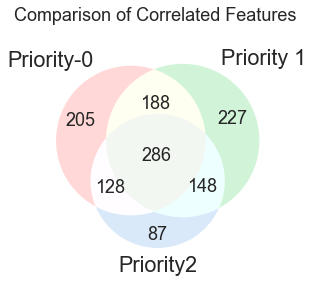

In [34]:
venn3(UncorrelatedTokens, set_labels = ('Priority-0', 'Priority 1', 'Priority2'))
plt.title('Comparison of Correlated Features \n')

### To access each intersect individually

In [36]:
category_id = 0
coefs = model.coef_[int(category_id)]
coefs = pd.Series(coefs, index=total_features)

### Step -1 Removing Single occurrence tokens


In [37]:
WordFreq = np.hstack(data['MailsContent'].apply(nltk.tokenize.word_tokenize).tolist())
WordFreq = nltk.FreqDist(WordFreq)
WordFreq = pd.Series(WordFreq)
InfrequentTokens =  WordFreq[WordFreq<=2].index
# Add these InfrequentTokens to extrastopwords
WordFreq[WordFreq<=2].head()

872                                           1
Marketing/HR                                  2
//www.pardot.com/                             2
Notification                                  2
//pi.pardot.com/prospect/read/id/112010501    1
dtype: int64

## Step -2 Analyze and remove less Weighted Tokens which or note involved in weighted tokens of other labels

In [38]:
# Check each Uncorrelated with correlations of others

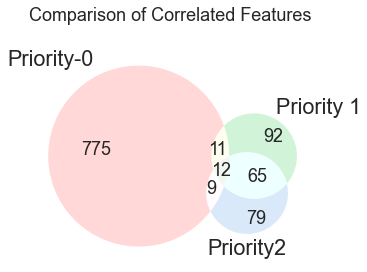

In [39]:
venn3([UncorrelatedTokens[0], CorrelatedTokens[1], CorrelatedTokens[2]], set_labels = ('Priority-0', 'Priority 1', 'Priority2'))
plt.title('Comparison of Correlated Features \n')
AnalyzeAddToESP = UncorrelatedTokens[0] - (CorrelatedTokens[1] | CorrelatedTokens[2])

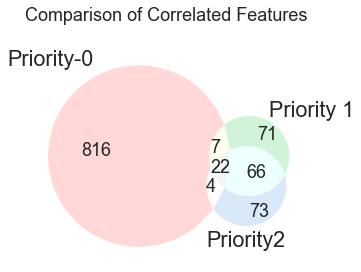

In [40]:
# Prio 1 Differentiation 
venn3([UncorrelatedTokens[1], CorrelatedTokens[0], CorrelatedTokens[2]], set_labels = ('Priority-0', 'Priority 1', 'Priority2'))
plt.title('Comparison of Correlated Features \n')
AnalyzeAddToESP = UncorrelatedTokens[1] - (CorrelatedTokens[0] | CorrelatedTokens[2])

In [41]:
data.shape

(98, 20)

In [42]:
## Remove all these complete intersection tokens from corpus ( add those to extra stopwords)
CorrTokens[0].intersection(CorrTokens[1]).intersection(CorrTokens[2])

{'11',
 '14',
 '23',
 '24',
 '29',
 '3',
 '31',
 '32',
 '33',
 '35',
 '38',
 '39',
 '4',
 '42',
 '45',
 '56',
 '6',
 '62',
 '63',
 '67',
 'glove-105',
 'glove-14',
 'glove-140',
 'glove-148',
 'glove-159',
 'glove-177',
 'glove-220',
 'glove-239',
 'glove-290',
 'glove-38',
 'glove-50',
 'glove-87',
 'glove-88'}

### Step -3 Analyze and remove large overlapping Keywords

Text(0.5, 1.0, 'Comparison of Correlated Features \n')

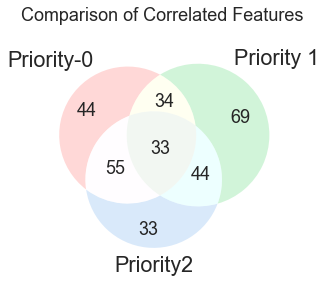

In [43]:
venn3(CorrelatedTokens, set_labels = ('Priority-0', 'Priority 1', 'Priority2'))
plt.title('Comparison of Correlated Features \n')

In [45]:
i=0

In [46]:
## Check individually each token weather it is a reasonable or not
i +=10 
list(CorrTokens[0])[i:i+10]


['glove-65',
 '63',
 'glove-139',
 'glove-99',
 'glove-185',
 'glove-56',
 'in',
 '67',
 'all',
 'glove-1']

### Step - 4 Augmenting data with Keywords for specific Unbalanced propertion  for False Positives

In [66]:
def InsertElement(mail, keyword):
    text = nltk.tokenize.word_tokenize(mail)
    text.insert(np.random.randint(len(text)-1), keyword)
    return ' '.join(text)

fraction = 0.2
keywords = ['Navigation Failures', 'Gps not working']
# First filter with conditions for mails need to be augmented ( add as much filters possible)
MinorSample = data[data['Contact Reason']=='Software']
AugmentedData = []
for kw in keywords:
    SampleData = MinorSample.sample(frac=fraction)
    SampleData['Ticket Number'] = SampleData['Ticket Number']+10000000
    #SampleData['Ticket Number'] = SampleData['Ticket Number'].astype(str)+ '-1'
    SampleData['MailsContent'] = SampleData['MailsContent'].apply(lambda x: InsertElement(x, kw.lower()))
    AugmentedData.append(SampleData)
AugmentedData = pd.concat(AugmentedData)

In [75]:
# Concatenate with original data
data = pd.concat([data, AugmentedData])
# save it for further reference

Matplotlib is building the font cache; this may take a moment.


<AxesSubplot:>

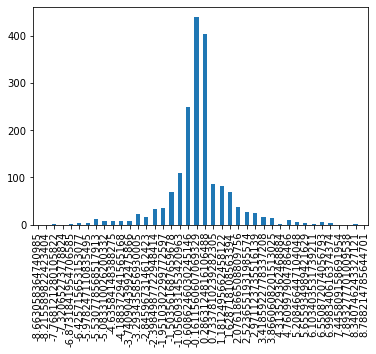

In [90]:
CoefDist.value_counts().sort_index().plot.bar()